In [1]:
%matplotlib inline

import os
while 'source' not in os.listdir():
    os.chdir('..')
os.chdir('source')

FORCE = False

import gpu

In [2]:
from util import getHashId


props={
    'path'          : 'data',
    'seed'          : 42,
    'split'         : 0.8,
    'test_split'    : 0.5,
    'control'       : True,
    'huntington'    : False,
    'left'          : True,
    'right'         : True,
    'threshold'     : None,
    'binarize'      : False,
    'not_connected' : False,
    'single'        : None,
    'features'      : [],
    'features_vox'  : [],
    'radiomics'     : [
        #{'sp':'native','im':'t1','fe':['b25'],'fi':['roi','t1_mask']},
    ],
    'space'         : 'native',
    'radiomics_vox' : [
        {'im':'t1','fe':['k5_b25','k7_b25','k9_b25','k11_b25','k13_b25','k15_b25','k17_b25','k19_b25','k21_b25']},
    ],
    'rad_vox_norm'  : 'norm',
    'inps'          : [],
    'features_clin' : None,
    'outp'          : 'diffusion_md',
    'balance_data'  : False,
    'exclude'       : ['t1t2','normalized'],
    'include_warp'  : True,
    'collapse_max'  : False,
    'collapse_bin'  : False,
}

architecture={
    'activation'    : 'sigmoid',
    'layers'        : [1024,512,256,128],
    'loss'          : 'MSE',
    'learning_rate' : 0.001,
    'batch_size'    : 100,
    'patience'      : 7,
}

HASHID, HASH = getHashId(architecture,props)
print(HASH)

sigmoid_100_1024_512_256_128_0001_MSE_7_0_0_0_0_1_t1t2_normalized_e_n_e_0_1_e_1_0_diffusion_fa_data_norm_e_k5_b25_k7_b25_k9_b25_k11_b25_k13_b25_k15_b25_k17_b25_k19_b25_k21_b25_t1_1_42_n_native_08_05_n


In [3]:
from DataGenerator import DataGenerator

gen = DataGenerator(**props)
train, val, test = gen.getData()

print('train')
print(train[0].shape)
print(train[1].shape)
print('validation')
print(val[0].shape)
print(val[1].shape)
print('test')
print(test[0].shape)
print(test[1].shape)

train
(631390, 828)
(631390, 1)
validation
(74368, 828)
(74368, 1)
test
(85358, 828)
(85358, 1)


In [4]:
from Model import *
from tensorflow.keras.optimizers import Adam

path = props['path']+'/models'

stop = tf.keras.callbacks.EarlyStopping(
    monitor='val_loss',
    patience=architecture['patience'],
)
save = tf.keras.callbacks.ModelCheckpoint(
    filepath=path+'/{}.weights.h5'.format(HASHID),
    monitor='val_loss',
    mode='min',
    save_best_only=True,
    save_weights_only=True,
)

model = buildModel(train[0].shape[1], train[1].shape[1], activation=architecture['activation'], layers=architecture['layers'])

model.compile(loss=locals()[architecture['loss']], optimizer=Adam(learning_rate=architecture['learning_rate']), jit_compile=True, metrics=[STD,MAE])

model.summary()

Model: "FFN"


_________________________________________________________________


 Layer (type)                Output Shape              Param #   


 input_1 (InputLayer)        [(None, 828)]             0         


 dense (Dense)               (None, 1024)              848896    


 dense_1 (Dense)             (None, 512)               524800    


 dense_2 (Dense)             (None, 256)               131328    


 dense_3 (Dense)             (None, 128)               32896     


 dense_4 (Dense)             (None, 1)                 129       


Total params: 1538049 (5.87 MB)


Trainable params: 1538049 (5.87 MB)


Non-trainable params: 0 (0.00 Byte)


_________________________________________________________________


In [5]:
import os
from util import pickleSave

if FORCE or not os.path.exists(path+'/{}.pkl'.format(HASHID)):
    history = model.fit(DataWrapper(train,architecture['batch_size']),
        validation_data=DataWrapper(val,architecture['batch_size'],False),
        epochs=10000,
        verbose=1,
        callbacks = [save,stop],
    )
    pickleSave(path+'/{}.pkl'.format(HASHID), history.history)

model.load_weights(path+'/{}.weights.h5'.format(HASHID))

Epoch 1/10000


   1/6314 [..............................] - ETA: 1:44:03 - loss: 0.0399 - STD: 1.1190e-04 - MAE: 0.1852

  20/6314 [..............................] - ETA: 16s - loss: 0.0149 - STD: 2.5493e-04 - MAE: 0.0950    

  43/6314 [..............................] - ETA: 15s - loss: 0.0128 - STD: 4.0285e-04 - MAE: 0.0876

  64/6314 [..............................] - ETA: 15s - loss: 0.0118 - STD: 6.6724e-04 - MAE: 0.0841

  83/6314 [..............................] - ETA: 15s - loss: 0.0113 - STD: 0.0012 - MAE: 0.0824    

 103/6314 [..............................] - ETA: 15s - loss: 0.0109 - STD: 0.0024 - MAE: 0.0810

 124/6314 [..............................] - ETA: 15s - loss: 0.0105 - STD: 0.0060 - MAE: 0.0797

 144/6314 [..............................] - ETA: 15s - loss: 0.0102 - STD: 0.0101 - MAE: 0.0783

 164/6314 [..............................] - ETA: 15s - loss: 0.0099 - STD: 0.0138 - MAE: 0.0772

 184/6314 [..............................] - ETA: 15s - loss: 0.0097 - STD: 0.0166 - MAE: 0.0763

 208/6314 [..............................] - ETA: 15s - loss: 0.0095 - STD: 0.0195 - MAE: 0.0754

 237/6314 [>.............................] - ETA: 14s - loss: 0.0091 - STD: 0.0228 - MAE: 0.0738

 270/6314 [>.............................] - ETA: 13s - loss: 0.0089 - STD: 0.0268 - MAE: 0.0727

 303/6314 [>.............................] - ETA: 13s - loss: 0.0087 - STD: 0.0296 - MAE: 0.0717

 323/6314 [>.............................] - ETA: 13s - loss: 0.0086 - STD: 0.0311 - MAE: 0.0711

 345/6314 [>.............................] - ETA: 13s - loss: 0.0085 - STD: 0.0327 - MAE: 0.0705

 365/6314 [>.............................] - ETA: 13s - loss: 0.0083 - STD: 0.0338 - MAE: 0.0698

 385/6314 [>.............................] - ETA: 13s - loss: 0.0082 - STD: 0.0352 - MAE: 0.0693

 408/6314 [>.............................] - ETA: 13s - loss: 0.0081 - STD: 0.0366 - MAE: 0.0688

 433/6314 [=>............................] - ETA: 13s - loss: 0.0080 - STD: 0.0379 - MAE: 0.0683

 454/6314 [=>............................] - ETA: 13s - loss: 0.0080 - STD: 0.0387 - MAE: 0.0679

 473/6314 [=>............................] - ETA: 13s - loss: 0.0079 - STD: 0.0395 - MAE: 0.0675

 493/6314 [=>............................] - ETA: 13s - loss: 0.0078 - STD: 0.0402 - MAE: 0.0672

 512/6314 [=>............................] - ETA: 13s - loss: 0.0077 - STD: 0.0410 - MAE: 0.0668

 533/6314 [=>............................] - ETA: 13s - loss: 0.0076 - STD: 0.0419 - MAE: 0.0664

 558/6314 [=>............................] - ETA: 13s - loss: 0.0075 - STD: 0.0429 - MAE: 0.0659

 576/6314 [=>............................] - ETA: 13s - loss: 0.0075 - STD: 0.0435 - MAE: 0.0656

 606/6314 [=>............................] - ETA: 13s - loss: 0.0074 - STD: 0.0445 - MAE: 0.0651

 642/6314 [==>...........................] - ETA: 12s - loss: 0.0073 - STD: 0.0454 - MAE: 0.0646

 677/6314 [==>...........................] - ETA: 12s - loss: 0.0072 - STD: 0.0465 - MAE: 0.0642

 714/6314 [==>...........................] - ETA: 12s - loss: 0.0071 - STD: 0.0474 - MAE: 0.0635

 742/6314 [==>...........................] - ETA: 11s - loss: 0.0070 - STD: 0.0479 - MAE: 0.0631

 765/6314 [==>...........................] - ETA: 11s - loss: 0.0070 - STD: 0.0485 - MAE: 0.0628

 790/6314 [==>...........................] - ETA: 11s - loss: 0.0069 - STD: 0.0488 - MAE: 0.0626

 822/6314 [==>...........................] - ETA: 11s - loss: 0.0069 - STD: 0.0493 - MAE: 0.0624

 858/6314 [===>..........................] - ETA: 11s - loss: 0.0068 - STD: 0.0499 - MAE: 0.0621

 887/6314 [===>..........................] - ETA: 11s - loss: 0.0068 - STD: 0.0503 - MAE: 0.0618

 921/6314 [===>..........................] - ETA: 11s - loss: 0.0067 - STD: 0.0508 - MAE: 0.0616

 954/6314 [===>..........................] - ETA: 10s - loss: 0.0066 - STD: 0.0514 - MAE: 0.0612

 988/6314 [===>..........................] - ETA: 10s - loss: 0.0066 - STD: 0.0520 - MAE: 0.0610

1025/6314 [===>..........................] - ETA: 10s - loss: 0.0065 - STD: 0.0526 - MAE: 0.0607

1061/6314 [====>.........................] - ETA: 10s - loss: 0.0065 - STD: 0.0529 - MAE: 0.0605

1098/6314 [====>.........................] - ETA: 10s - loss: 0.0064 - STD: 0.0534 - MAE: 0.0602

1132/6314 [====>.........................] - ETA: 10s - loss: 0.0064 - STD: 0.0539 - MAE: 0.0599

1168/6314 [====>.........................] - ETA: 9s - loss: 0.0063 - STD: 0.0544 - MAE: 0.0597 

1204/6314 [====>.........................] - ETA: 9s - loss: 0.0063 - STD: 0.0549 - MAE: 0.0594

1239/6314 [====>.........................] - ETA: 9s - loss: 0.0063 - STD: 0.0553 - MAE: 0.0592

1276/6314 [=====>........................] - ETA: 9s - loss: 0.0062 - STD: 0.0556 - MAE: 0.0591

1311/6314 [=====>........................] - ETA: 9s - loss: 0.0062 - STD: 0.0558 - MAE: 0.0590

1345/6314 [=====>........................] - ETA: 9s - loss: 0.0062 - STD: 0.0561 - MAE: 0.0588

1380/6314 [=====>........................] - ETA: 9s - loss: 0.0061 - STD: 0.0564 - MAE: 0.0586

1413/6314 [=====>........................] - ETA: 9s - loss: 0.0061 - STD: 0.0567 - MAE: 0.0584

1445/6314 [=====>........................] - ETA: 8s - loss: 0.0061 - STD: 0.0569 - MAE: 0.0582

1481/6314 [======>.......................] - ETA: 8s - loss: 0.0060 - STD: 0.0573 - MAE: 0.0580

1515/6314 [======>.......................] - ETA: 8s - loss: 0.0060 - STD: 0.0576 - MAE: 0.0578

1549/6314 [======>.......................] - ETA: 8s - loss: 0.0060 - STD: 0.0579 - MAE: 0.0576

1583/6314 [======>.......................] - ETA: 8s - loss: 0.0059 - STD: 0.0582 - MAE: 0.0574

1620/6314 [======>.......................] - ETA: 8s - loss: 0.0059 - STD: 0.0584 - MAE: 0.0573

1656/6314 [======>.......................] - ETA: 8s - loss: 0.0059 - STD: 0.0587 - MAE: 0.0572

1693/6314 [=======>......................] - ETA: 8s - loss: 0.0058 - STD: 0.0590 - MAE: 0.0570

1725/6314 [=======>......................] - ETA: 8s - loss: 0.0058 - STD: 0.0593 - MAE: 0.0568

1751/6314 [=======>......................] - ETA: 8s - loss: 0.0058 - STD: 0.0594 - MAE: 0.0568

1782/6314 [=======>......................] - ETA: 8s - loss: 0.0058 - STD: 0.0596 - MAE: 0.0567

1816/6314 [=======>......................] - ETA: 7s - loss: 0.0058 - STD: 0.0598 - MAE: 0.0565

1852/6314 [=======>......................] - ETA: 7s - loss: 0.0057 - STD: 0.0600 - MAE: 0.0564

1891/6314 [=======>......................] - ETA: 7s - loss: 0.0057 - STD: 0.0602 - MAE: 0.0563

1931/6314 [========>.....................] - ETA: 7s - loss: 0.0057 - STD: 0.0604 - MAE: 0.0562

1971/6314 [========>.....................] - ETA: 7s - loss: 0.0057 - STD: 0.0607 - MAE: 0.0560

2005/6314 [========>.....................] - ETA: 7s - loss: 0.0056 - STD: 0.0610 - MAE: 0.0559

2043/6314 [========>.....................] - ETA: 7s - loss: 0.0056 - STD: 0.0612 - MAE: 0.0557

2079/6314 [========>.....................] - ETA: 7s - loss: 0.0056 - STD: 0.0615 - MAE: 0.0556

2115/6314 [=========>....................] - ETA: 7s - loss: 0.0056 - STD: 0.0617 - MAE: 0.0555

2149/6314 [=========>....................] - ETA: 7s - loss: 0.0056 - STD: 0.0617 - MAE: 0.0555

2172/6314 [=========>....................] - ETA: 7s - loss: 0.0055 - STD: 0.0619 - MAE: 0.0554

2194/6314 [=========>....................] - ETA: 7s - loss: 0.0055 - STD: 0.0620 - MAE: 0.0553

2216/6314 [=========>....................] - ETA: 7s - loss: 0.0055 - STD: 0.0621 - MAE: 0.0553

2235/6314 [=========>....................] - ETA: 7s - loss: 0.0055 - STD: 0.0622 - MAE: 0.0552

2257/6314 [=========>....................] - ETA: 7s - loss: 0.0055 - STD: 0.0624 - MAE: 0.0551

2282/6314 [=========>....................] - ETA: 7s - loss: 0.0055 - STD: 0.0624 - MAE: 0.0550

2303/6314 [=========>....................] - ETA: 7s - loss: 0.0055 - STD: 0.0625 - MAE: 0.0550

2324/6314 [==========>...................] - ETA: 6s - loss: 0.0055 - STD: 0.0626 - MAE: 0.0549

2344/6314 [==========>...................] - ETA: 6s - loss: 0.0054 - STD: 0.0627 - MAE: 0.0549

2364/6314 [==========>...................] - ETA: 6s - loss: 0.0054 - STD: 0.0628 - MAE: 0.0548

2386/6314 [==========>...................] - ETA: 6s - loss: 0.0054 - STD: 0.0629 - MAE: 0.0547

2408/6314 [==========>...................] - ETA: 6s - loss: 0.0054 - STD: 0.0630 - MAE: 0.0547

2429/6314 [==========>...................] - ETA: 6s - loss: 0.0054 - STD: 0.0631 - MAE: 0.0547

2449/6314 [==========>...................] - ETA: 6s - loss: 0.0054 - STD: 0.0632 - MAE: 0.0546

2471/6314 [==========>...................] - ETA: 6s - loss: 0.0054 - STD: 0.0633 - MAE: 0.0545

2491/6314 [==========>...................] - ETA: 6s - loss: 0.0054 - STD: 0.0634 - MAE: 0.0545

2511/6314 [==========>...................] - ETA: 6s - loss: 0.0054 - STD: 0.0634 - MAE: 0.0545

2534/6314 [===========>..................] - ETA: 6s - loss: 0.0054 - STD: 0.0635 - MAE: 0.0544

2554/6314 [===========>..................] - ETA: 6s - loss: 0.0054 - STD: 0.0636 - MAE: 0.0544

2575/6314 [===========>..................] - ETA: 6s - loss: 0.0053 - STD: 0.0637 - MAE: 0.0543

2596/6314 [===========>..................] - ETA: 6s - loss: 0.0053 - STD: 0.0638 - MAE: 0.0542

2619/6314 [===========>..................] - ETA: 6s - loss: 0.0053 - STD: 0.0639 - MAE: 0.0542

2651/6314 [===========>..................] - ETA: 6s - loss: 0.0053 - STD: 0.0639 - MAE: 0.0542

2687/6314 [===========>..................] - ETA: 6s - loss: 0.0053 - STD: 0.0641 - MAE: 0.0541

2706/6314 [===========>..................] - ETA: 7s - loss: 0.0053 - STD: 0.0641 - MAE: 0.0540

2736/6314 [===========>..................] - ETA: 7s - loss: 0.0053 - STD: 0.0642 - MAE: 0.0540

2770/6314 [============>.................] - ETA: 6s - loss: 0.0053 - STD: 0.0644 - MAE: 0.0539

2805/6314 [============>.................] - ETA: 6s - loss: 0.0053 - STD: 0.0645 - MAE: 0.0538

2842/6314 [============>.................] - ETA: 6s - loss: 0.0052 - STD: 0.0647 - MAE: 0.0537

2878/6314 [============>.................] - ETA: 6s - loss: 0.0052 - STD: 0.0648 - MAE: 0.0536

2916/6314 [============>.................] - ETA: 6s - loss: 0.0052 - STD: 0.0650 - MAE: 0.0535

2953/6314 [=============>................] - ETA: 6s - loss: 0.0052 - STD: 0.0651 - MAE: 0.0535

2989/6314 [=============>................] - ETA: 6s - loss: 0.0052 - STD: 0.0652 - MAE: 0.0534

3025/6314 [=============>................] - ETA: 6s - loss: 0.0052 - STD: 0.0653 - MAE: 0.0533

3066/6314 [=============>................] - ETA: 6s - loss: 0.0052 - STD: 0.0655 - MAE: 0.0532

3104/6314 [=============>................] - ETA: 6s - loss: 0.0051 - STD: 0.0656 - MAE: 0.0532

3143/6314 [=============>................] - ETA: 5s - loss: 0.0051 - STD: 0.0657 - MAE: 0.0531

3184/6314 [==============>...............] - ETA: 5s - loss: 0.0051 - STD: 0.0658 - MAE: 0.0530

3223/6314 [==============>...............] - ETA: 5s - loss: 0.0051 - STD: 0.0659 - MAE: 0.0530

3262/6314 [==============>...............] - ETA: 5s - loss: 0.0051 - STD: 0.0660 - MAE: 0.0528

3299/6314 [==============>...............] - ETA: 5s - loss: 0.0051 - STD: 0.0661 - MAE: 0.0528

3334/6314 [==============>...............] - ETA: 5s - loss: 0.0051 - STD: 0.0662 - MAE: 0.0527

3373/6314 [===============>..............] - ETA: 5s - loss: 0.0051 - STD: 0.0663 - MAE: 0.0526

3407/6314 [===============>..............] - ETA: 5s - loss: 0.0050 - STD: 0.0664 - MAE: 0.0526

3445/6314 [===============>..............] - ETA: 5s - loss: 0.0050 - STD: 0.0665 - MAE: 0.0525

3483/6314 [===============>..............] - ETA: 5s - loss: 0.0050 - STD: 0.0666 - MAE: 0.0524

3519/6314 [===============>..............] - ETA: 5s - loss: 0.0050 - STD: 0.0667 - MAE: 0.0524

3558/6314 [===============>..............] - ETA: 5s - loss: 0.0050 - STD: 0.0668 - MAE: 0.0523

3596/6314 [================>.............] - ETA: 4s - loss: 0.0050 - STD: 0.0669 - MAE: 0.0522

3634/6314 [================>.............] - ETA: 4s - loss: 0.0050 - STD: 0.0670 - MAE: 0.0522

3671/6314 [================>.............] - ETA: 4s - loss: 0.0050 - STD: 0.0671 - MAE: 0.0521

3709/6314 [================>.............] - ETA: 4s - loss: 0.0050 - STD: 0.0672 - MAE: 0.0521

3750/6314 [================>.............] - ETA: 4s - loss: 0.0050 - STD: 0.0673 - MAE: 0.0520

3790/6314 [=================>............] - ETA: 4s - loss: 0.0049 - STD: 0.0674 - MAE: 0.0519

3827/6314 [=================>............] - ETA: 4s - loss: 0.0049 - STD: 0.0674 - MAE: 0.0519

3864/6314 [=================>............] - ETA: 4s - loss: 0.0049 - STD: 0.0675 - MAE: 0.0518

3893/6314 [=================>............] - ETA: 4s - loss: 0.0049 - STD: 0.0676 - MAE: 0.0518

3922/6314 [=================>............] - ETA: 4s - loss: 0.0049 - STD: 0.0676 - MAE: 0.0517

3955/6314 [=================>............] - ETA: 4s - loss: 0.0049 - STD: 0.0677 - MAE: 0.0517

3991/6314 [=================>............] - ETA: 4s - loss: 0.0049 - STD: 0.0678 - MAE: 0.0516

4025/6314 [==================>...........] - ETA: 4s - loss: 0.0049 - STD: 0.0679 - MAE: 0.0516

4061/6314 [==================>...........] - ETA: 3s - loss: 0.0049 - STD: 0.0679 - MAE: 0.0515

4094/6314 [==================>...........] - ETA: 3s - loss: 0.0049 - STD: 0.0680 - MAE: 0.0515

4122/6314 [==================>...........] - ETA: 3s - loss: 0.0049 - STD: 0.0680 - MAE: 0.0514

4153/6314 [==================>...........] - ETA: 3s - loss: 0.0049 - STD: 0.0681 - MAE: 0.0514

4187/6314 [==================>...........] - ETA: 3s - loss: 0.0048 - STD: 0.0681 - MAE: 0.0514

4224/6314 [===================>..........] - ETA: 3s - loss: 0.0048 - STD: 0.0682 - MAE: 0.0514

4262/6314 [===================>..........] - ETA: 3s - loss: 0.0048 - STD: 0.0682 - MAE: 0.0513

4297/6314 [===================>..........] - ETA: 3s - loss: 0.0048 - STD: 0.0683 - MAE: 0.0513

4334/6314 [===================>..........] - ETA: 3s - loss: 0.0048 - STD: 0.0684 - MAE: 0.0512

4371/6314 [===================>..........] - ETA: 3s - loss: 0.0048 - STD: 0.0684 - MAE: 0.0512

4408/6314 [===================>..........] - ETA: 3s - loss: 0.0048 - STD: 0.0685 - MAE: 0.0511

4448/6314 [====================>.........] - ETA: 3s - loss: 0.0048 - STD: 0.0685 - MAE: 0.0511

4485/6314 [====================>.........] - ETA: 3s - loss: 0.0048 - STD: 0.0686 - MAE: 0.0511

4523/6314 [====================>.........] - ETA: 3s - loss: 0.0048 - STD: 0.0686 - MAE: 0.0510

4561/6314 [====================>.........] - ETA: 3s - loss: 0.0048 - STD: 0.0687 - MAE: 0.0509

4599/6314 [====================>.........] - ETA: 2s - loss: 0.0048 - STD: 0.0687 - MAE: 0.0509

4637/6314 [=====================>........] - ETA: 2s - loss: 0.0048 - STD: 0.0688 - MAE: 0.0509

4675/6314 [=====================>........] - ETA: 2s - loss: 0.0048 - STD: 0.0689 - MAE: 0.0508

4713/6314 [=====================>........] - ETA: 2s - loss: 0.0047 - STD: 0.0689 - MAE: 0.0508

4752/6314 [=====================>........] - ETA: 2s - loss: 0.0047 - STD: 0.0690 - MAE: 0.0507

4788/6314 [=====================>........] - ETA: 2s - loss: 0.0047 - STD: 0.0690 - MAE: 0.0507

4827/6314 [=====================>........] - ETA: 2s - loss: 0.0047 - STD: 0.0691 - MAE: 0.0507

4867/6314 [======================>.......] - ETA: 2s - loss: 0.0047 - STD: 0.0691 - MAE: 0.0506

4906/6314 [======================>.......] - ETA: 2s - loss: 0.0047 - STD: 0.0692 - MAE: 0.0506

4946/6314 [======================>.......] - ETA: 2s - loss: 0.0047 - STD: 0.0692 - MAE: 0.0505

4986/6314 [======================>.......] - ETA: 2s - loss: 0.0047 - STD: 0.0693 - MAE: 0.0505

5026/6314 [======================>.......] - ETA: 2s - loss: 0.0047 - STD: 0.0694 - MAE: 0.0505

5067/6314 [=======================>......] - ETA: 2s - loss: 0.0047 - STD: 0.0694 - MAE: 0.0504

5106/6314 [=======================>......] - ETA: 2s - loss: 0.0047 - STD: 0.0694 - MAE: 0.0504

5145/6314 [=======================>......] - ETA: 1s - loss: 0.0047 - STD: 0.0695 - MAE: 0.0504

5185/6314 [=======================>......] - ETA: 1s - loss: 0.0047 - STD: 0.0695 - MAE: 0.0503

5225/6314 [=======================>......] - ETA: 1s - loss: 0.0047 - STD: 0.0696 - MAE: 0.0503

5265/6314 [========================>.....] - ETA: 1s - loss: 0.0047 - STD: 0.0696 - MAE: 0.0503

5298/6314 [========================>.....] - ETA: 1s - loss: 0.0047 - STD: 0.0696 - MAE: 0.0503

5324/6314 [========================>.....] - ETA: 1s - loss: 0.0047 - STD: 0.0696 - MAE: 0.0502

5347/6314 [========================>.....] - ETA: 1s - loss: 0.0046 - STD: 0.0697 - MAE: 0.0502

5369/6314 [========================>.....] - ETA: 1s - loss: 0.0046 - STD: 0.0697 - MAE: 0.0502

5399/6314 [========================>.....] - ETA: 1s - loss: 0.0046 - STD: 0.0697 - MAE: 0.0502

5428/6314 [========================>.....] - ETA: 1s - loss: 0.0046 - STD: 0.0698 - MAE: 0.0502

5462/6314 [========================>.....] - ETA: 1s - loss: 0.0046 - STD: 0.0698 - MAE: 0.0501

5499/6314 [=========================>....] - ETA: 1s - loss: 0.0046 - STD: 0.0698 - MAE: 0.0501

5538/6314 [=========================>....] - ETA: 1s - loss: 0.0046 - STD: 0.0699 - MAE: 0.0501

5578/6314 [=========================>....] - ETA: 1s - loss: 0.0046 - STD: 0.0699 - MAE: 0.0500

5619/6314 [=========================>....] - ETA: 1s - loss: 0.0046 - STD: 0.0700 - MAE: 0.0500

5660/6314 [=========================>....] - ETA: 1s - loss: 0.0046 - STD: 0.0701 - MAE: 0.0499

5700/6314 [==========================>...] - ETA: 1s - loss: 0.0046 - STD: 0.0701 - MAE: 0.0499

5741/6314 [==========================>...] - ETA: 0s - loss: 0.0046 - STD: 0.0702 - MAE: 0.0499

5783/6314 [==========================>...] - ETA: 0s - loss: 0.0046 - STD: 0.0702 - MAE: 0.0498

5824/6314 [==========================>...] - ETA: 0s - loss: 0.0046 - STD: 0.0703 - MAE: 0.0498

5855/6314 [==========================>...] - ETA: 0s - loss: 0.0046 - STD: 0.0703 - MAE: 0.0498

5892/6314 [==========================>...] - ETA: 0s - loss: 0.0046 - STD: 0.0704 - MAE: 0.0497

5932/6314 [===========================>..] - ETA: 0s - loss: 0.0046 - STD: 0.0704 - MAE: 0.0497

5972/6314 [===========================>..] - ETA: 0s - loss: 0.0046 - STD: 0.0704 - MAE: 0.0497

6011/6314 [===========================>..] - ETA: 0s - loss: 0.0046 - STD: 0.0705 - MAE: 0.0496

6045/6314 [===========================>..] - ETA: 0s - loss: 0.0045 - STD: 0.0705 - MAE: 0.0496

6081/6314 [===========================>..] - ETA: 0s - loss: 0.0045 - STD: 0.0706 - MAE: 0.0496

6118/6314 [============================>.] - ETA: 0s - loss: 0.0045 - STD: 0.0706 - MAE: 0.0496

6137/6314 [============================>.] - ETA: 0s - loss: 0.0045 - STD: 0.0706 - MAE: 0.0495

6160/6314 [============================>.] - ETA: 0s - loss: 0.0045 - STD: 0.0706 - MAE: 0.0495

6188/6314 [============================>.] - ETA: 0s - loss: 0.0045 - STD: 0.0707 - MAE: 0.0495

6223/6314 [============================>.] - ETA: 0s - loss: 0.0045 - STD: 0.0707 - MAE: 0.0495

6260/6314 [============================>.] - ETA: 0s - loss: 0.0045 - STD: 0.0707 - MAE: 0.0494

6297/6314 [============================>.] - ETA: 0s - loss: 0.0045 - STD: 0.0708 - MAE: 0.0494

6314/6314 [==============================] - 12s 2ms/step - loss: 0.0045 - STD: 0.0708 - MAE: 0.0494 - val_loss: 0.0035 - val_STD: 0.0511 - val_MAE: 0.0430


Epoch 2/10000


   1/6314 [..............................] - ETA: 1:46 - loss: 0.0033 - STD: 0.0850 - MAE: 0.0432

  25/6314 [..............................] - ETA: 13s - loss: 0.0037 - STD: 0.0784 - MAE: 0.0439 

  46/6314 [..............................] - ETA: 14s - loss: 0.0038 - STD: 0.0778 - MAE: 0.0443

  76/6314 [..............................] - ETA: 12s - loss: 0.0037 - STD: 0.0779 - MAE: 0.0437

  97/6314 [..............................] - ETA: 13s - loss: 0.0037 - STD: 0.0778 - MAE: 0.0439

 118/6314 [..............................] - ETA: 13s - loss: 0.0036 - STD: 0.0771 - MAE: 0.0436

 137/6314 [..............................] - ETA: 13s - loss: 0.0036 - STD: 0.0770 - MAE: 0.0435

 167/6314 [..............................] - ETA: 13s - loss: 0.0036 - STD: 0.0773 - MAE: 0.0434

 190/6314 [..............................] - ETA: 13s - loss: 0.0036 - STD: 0.0772 - MAE: 0.0434

 211/6314 [>.............................] - ETA: 13s - loss: 0.0036 - STD: 0.0772 - MAE: 0.0436

 234/6314 [>.............................] - ETA: 13s - loss: 0.0036 - STD: 0.0773 - MAE: 0.0437

 265/6314 [>.............................] - ETA: 12s - loss: 0.0036 - STD: 0.0770 - MAE: 0.0438

 300/6314 [>.............................] - ETA: 12s - loss: 0.0036 - STD: 0.0772 - MAE: 0.0437

 326/6314 [>.............................] - ETA: 12s - loss: 0.0035 - STD: 0.0771 - MAE: 0.0437

 348/6314 [>.............................] - ETA: 12s - loss: 0.0035 - STD: 0.0771 - MAE: 0.0437

 371/6314 [>.............................] - ETA: 12s - loss: 0.0036 - STD: 0.0773 - MAE: 0.0438

 391/6314 [>.............................] - ETA: 12s - loss: 0.0036 - STD: 0.0772 - MAE: 0.0440

 423/6314 [=>............................] - ETA: 12s - loss: 0.0036 - STD: 0.0771 - MAE: 0.0440

 462/6314 [=>............................] - ETA: 11s - loss: 0.0036 - STD: 0.0772 - MAE: 0.0440

 496/6314 [=>............................] - ETA: 11s - loss: 0.0037 - STD: 0.0768 - MAE: 0.0443

 523/6314 [=>............................] - ETA: 11s - loss: 0.0037 - STD: 0.0768 - MAE: 0.0443

 542/6314 [=>............................] - ETA: 11s - loss: 0.0037 - STD: 0.0768 - MAE: 0.0443

 569/6314 [=>............................] - ETA: 11s - loss: 0.0037 - STD: 0.0770 - MAE: 0.0444

 594/6314 [=>............................] - ETA: 11s - loss: 0.0036 - STD: 0.0771 - MAE: 0.0443

 621/6314 [=>............................] - ETA: 11s - loss: 0.0036 - STD: 0.0771 - MAE: 0.0442

 649/6314 [==>...........................] - ETA: 11s - loss: 0.0036 - STD: 0.0771 - MAE: 0.0442

 671/6314 [==>...........................] - ETA: 11s - loss: 0.0036 - STD: 0.0772 - MAE: 0.0442

 693/6314 [==>...........................] - ETA: 11s - loss: 0.0036 - STD: 0.0773 - MAE: 0.0442

 713/6314 [==>...........................] - ETA: 11s - loss: 0.0036 - STD: 0.0773 - MAE: 0.0442

 730/6314 [==>...........................] - ETA: 11s - loss: 0.0036 - STD: 0.0774 - MAE: 0.0443

 752/6314 [==>...........................] - ETA: 11s - loss: 0.0037 - STD: 0.0773 - MAE: 0.0443

 789/6314 [==>...........................] - ETA: 11s - loss: 0.0037 - STD: 0.0774 - MAE: 0.0442

 826/6314 [==>...........................] - ETA: 10s - loss: 0.0037 - STD: 0.0776 - MAE: 0.0442

 864/6314 [===>..........................] - ETA: 10s - loss: 0.0037 - STD: 0.0775 - MAE: 0.0443

 899/6314 [===>..........................] - ETA: 10s - loss: 0.0037 - STD: 0.0773 - MAE: 0.0443

 930/6314 [===>..........................] - ETA: 10s - loss: 0.0037 - STD: 0.0774 - MAE: 0.0444

 966/6314 [===>..........................] - ETA: 10s - loss: 0.0037 - STD: 0.0774 - MAE: 0.0443

1005/6314 [===>..........................] - ETA: 9s - loss: 0.0037 - STD: 0.0774 - MAE: 0.0443 

1041/6314 [===>..........................] - ETA: 9s - loss: 0.0037 - STD: 0.0774 - MAE: 0.0443

1080/6314 [====>.........................] - ETA: 9s - loss: 0.0037 - STD: 0.0775 - MAE: 0.0443

1118/6314 [====>.........................] - ETA: 9s - loss: 0.0037 - STD: 0.0775 - MAE: 0.0443

1154/6314 [====>.........................] - ETA: 9s - loss: 0.0037 - STD: 0.0775 - MAE: 0.0443

1189/6314 [====>.........................] - ETA: 9s - loss: 0.0037 - STD: 0.0774 - MAE: 0.0443

1223/6314 [====>.........................] - ETA: 9s - loss: 0.0037 - STD: 0.0774 - MAE: 0.0443

1257/6314 [====>.........................] - ETA: 9s - loss: 0.0037 - STD: 0.0774 - MAE: 0.0442

1291/6314 [=====>........................] - ETA: 8s - loss: 0.0037 - STD: 0.0775 - MAE: 0.0442

1327/6314 [=====>........................] - ETA: 8s - loss: 0.0037 - STD: 0.0775 - MAE: 0.0442

1365/6314 [=====>........................] - ETA: 8s - loss: 0.0037 - STD: 0.0774 - MAE: 0.0443

1401/6314 [=====>........................] - ETA: 8s - loss: 0.0037 - STD: 0.0774 - MAE: 0.0443

1436/6314 [=====>........................] - ETA: 8s - loss: 0.0037 - STD: 0.0775 - MAE: 0.0442

1468/6314 [=====>........................] - ETA: 8s - loss: 0.0037 - STD: 0.0775 - MAE: 0.0442

1499/6314 [======>.......................] - ETA: 8s - loss: 0.0037 - STD: 0.0776 - MAE: 0.0443

1527/6314 [======>.......................] - ETA: 8s - loss: 0.0037 - STD: 0.0776 - MAE: 0.0442

1557/6314 [======>.......................] - ETA: 8s - loss: 0.0037 - STD: 0.0776 - MAE: 0.0443

1592/6314 [======>.......................] - ETA: 8s - loss: 0.0037 - STD: 0.0775 - MAE: 0.0442

1626/6314 [======>.......................] - ETA: 8s - loss: 0.0037 - STD: 0.0775 - MAE: 0.0442

1662/6314 [======>.......................] - ETA: 7s - loss: 0.0037 - STD: 0.0775 - MAE: 0.0442

1699/6314 [=======>......................] - ETA: 7s - loss: 0.0037 - STD: 0.0775 - MAE: 0.0443

1732/6314 [=======>......................] - ETA: 7s - loss: 0.0037 - STD: 0.0774 - MAE: 0.0443

1767/6314 [=======>......................] - ETA: 7s - loss: 0.0037 - STD: 0.0774 - MAE: 0.0442

1801/6314 [=======>......................] - ETA: 7s - loss: 0.0037 - STD: 0.0775 - MAE: 0.0442

1838/6314 [=======>......................] - ETA: 7s - loss: 0.0037 - STD: 0.0774 - MAE: 0.0442

1874/6314 [=======>......................] - ETA: 7s - loss: 0.0037 - STD: 0.0775 - MAE: 0.0442

1910/6314 [========>.....................] - ETA: 7s - loss: 0.0037 - STD: 0.0775 - MAE: 0.0442

1948/6314 [========>.....................] - ETA: 7s - loss: 0.0037 - STD: 0.0775 - MAE: 0.0442

1985/6314 [========>.....................] - ETA: 7s - loss: 0.0037 - STD: 0.0775 - MAE: 0.0442

2022/6314 [========>.....................] - ETA: 7s - loss: 0.0037 - STD: 0.0775 - MAE: 0.0442

2057/6314 [========>.....................] - ETA: 7s - loss: 0.0037 - STD: 0.0776 - MAE: 0.0442

2094/6314 [========>.....................] - ETA: 6s - loss: 0.0037 - STD: 0.0776 - MAE: 0.0442

2131/6314 [=========>....................] - ETA: 6s - loss: 0.0037 - STD: 0.0776 - MAE: 0.0442

2168/6314 [=========>....................] - ETA: 6s - loss: 0.0037 - STD: 0.0775 - MAE: 0.0442

2203/6314 [=========>....................] - ETA: 6s - loss: 0.0037 - STD: 0.0775 - MAE: 0.0442

2242/6314 [=========>....................] - ETA: 6s - loss: 0.0037 - STD: 0.0775 - MAE: 0.0442

2281/6314 [=========>....................] - ETA: 6s - loss: 0.0037 - STD: 0.0776 - MAE: 0.0442

2319/6314 [==========>...................] - ETA: 6s - loss: 0.0037 - STD: 0.0775 - MAE: 0.0442

2357/6314 [==========>...................] - ETA: 6s - loss: 0.0037 - STD: 0.0775 - MAE: 0.0442

2392/6314 [==========>...................] - ETA: 6s - loss: 0.0037 - STD: 0.0775 - MAE: 0.0442

2426/6314 [==========>...................] - ETA: 6s - loss: 0.0037 - STD: 0.0775 - MAE: 0.0442

2464/6314 [==========>...................] - ETA: 6s - loss: 0.0037 - STD: 0.0775 - MAE: 0.0442

2503/6314 [==========>...................] - ETA: 6s - loss: 0.0037 - STD: 0.0776 - MAE: 0.0441

2541/6314 [===========>..................] - ETA: 6s - loss: 0.0037 - STD: 0.0776 - MAE: 0.0441

2577/6314 [===========>..................] - ETA: 5s - loss: 0.0037 - STD: 0.0777 - MAE: 0.0441

2612/6314 [===========>..................] - ETA: 5s - loss: 0.0037 - STD: 0.0776 - MAE: 0.0441

2652/6314 [===========>..................] - ETA: 5s - loss: 0.0037 - STD: 0.0776 - MAE: 0.0441

2690/6314 [===========>..................] - ETA: 5s - loss: 0.0036 - STD: 0.0776 - MAE: 0.0441

2728/6314 [===========>..................] - ETA: 5s - loss: 0.0036 - STD: 0.0776 - MAE: 0.0441

2766/6314 [============>.................] - ETA: 5s - loss: 0.0036 - STD: 0.0776 - MAE: 0.0441

2806/6314 [============>.................] - ETA: 5s - loss: 0.0036 - STD: 0.0777 - MAE: 0.0441

2841/6314 [============>.................] - ETA: 5s - loss: 0.0036 - STD: 0.0777 - MAE: 0.0441

2869/6314 [============>.................] - ETA: 5s - loss: 0.0036 - STD: 0.0777 - MAE: 0.0441

2906/6314 [============>.................] - ETA: 5s - loss: 0.0036 - STD: 0.0777 - MAE: 0.0441

2944/6314 [============>.................] - ETA: 5s - loss: 0.0036 - STD: 0.0777 - MAE: 0.0441

2982/6314 [=============>................] - ETA: 5s - loss: 0.0037 - STD: 0.0777 - MAE: 0.0441

3016/6314 [=============>................] - ETA: 5s - loss: 0.0036 - STD: 0.0778 - MAE: 0.0441

3056/6314 [=============>................] - ETA: 5s - loss: 0.0036 - STD: 0.0778 - MAE: 0.0441

3096/6314 [=============>................] - ETA: 5s - loss: 0.0036 - STD: 0.0778 - MAE: 0.0440

3135/6314 [=============>................] - ETA: 4s - loss: 0.0036 - STD: 0.0778 - MAE: 0.0440

3174/6314 [==============>...............] - ETA: 4s - loss: 0.0036 - STD: 0.0778 - MAE: 0.0440

3214/6314 [==============>...............] - ETA: 4s - loss: 0.0036 - STD: 0.0778 - MAE: 0.0440

3254/6314 [==============>...............] - ETA: 4s - loss: 0.0036 - STD: 0.0778 - MAE: 0.0440

3292/6314 [==============>...............] - ETA: 4s - loss: 0.0036 - STD: 0.0778 - MAE: 0.0440

3330/6314 [==============>...............] - ETA: 4s - loss: 0.0036 - STD: 0.0778 - MAE: 0.0440

3369/6314 [===============>..............] - ETA: 4s - loss: 0.0036 - STD: 0.0778 - MAE: 0.0440

3408/6314 [===============>..............] - ETA: 4s - loss: 0.0036 - STD: 0.0778 - MAE: 0.0440

3444/6314 [===============>..............] - ETA: 4s - loss: 0.0036 - STD: 0.0778 - MAE: 0.0440

3482/6314 [===============>..............] - ETA: 4s - loss: 0.0036 - STD: 0.0778 - MAE: 0.0440

3520/6314 [===============>..............] - ETA: 4s - loss: 0.0036 - STD: 0.0779 - MAE: 0.0440

3558/6314 [===============>..............] - ETA: 4s - loss: 0.0036 - STD: 0.0779 - MAE: 0.0440

3594/6314 [================>.............] - ETA: 4s - loss: 0.0036 - STD: 0.0779 - MAE: 0.0439

3633/6314 [================>.............] - ETA: 4s - loss: 0.0036 - STD: 0.0779 - MAE: 0.0439

3670/6314 [================>.............] - ETA: 4s - loss: 0.0036 - STD: 0.0779 - MAE: 0.0439

3707/6314 [================>.............] - ETA: 3s - loss: 0.0036 - STD: 0.0779 - MAE: 0.0439

3745/6314 [================>.............] - ETA: 3s - loss: 0.0036 - STD: 0.0779 - MAE: 0.0439

3782/6314 [================>.............] - ETA: 3s - loss: 0.0036 - STD: 0.0780 - MAE: 0.0439

3819/6314 [=================>............] - ETA: 3s - loss: 0.0036 - STD: 0.0780 - MAE: 0.0439

3857/6314 [=================>............] - ETA: 3s - loss: 0.0036 - STD: 0.0780 - MAE: 0.0439

3896/6314 [=================>............] - ETA: 3s - loss: 0.0036 - STD: 0.0780 - MAE: 0.0439

3935/6314 [=================>............] - ETA: 3s - loss: 0.0036 - STD: 0.0780 - MAE: 0.0439

3961/6314 [=================>............] - ETA: 3s - loss: 0.0036 - STD: 0.0780 - MAE: 0.0439

3996/6314 [=================>............] - ETA: 3s - loss: 0.0036 - STD: 0.0780 - MAE: 0.0439

4031/6314 [==================>...........] - ETA: 3s - loss: 0.0036 - STD: 0.0780 - MAE: 0.0439

4067/6314 [==================>...........] - ETA: 3s - loss: 0.0036 - STD: 0.0780 - MAE: 0.0439

4100/6314 [==================>...........] - ETA: 3s - loss: 0.0036 - STD: 0.0780 - MAE: 0.0439

4134/6314 [==================>...........] - ETA: 3s - loss: 0.0036 - STD: 0.0780 - MAE: 0.0439

4172/6314 [==================>...........] - ETA: 3s - loss: 0.0036 - STD: 0.0780 - MAE: 0.0439

4203/6314 [==================>...........] - ETA: 3s - loss: 0.0036 - STD: 0.0780 - MAE: 0.0439

4227/6314 [===================>..........] - ETA: 3s - loss: 0.0036 - STD: 0.0780 - MAE: 0.0439

4248/6314 [===================>..........] - ETA: 3s - loss: 0.0036 - STD: 0.0780 - MAE: 0.0439

4278/6314 [===================>..........] - ETA: 3s - loss: 0.0036 - STD: 0.0781 - MAE: 0.0439

4305/6314 [===================>..........] - ETA: 3s - loss: 0.0036 - STD: 0.0781 - MAE: 0.0439

4336/6314 [===================>..........] - ETA: 3s - loss: 0.0036 - STD: 0.0781 - MAE: 0.0439

4370/6314 [===================>..........] - ETA: 2s - loss: 0.0036 - STD: 0.0781 - MAE: 0.0439

4406/6314 [===================>..........] - ETA: 2s - loss: 0.0036 - STD: 0.0780 - MAE: 0.0439

4441/6314 [====================>.........] - ETA: 2s - loss: 0.0036 - STD: 0.0780 - MAE: 0.0439

4472/6314 [====================>.........] - ETA: 2s - loss: 0.0036 - STD: 0.0780 - MAE: 0.0438

4495/6314 [====================>.........] - ETA: 2s - loss: 0.0036 - STD: 0.0780 - MAE: 0.0438

4515/6314 [====================>.........] - ETA: 2s - loss: 0.0036 - STD: 0.0780 - MAE: 0.0438

4535/6314 [====================>.........] - ETA: 2s - loss: 0.0036 - STD: 0.0780 - MAE: 0.0438

4561/6314 [====================>.........] - ETA: 2s - loss: 0.0036 - STD: 0.0780 - MAE: 0.0438

4582/6314 [====================>.........] - ETA: 2s - loss: 0.0036 - STD: 0.0780 - MAE: 0.0438

4604/6314 [====================>.........] - ETA: 2s - loss: 0.0036 - STD: 0.0780 - MAE: 0.0438

4623/6314 [====================>.........] - ETA: 2s - loss: 0.0036 - STD: 0.0780 - MAE: 0.0438

4645/6314 [=====================>........] - ETA: 2s - loss: 0.0036 - STD: 0.0781 - MAE: 0.0438

4675/6314 [=====================>........] - ETA: 2s - loss: 0.0036 - STD: 0.0781 - MAE: 0.0438

4714/6314 [=====================>........] - ETA: 2s - loss: 0.0036 - STD: 0.0781 - MAE: 0.0438

4753/6314 [=====================>........] - ETA: 2s - loss: 0.0036 - STD: 0.0781 - MAE: 0.0438

4790/6314 [=====================>........] - ETA: 2s - loss: 0.0036 - STD: 0.0781 - MAE: 0.0438

4826/6314 [=====================>........] - ETA: 2s - loss: 0.0036 - STD: 0.0781 - MAE: 0.0438

4860/6314 [======================>.......] - ETA: 2s - loss: 0.0036 - STD: 0.0781 - MAE: 0.0438

4893/6314 [======================>.......] - ETA: 2s - loss: 0.0036 - STD: 0.0781 - MAE: 0.0438

4926/6314 [======================>.......] - ETA: 2s - loss: 0.0036 - STD: 0.0781 - MAE: 0.0438

4956/6314 [======================>.......] - ETA: 2s - loss: 0.0036 - STD: 0.0781 - MAE: 0.0437

4980/6314 [======================>.......] - ETA: 2s - loss: 0.0036 - STD: 0.0781 - MAE: 0.0437

5014/6314 [======================>.......] - ETA: 2s - loss: 0.0036 - STD: 0.0781 - MAE: 0.0437

5046/6314 [======================>.......] - ETA: 1s - loss: 0.0036 - STD: 0.0781 - MAE: 0.0437

5075/6314 [=======================>......] - ETA: 1s - loss: 0.0036 - STD: 0.0781 - MAE: 0.0437

5109/6314 [=======================>......] - ETA: 1s - loss: 0.0036 - STD: 0.0781 - MAE: 0.0437

5145/6314 [=======================>......] - ETA: 1s - loss: 0.0036 - STD: 0.0781 - MAE: 0.0437

5174/6314 [=======================>......] - ETA: 1s - loss: 0.0036 - STD: 0.0781 - MAE: 0.0437

5192/6314 [=======================>......] - ETA: 1s - loss: 0.0036 - STD: 0.0781 - MAE: 0.0437

5212/6314 [=======================>......] - ETA: 1s - loss: 0.0036 - STD: 0.0781 - MAE: 0.0437

5229/6314 [=======================>......] - ETA: 1s - loss: 0.0036 - STD: 0.0781 - MAE: 0.0437

5249/6314 [=======================>......] - ETA: 1s - loss: 0.0036 - STD: 0.0781 - MAE: 0.0437

5273/6314 [========================>.....] - ETA: 1s - loss: 0.0036 - STD: 0.0781 - MAE: 0.0437

5294/6314 [========================>.....] - ETA: 1s - loss: 0.0036 - STD: 0.0781 - MAE: 0.0437

5315/6314 [========================>.....] - ETA: 1s - loss: 0.0036 - STD: 0.0782 - MAE: 0.0437

5347/6314 [========================>.....] - ETA: 1s - loss: 0.0036 - STD: 0.0782 - MAE: 0.0437

5377/6314 [========================>.....] - ETA: 1s - loss: 0.0036 - STD: 0.0782 - MAE: 0.0437

5406/6314 [========================>.....] - ETA: 1s - loss: 0.0036 - STD: 0.0782 - MAE: 0.0437

5428/6314 [========================>.....] - ETA: 1s - loss: 0.0036 - STD: 0.0782 - MAE: 0.0437

5448/6314 [========================>.....] - ETA: 1s - loss: 0.0036 - STD: 0.0782 - MAE: 0.0436

5471/6314 [========================>.....] - ETA: 1s - loss: 0.0036 - STD: 0.0782 - MAE: 0.0436

5494/6314 [=========================>....] - ETA: 1s - loss: 0.0036 - STD: 0.0782 - MAE: 0.0436

5517/6314 [=========================>....] - ETA: 1s - loss: 0.0036 - STD: 0.0782 - MAE: 0.0436

5538/6314 [=========================>....] - ETA: 1s - loss: 0.0036 - STD: 0.0782 - MAE: 0.0436

5564/6314 [=========================>....] - ETA: 1s - loss: 0.0036 - STD: 0.0782 - MAE: 0.0436

5583/6314 [=========================>....] - ETA: 1s - loss: 0.0036 - STD: 0.0782 - MAE: 0.0436

5605/6314 [=========================>....] - ETA: 1s - loss: 0.0036 - STD: 0.0782 - MAE: 0.0436

5628/6314 [=========================>....] - ETA: 1s - loss: 0.0036 - STD: 0.0782 - MAE: 0.0436

5655/6314 [=========================>....] - ETA: 1s - loss: 0.0036 - STD: 0.0783 - MAE: 0.0436

5688/6314 [==========================>...] - ETA: 1s - loss: 0.0036 - STD: 0.0783 - MAE: 0.0436

5709/6314 [==========================>...] - ETA: 0s - loss: 0.0036 - STD: 0.0783 - MAE: 0.0436

5730/6314 [==========================>...] - ETA: 0s - loss: 0.0036 - STD: 0.0783 - MAE: 0.0436

5762/6314 [==========================>...] - ETA: 0s - loss: 0.0036 - STD: 0.0783 - MAE: 0.0436

5787/6314 [==========================>...] - ETA: 0s - loss: 0.0036 - STD: 0.0783 - MAE: 0.0435

5806/6314 [==========================>...] - ETA: 0s - loss: 0.0036 - STD: 0.0783 - MAE: 0.0435

5826/6314 [==========================>...] - ETA: 0s - loss: 0.0036 - STD: 0.0783 - MAE: 0.0435

5845/6314 [==========================>...] - ETA: 0s - loss: 0.0036 - STD: 0.0783 - MAE: 0.0435

5865/6314 [==========================>...] - ETA: 0s - loss: 0.0036 - STD: 0.0783 - MAE: 0.0435

5887/6314 [==========================>...] - ETA: 0s - loss: 0.0036 - STD: 0.0783 - MAE: 0.0435

5919/6314 [===========================>..] - ETA: 0s - loss: 0.0036 - STD: 0.0783 - MAE: 0.0435

5954/6314 [===========================>..] - ETA: 0s - loss: 0.0036 - STD: 0.0783 - MAE: 0.0435

5977/6314 [===========================>..] - ETA: 0s - loss: 0.0036 - STD: 0.0783 - MAE: 0.0435

5999/6314 [===========================>..] - ETA: 0s - loss: 0.0036 - STD: 0.0783 - MAE: 0.0435

6022/6314 [===========================>..] - ETA: 0s - loss: 0.0036 - STD: 0.0783 - MAE: 0.0435

6043/6314 [===========================>..] - ETA: 0s - loss: 0.0036 - STD: 0.0783 - MAE: 0.0435

6064/6314 [===========================>..] - ETA: 0s - loss: 0.0036 - STD: 0.0783 - MAE: 0.0435

6085/6314 [===========================>..] - ETA: 0s - loss: 0.0036 - STD: 0.0783 - MAE: 0.0435

6108/6314 [============================>.] - ETA: 0s - loss: 0.0036 - STD: 0.0783 - MAE: 0.0435

6130/6314 [============================>.] - ETA: 0s - loss: 0.0036 - STD: 0.0784 - MAE: 0.0435

6151/6314 [============================>.] - ETA: 0s - loss: 0.0036 - STD: 0.0784 - MAE: 0.0435

6177/6314 [============================>.] - ETA: 0s - loss: 0.0036 - STD: 0.0784 - MAE: 0.0435

6208/6314 [============================>.] - ETA: 0s - loss: 0.0036 - STD: 0.0784 - MAE: 0.0434

6233/6314 [============================>.] - ETA: 0s - loss: 0.0036 - STD: 0.0784 - MAE: 0.0435

6253/6314 [============================>.] - ETA: 0s - loss: 0.0036 - STD: 0.0784 - MAE: 0.0434

6275/6314 [============================>.] - ETA: 0s - loss: 0.0036 - STD: 0.0784 - MAE: 0.0434

6293/6314 [============================>.] - ETA: 0s - loss: 0.0036 - STD: 0.0784 - MAE: 0.0434

6314/6314 [==============================] - ETA: 0s - loss: 0.0036 - STD: 0.0784 - MAE: 0.0434

6314/6314 [==============================] - 11s 2ms/step - loss: 0.0036 - STD: 0.0784 - MAE: 0.0434 - val_loss: 0.0040 - val_STD: 0.0573 - val_MAE: 0.0457


Epoch 3/10000


   1/6314 [..............................] - ETA: 2:46 - loss: 0.0031 - STD: 0.0924 - MAE: 0.0402

  29/6314 [..............................] - ETA: 11s - loss: 0.0036 - STD: 0.0797 - MAE: 0.0432 

  66/6314 [..............................] - ETA: 9s - loss: 0.0034 - STD: 0.0804 - MAE: 0.0425 

 101/6314 [..............................] - ETA: 9s - loss: 0.0034 - STD: 0.0805 - MAE: 0.0424

 139/6314 [..............................] - ETA: 9s - loss: 0.0034 - STD: 0.0804 - MAE: 0.0422

 174/6314 [..............................] - ETA: 8s - loss: 0.0034 - STD: 0.0804 - MAE: 0.0423

 212/6314 [>.............................] - ETA: 8s - loss: 0.0034 - STD: 0.0804 - MAE: 0.0422

 250/6314 [>.............................] - ETA: 8s - loss: 0.0034 - STD: 0.0799 - MAE: 0.0423

 287/6314 [>.............................] - ETA: 8s - loss: 0.0034 - STD: 0.0799 - MAE: 0.0423

 325/6314 [>.............................] - ETA: 8s - loss: 0.0034 - STD: 0.0802 - MAE: 0.0423

 362/6314 [>.............................] - ETA: 8s - loss: 0.0034 - STD: 0.0802 - MAE: 0.0422

 399/6314 [>.............................] - ETA: 8s - loss: 0.0034 - STD: 0.0802 - MAE: 0.0424

 437/6314 [=>............................] - ETA: 8s - loss: 0.0034 - STD: 0.0802 - MAE: 0.0423

 474/6314 [=>............................] - ETA: 8s - loss: 0.0033 - STD: 0.0801 - MAE: 0.0422

 508/6314 [=>............................] - ETA: 8s - loss: 0.0033 - STD: 0.0803 - MAE: 0.0422

 539/6314 [=>............................] - ETA: 8s - loss: 0.0033 - STD: 0.0804 - MAE: 0.0421

 562/6314 [=>............................] - ETA: 8s - loss: 0.0033 - STD: 0.0803 - MAE: 0.0421

 585/6314 [=>............................] - ETA: 8s - loss: 0.0033 - STD: 0.0802 - MAE: 0.0421

 606/6314 [=>............................] - ETA: 8s - loss: 0.0033 - STD: 0.0802 - MAE: 0.0422

 631/6314 [=>............................] - ETA: 8s - loss: 0.0033 - STD: 0.0802 - MAE: 0.0421

 656/6314 [==>...........................] - ETA: 8s - loss: 0.0033 - STD: 0.0803 - MAE: 0.0421

 677/6314 [==>...........................] - ETA: 8s - loss: 0.0033 - STD: 0.0801 - MAE: 0.0421

 699/6314 [==>...........................] - ETA: 8s - loss: 0.0033 - STD: 0.0798 - MAE: 0.0422

 722/6314 [==>...........................] - ETA: 9s - loss: 0.0033 - STD: 0.0799 - MAE: 0.0422

 745/6314 [==>...........................] - ETA: 9s - loss: 0.0033 - STD: 0.0798 - MAE: 0.0422

 765/6314 [==>...........................] - ETA: 9s - loss: 0.0033 - STD: 0.0798 - MAE: 0.0421

 798/6314 [==>...........................] - ETA: 9s - loss: 0.0033 - STD: 0.0798 - MAE: 0.0421

 836/6314 [==>...........................] - ETA: 9s - loss: 0.0033 - STD: 0.0798 - MAE: 0.0421

 872/6314 [===>..........................] - ETA: 8s - loss: 0.0033 - STD: 0.0799 - MAE: 0.0422

 911/6314 [===>..........................] - ETA: 8s - loss: 0.0033 - STD: 0.0798 - MAE: 0.0421

 933/6314 [===>..........................] - ETA: 8s - loss: 0.0033 - STD: 0.0798 - MAE: 0.0421

 961/6314 [===>..........................] - ETA: 8s - loss: 0.0034 - STD: 0.0797 - MAE: 0.0422

 979/6314 [===>..........................] - ETA: 8s - loss: 0.0034 - STD: 0.0797 - MAE: 0.0422

1000/6314 [===>..........................] - ETA: 8s - loss: 0.0034 - STD: 0.0797 - MAE: 0.0422

1020/6314 [===>..........................] - ETA: 8s - loss: 0.0034 - STD: 0.0797 - MAE: 0.0422

1044/6314 [===>..........................] - ETA: 9s - loss: 0.0034 - STD: 0.0796 - MAE: 0.0422

1066/6314 [====>.........................] - ETA: 9s - loss: 0.0033 - STD: 0.0796 - MAE: 0.0421

1088/6314 [====>.........................] - ETA: 9s - loss: 0.0034 - STD: 0.0796 - MAE: 0.0422

1115/6314 [====>.........................] - ETA: 9s - loss: 0.0034 - STD: 0.0795 - MAE: 0.0422

1144/6314 [====>.........................] - ETA: 8s - loss: 0.0034 - STD: 0.0795 - MAE: 0.0422

1165/6314 [====>.........................] - ETA: 9s - loss: 0.0034 - STD: 0.0795 - MAE: 0.0422

1183/6314 [====>.........................] - ETA: 9s - loss: 0.0034 - STD: 0.0795 - MAE: 0.0422

1201/6314 [====>.........................] - ETA: 9s - loss: 0.0034 - STD: 0.0796 - MAE: 0.0422

1220/6314 [====>.........................] - ETA: 9s - loss: 0.0034 - STD: 0.0796 - MAE: 0.0421

1242/6314 [====>.........................] - ETA: 9s - loss: 0.0033 - STD: 0.0796 - MAE: 0.0421

1268/6314 [=====>........................] - ETA: 9s - loss: 0.0033 - STD: 0.0796 - MAE: 0.0421

1289/6314 [=====>........................] - ETA: 9s - loss: 0.0033 - STD: 0.0796 - MAE: 0.0421

1311/6314 [=====>........................] - ETA: 9s - loss: 0.0034 - STD: 0.0795 - MAE: 0.0421

1344/6314 [=====>........................] - ETA: 9s - loss: 0.0034 - STD: 0.0795 - MAE: 0.0421

1369/6314 [=====>........................] - ETA: 9s - loss: 0.0034 - STD: 0.0795 - MAE: 0.0421

1391/6314 [=====>........................] - ETA: 9s - loss: 0.0034 - STD: 0.0795 - MAE: 0.0421

1426/6314 [=====>........................] - ETA: 8s - loss: 0.0034 - STD: 0.0796 - MAE: 0.0421

1461/6314 [=====>........................] - ETA: 8s - loss: 0.0034 - STD: 0.0796 - MAE: 0.0421

1499/6314 [======>.......................] - ETA: 8s - loss: 0.0034 - STD: 0.0795 - MAE: 0.0421

1537/6314 [======>.......................] - ETA: 8s - loss: 0.0034 - STD: 0.0796 - MAE: 0.0421

1573/6314 [======>.......................] - ETA: 8s - loss: 0.0034 - STD: 0.0796 - MAE: 0.0421

1609/6314 [======>.......................] - ETA: 8s - loss: 0.0034 - STD: 0.0795 - MAE: 0.0421

1647/6314 [======>.......................] - ETA: 8s - loss: 0.0034 - STD: 0.0796 - MAE: 0.0421

1683/6314 [======>.......................] - ETA: 8s - loss: 0.0034 - STD: 0.0795 - MAE: 0.0421

1718/6314 [=======>......................] - ETA: 8s - loss: 0.0034 - STD: 0.0796 - MAE: 0.0421

1758/6314 [=======>......................] - ETA: 7s - loss: 0.0034 - STD: 0.0796 - MAE: 0.0421

1795/6314 [=======>......................] - ETA: 7s - loss: 0.0034 - STD: 0.0796 - MAE: 0.0421

1832/6314 [=======>......................] - ETA: 7s - loss: 0.0034 - STD: 0.0796 - MAE: 0.0421

1868/6314 [=======>......................] - ETA: 7s - loss: 0.0034 - STD: 0.0796 - MAE: 0.0421

1905/6314 [========>.....................] - ETA: 7s - loss: 0.0034 - STD: 0.0797 - MAE: 0.0421

1941/6314 [========>.....................] - ETA: 7s - loss: 0.0034 - STD: 0.0798 - MAE: 0.0421

1977/6314 [========>.....................] - ETA: 7s - loss: 0.0034 - STD: 0.0798 - MAE: 0.0421

2016/6314 [========>.....................] - ETA: 7s - loss: 0.0034 - STD: 0.0798 - MAE: 0.0421

2055/6314 [========>.....................] - ETA: 7s - loss: 0.0034 - STD: 0.0798 - MAE: 0.0421

2095/6314 [========>.....................] - ETA: 7s - loss: 0.0034 - STD: 0.0798 - MAE: 0.0420

2133/6314 [=========>....................] - ETA: 6s - loss: 0.0033 - STD: 0.0798 - MAE: 0.0420

2169/6314 [=========>....................] - ETA: 6s - loss: 0.0033 - STD: 0.0798 - MAE: 0.0420

2206/6314 [=========>....................] - ETA: 6s - loss: 0.0033 - STD: 0.0798 - MAE: 0.0420

2241/6314 [=========>....................] - ETA: 6s - loss: 0.0033 - STD: 0.0797 - MAE: 0.0420

2278/6314 [=========>....................] - ETA: 6s - loss: 0.0033 - STD: 0.0797 - MAE: 0.0420

2316/6314 [==========>...................] - ETA: 6s - loss: 0.0033 - STD: 0.0798 - MAE: 0.0420

2354/6314 [==========>...................] - ETA: 6s - loss: 0.0033 - STD: 0.0798 - MAE: 0.0419

2389/6314 [==========>...................] - ETA: 6s - loss: 0.0033 - STD: 0.0798 - MAE: 0.0419

2427/6314 [==========>...................] - ETA: 6s - loss: 0.0033 - STD: 0.0797 - MAE: 0.0419

2463/6314 [==========>...................] - ETA: 6s - loss: 0.0033 - STD: 0.0798 - MAE: 0.0419

2501/6314 [==========>...................] - ETA: 6s - loss: 0.0033 - STD: 0.0797 - MAE: 0.0419

2542/6314 [===========>..................] - ETA: 6s - loss: 0.0033 - STD: 0.0797 - MAE: 0.0419

2579/6314 [===========>..................] - ETA: 6s - loss: 0.0033 - STD: 0.0797 - MAE: 0.0419

2616/6314 [===========>..................] - ETA: 5s - loss: 0.0033 - STD: 0.0798 - MAE: 0.0419

2657/6314 [===========>..................] - ETA: 5s - loss: 0.0033 - STD: 0.0797 - MAE: 0.0419

2697/6314 [===========>..................] - ETA: 5s - loss: 0.0033 - STD: 0.0797 - MAE: 0.0419

2737/6314 [============>.................] - ETA: 5s - loss: 0.0033 - STD: 0.0798 - MAE: 0.0419

2776/6314 [============>.................] - ETA: 5s - loss: 0.0033 - STD: 0.0798 - MAE: 0.0419

2815/6314 [============>.................] - ETA: 5s - loss: 0.0033 - STD: 0.0798 - MAE: 0.0419

2854/6314 [============>.................] - ETA: 5s - loss: 0.0033 - STD: 0.0798 - MAE: 0.0419

2893/6314 [============>.................] - ETA: 5s - loss: 0.0033 - STD: 0.0798 - MAE: 0.0419

2932/6314 [============>.................] - ETA: 5s - loss: 0.0033 - STD: 0.0798 - MAE: 0.0419

2970/6314 [=============>................] - ETA: 5s - loss: 0.0033 - STD: 0.0798 - MAE: 0.0419

3006/6314 [=============>................] - ETA: 5s - loss: 0.0033 - STD: 0.0798 - MAE: 0.0419

3045/6314 [=============>................] - ETA: 5s - loss: 0.0033 - STD: 0.0798 - MAE: 0.0419

3083/6314 [=============>................] - ETA: 5s - loss: 0.0033 - STD: 0.0799 - MAE: 0.0419

3122/6314 [=============>................] - ETA: 4s - loss: 0.0033 - STD: 0.0799 - MAE: 0.0419

3161/6314 [==============>...............] - ETA: 4s - loss: 0.0033 - STD: 0.0799 - MAE: 0.0419

3200/6314 [==============>...............] - ETA: 4s - loss: 0.0033 - STD: 0.0799 - MAE: 0.0420

3240/6314 [==============>...............] - ETA: 4s - loss: 0.0033 - STD: 0.0799 - MAE: 0.0420

3278/6314 [==============>...............] - ETA: 4s - loss: 0.0033 - STD: 0.0799 - MAE: 0.0420

3315/6314 [==============>...............] - ETA: 4s - loss: 0.0033 - STD: 0.0799 - MAE: 0.0420

3350/6314 [==============>...............] - ETA: 4s - loss: 0.0033 - STD: 0.0798 - MAE: 0.0419

3375/6314 [===============>..............] - ETA: 4s - loss: 0.0033 - STD: 0.0799 - MAE: 0.0419

3401/6314 [===============>..............] - ETA: 4s - loss: 0.0033 - STD: 0.0799 - MAE: 0.0419

3436/6314 [===============>..............] - ETA: 4s - loss: 0.0033 - STD: 0.0799 - MAE: 0.0419

3475/6314 [===============>..............] - ETA: 4s - loss: 0.0033 - STD: 0.0798 - MAE: 0.0419

3515/6314 [===============>..............] - ETA: 4s - loss: 0.0033 - STD: 0.0798 - MAE: 0.0419

3556/6314 [===============>..............] - ETA: 4s - loss: 0.0033 - STD: 0.0799 - MAE: 0.0419

3580/6314 [================>.............] - ETA: 4s - loss: 0.0033 - STD: 0.0798 - MAE: 0.0419

3602/6314 [================>.............] - ETA: 4s - loss: 0.0033 - STD: 0.0798 - MAE: 0.0419

3637/6314 [================>.............] - ETA: 4s - loss: 0.0033 - STD: 0.0798 - MAE: 0.0419

3673/6314 [================>.............] - ETA: 4s - loss: 0.0033 - STD: 0.0798 - MAE: 0.0419

3700/6314 [================>.............] - ETA: 4s - loss: 0.0033 - STD: 0.0798 - MAE: 0.0419

3725/6314 [================>.............] - ETA: 4s - loss: 0.0033 - STD: 0.0798 - MAE: 0.0419

3753/6314 [================>.............] - ETA: 3s - loss: 0.0033 - STD: 0.0798 - MAE: 0.0419

3782/6314 [================>.............] - ETA: 3s - loss: 0.0033 - STD: 0.0798 - MAE: 0.0419

3818/6314 [=================>............] - ETA: 3s - loss: 0.0033 - STD: 0.0798 - MAE: 0.0418

3855/6314 [=================>............] - ETA: 3s - loss: 0.0033 - STD: 0.0798 - MAE: 0.0418

3892/6314 [=================>............] - ETA: 3s - loss: 0.0033 - STD: 0.0798 - MAE: 0.0418

3930/6314 [=================>............] - ETA: 3s - loss: 0.0033 - STD: 0.0798 - MAE: 0.0418

3968/6314 [=================>............] - ETA: 3s - loss: 0.0033 - STD: 0.0798 - MAE: 0.0418

4007/6314 [==================>...........] - ETA: 3s - loss: 0.0033 - STD: 0.0798 - MAE: 0.0418

4047/6314 [==================>...........] - ETA: 3s - loss: 0.0033 - STD: 0.0798 - MAE: 0.0418

4084/6314 [==================>...........] - ETA: 3s - loss: 0.0033 - STD: 0.0798 - MAE: 0.0418

4124/6314 [==================>...........] - ETA: 3s - loss: 0.0033 - STD: 0.0798 - MAE: 0.0418

4163/6314 [==================>...........] - ETA: 3s - loss: 0.0033 - STD: 0.0798 - MAE: 0.0418

4203/6314 [==================>...........] - ETA: 3s - loss: 0.0033 - STD: 0.0798 - MAE: 0.0418

4240/6314 [===================>..........] - ETA: 3s - loss: 0.0033 - STD: 0.0799 - MAE: 0.0418

4269/6314 [===================>..........] - ETA: 3s - loss: 0.0033 - STD: 0.0799 - MAE: 0.0418

4291/6314 [===================>..........] - ETA: 3s - loss: 0.0033 - STD: 0.0799 - MAE: 0.0418

4314/6314 [===================>..........] - ETA: 3s - loss: 0.0033 - STD: 0.0799 - MAE: 0.0417

4335/6314 [===================>..........] - ETA: 3s - loss: 0.0033 - STD: 0.0799 - MAE: 0.0417

4355/6314 [===================>..........] - ETA: 3s - loss: 0.0033 - STD: 0.0799 - MAE: 0.0417

4382/6314 [===================>..........] - ETA: 3s - loss: 0.0033 - STD: 0.0799 - MAE: 0.0417

4422/6314 [====================>.........] - ETA: 2s - loss: 0.0033 - STD: 0.0799 - MAE: 0.0417

4461/6314 [====================>.........] - ETA: 2s - loss: 0.0033 - STD: 0.0799 - MAE: 0.0417

4481/6314 [====================>.........] - ETA: 2s - loss: 0.0033 - STD: 0.0799 - MAE: 0.0417

4505/6314 [====================>.........] - ETA: 2s - loss: 0.0033 - STD: 0.0799 - MAE: 0.0417

4541/6314 [====================>.........] - ETA: 2s - loss: 0.0033 - STD: 0.0799 - MAE: 0.0417

4576/6314 [====================>.........] - ETA: 2s - loss: 0.0033 - STD: 0.0799 - MAE: 0.0417

4605/6314 [====================>.........] - ETA: 2s - loss: 0.0033 - STD: 0.0800 - MAE: 0.0417

4640/6314 [=====================>........] - ETA: 2s - loss: 0.0033 - STD: 0.0800 - MAE: 0.0417

4668/6314 [=====================>........] - ETA: 2s - loss: 0.0033 - STD: 0.0800 - MAE: 0.0417

4705/6314 [=====================>........] - ETA: 2s - loss: 0.0033 - STD: 0.0800 - MAE: 0.0417

4743/6314 [=====================>........] - ETA: 2s - loss: 0.0033 - STD: 0.0799 - MAE: 0.0417

4783/6314 [=====================>........] - ETA: 2s - loss: 0.0033 - STD: 0.0800 - MAE: 0.0417

4819/6314 [=====================>........] - ETA: 2s - loss: 0.0033 - STD: 0.0800 - MAE: 0.0417

4857/6314 [======================>.......] - ETA: 2s - loss: 0.0033 - STD: 0.0799 - MAE: 0.0417

4894/6314 [======================>.......] - ETA: 2s - loss: 0.0033 - STD: 0.0799 - MAE: 0.0417

4932/6314 [======================>.......] - ETA: 2s - loss: 0.0033 - STD: 0.0800 - MAE: 0.0417

4961/6314 [======================>.......] - ETA: 2s - loss: 0.0033 - STD: 0.0799 - MAE: 0.0417

4983/6314 [======================>.......] - ETA: 2s - loss: 0.0033 - STD: 0.0800 - MAE: 0.0417

5003/6314 [======================>.......] - ETA: 2s - loss: 0.0033 - STD: 0.0799 - MAE: 0.0417

5025/6314 [======================>.......] - ETA: 2s - loss: 0.0033 - STD: 0.0799 - MAE: 0.0417

5046/6314 [======================>.......] - ETA: 1s - loss: 0.0033 - STD: 0.0799 - MAE: 0.0417

5066/6314 [=======================>......] - ETA: 1s - loss: 0.0033 - STD: 0.0799 - MAE: 0.0417

5085/6314 [=======================>......] - ETA: 1s - loss: 0.0033 - STD: 0.0800 - MAE: 0.0417

5105/6314 [=======================>......] - ETA: 1s - loss: 0.0033 - STD: 0.0800 - MAE: 0.0417

5129/6314 [=======================>......] - ETA: 1s - loss: 0.0033 - STD: 0.0800 - MAE: 0.0417

5150/6314 [=======================>......] - ETA: 1s - loss: 0.0033 - STD: 0.0800 - MAE: 0.0417

5174/6314 [=======================>......] - ETA: 1s - loss: 0.0033 - STD: 0.0800 - MAE: 0.0417

5196/6314 [=======================>......] - ETA: 1s - loss: 0.0033 - STD: 0.0800 - MAE: 0.0417

5217/6314 [=======================>......] - ETA: 1s - loss: 0.0033 - STD: 0.0800 - MAE: 0.0417

5239/6314 [=======================>......] - ETA: 1s - loss: 0.0033 - STD: 0.0800 - MAE: 0.0417

5261/6314 [=======================>......] - ETA: 1s - loss: 0.0033 - STD: 0.0800 - MAE: 0.0417

5283/6314 [========================>.....] - ETA: 1s - loss: 0.0033 - STD: 0.0800 - MAE: 0.0417

5305/6314 [========================>.....] - ETA: 1s - loss: 0.0033 - STD: 0.0800 - MAE: 0.0417

5330/6314 [========================>.....] - ETA: 1s - loss: 0.0033 - STD: 0.0800 - MAE: 0.0417

5355/6314 [========================>.....] - ETA: 1s - loss: 0.0033 - STD: 0.0800 - MAE: 0.0417

5380/6314 [========================>.....] - ETA: 1s - loss: 0.0033 - STD: 0.0800 - MAE: 0.0417

5405/6314 [========================>.....] - ETA: 1s - loss: 0.0033 - STD: 0.0800 - MAE: 0.0417

5427/6314 [========================>.....] - ETA: 1s - loss: 0.0033 - STD: 0.0800 - MAE: 0.0417

5448/6314 [========================>.....] - ETA: 1s - loss: 0.0033 - STD: 0.0800 - MAE: 0.0417

5474/6314 [=========================>....] - ETA: 1s - loss: 0.0033 - STD: 0.0800 - MAE: 0.0417

5495/6314 [=========================>....] - ETA: 1s - loss: 0.0033 - STD: 0.0800 - MAE: 0.0417

5514/6314 [=========================>....] - ETA: 1s - loss: 0.0033 - STD: 0.0800 - MAE: 0.0417

5536/6314 [=========================>....] - ETA: 1s - loss: 0.0033 - STD: 0.0800 - MAE: 0.0417

5567/6314 [=========================>....] - ETA: 1s - loss: 0.0033 - STD: 0.0800 - MAE: 0.0417

5590/6314 [=========================>....] - ETA: 1s - loss: 0.0033 - STD: 0.0800 - MAE: 0.0417

5617/6314 [=========================>....] - ETA: 1s - loss: 0.0033 - STD: 0.0801 - MAE: 0.0417

5654/6314 [=========================>....] - ETA: 1s - loss: 0.0033 - STD: 0.0801 - MAE: 0.0417

5692/6314 [==========================>...] - ETA: 1s - loss: 0.0033 - STD: 0.0801 - MAE: 0.0416

5730/6314 [==========================>...] - ETA: 0s - loss: 0.0033 - STD: 0.0801 - MAE: 0.0416

5750/6314 [==========================>...] - ETA: 0s - loss: 0.0033 - STD: 0.0801 - MAE: 0.0416

5779/6314 [==========================>...] - ETA: 0s - loss: 0.0033 - STD: 0.0801 - MAE: 0.0416

5799/6314 [==========================>...] - ETA: 0s - loss: 0.0033 - STD: 0.0801 - MAE: 0.0416

5823/6314 [==========================>...] - ETA: 0s - loss: 0.0033 - STD: 0.0801 - MAE: 0.0416

5846/6314 [==========================>...] - ETA: 0s - loss: 0.0033 - STD: 0.0801 - MAE: 0.0416

5867/6314 [==========================>...] - ETA: 0s - loss: 0.0033 - STD: 0.0801 - MAE: 0.0416

5886/6314 [==========================>...] - ETA: 0s - loss: 0.0033 - STD: 0.0801 - MAE: 0.0416

5907/6314 [===========================>..] - ETA: 0s - loss: 0.0033 - STD: 0.0801 - MAE: 0.0416

5930/6314 [===========================>..] - ETA: 0s - loss: 0.0033 - STD: 0.0801 - MAE: 0.0416

5953/6314 [===========================>..] - ETA: 0s - loss: 0.0033 - STD: 0.0801 - MAE: 0.0416

5983/6314 [===========================>..] - ETA: 0s - loss: 0.0033 - STD: 0.0801 - MAE: 0.0416

6008/6314 [===========================>..] - ETA: 0s - loss: 0.0033 - STD: 0.0801 - MAE: 0.0416

6029/6314 [===========================>..] - ETA: 0s - loss: 0.0033 - STD: 0.0801 - MAE: 0.0416

6047/6314 [===========================>..] - ETA: 0s - loss: 0.0033 - STD: 0.0801 - MAE: 0.0416

6069/6314 [===========================>..] - ETA: 0s - loss: 0.0033 - STD: 0.0801 - MAE: 0.0416

6096/6314 [===========================>..] - ETA: 0s - loss: 0.0033 - STD: 0.0802 - MAE: 0.0416

6124/6314 [============================>.] - ETA: 0s - loss: 0.0033 - STD: 0.0802 - MAE: 0.0416

6162/6314 [============================>.] - ETA: 0s - loss: 0.0033 - STD: 0.0802 - MAE: 0.0416

6199/6314 [============================>.] - ETA: 0s - loss: 0.0033 - STD: 0.0802 - MAE: 0.0416

6235/6314 [============================>.] - ETA: 0s - loss: 0.0033 - STD: 0.0802 - MAE: 0.0416

6273/6314 [============================>.] - ETA: 0s - loss: 0.0033 - STD: 0.0802 - MAE: 0.0416

6311/6314 [============================>.] - ETA: 0s - loss: 0.0033 - STD: 0.0802 - MAE: 0.0416

6314/6314 [==============================] - 11s 2ms/step - loss: 0.0033 - STD: 0.0802 - MAE: 0.0416 - val_loss: 0.0034 - val_STD: 0.0497 - val_MAE: 0.0422


Epoch 4/10000


   1/6314 [..............................] - ETA: 1:55 - loss: 0.0022 - STD: 0.0826 - MAE: 0.0376

  24/6314 [..............................] - ETA: 13s - loss: 0.0034 - STD: 0.0786 - MAE: 0.0420 

  45/6314 [..............................] - ETA: 14s - loss: 0.0033 - STD: 0.0797 - MAE: 0.0418

  72/6314 [..............................] - ETA: 13s - loss: 0.0033 - STD: 0.0797 - MAE: 0.0415

  92/6314 [..............................] - ETA: 14s - loss: 0.0031 - STD: 0.0807 - MAE: 0.0408

 114/6314 [..............................] - ETA: 14s - loss: 0.0031 - STD: 0.0805 - MAE: 0.0405

 136/6314 [..............................] - ETA: 14s - loss: 0.0031 - STD: 0.0809 - MAE: 0.0405

 156/6314 [..............................] - ETA: 14s - loss: 0.0030 - STD: 0.0810 - MAE: 0.0403

 183/6314 [..............................] - ETA: 13s - loss: 0.0030 - STD: 0.0808 - MAE: 0.0402

 221/6314 [>.............................] - ETA: 12s - loss: 0.0031 - STD: 0.0808 - MAE: 0.0404

 258/6314 [>.............................] - ETA: 12s - loss: 0.0031 - STD: 0.0805 - MAE: 0.0405

 292/6314 [>.............................] - ETA: 11s - loss: 0.0031 - STD: 0.0806 - MAE: 0.0404

 328/6314 [>.............................] - ETA: 11s - loss: 0.0031 - STD: 0.0807 - MAE: 0.0405

 365/6314 [>.............................] - ETA: 10s - loss: 0.0032 - STD: 0.0806 - MAE: 0.0409

 400/6314 [>.............................] - ETA: 10s - loss: 0.0032 - STD: 0.0808 - MAE: 0.0409

 434/6314 [=>............................] - ETA: 10s - loss: 0.0032 - STD: 0.0810 - MAE: 0.0409

 470/6314 [=>............................] - ETA: 10s - loss: 0.0032 - STD: 0.0808 - MAE: 0.0410

 507/6314 [=>............................] - ETA: 9s - loss: 0.0032 - STD: 0.0806 - MAE: 0.0410 

 542/6314 [=>............................] - ETA: 9s - loss: 0.0032 - STD: 0.0806 - MAE: 0.0410

 577/6314 [=>............................] - ETA: 9s - loss: 0.0032 - STD: 0.0806 - MAE: 0.0409

 610/6314 [=>............................] - ETA: 9s - loss: 0.0032 - STD: 0.0807 - MAE: 0.0410

 642/6314 [==>...........................] - ETA: 9s - loss: 0.0032 - STD: 0.0807 - MAE: 0.0410

 665/6314 [==>...........................] - ETA: 9s - loss: 0.0032 - STD: 0.0806 - MAE: 0.0410

 687/6314 [==>...........................] - ETA: 9s - loss: 0.0032 - STD: 0.0806 - MAE: 0.0410

 710/6314 [==>...........................] - ETA: 9s - loss: 0.0032 - STD: 0.0807 - MAE: 0.0410

 731/6314 [==>...........................] - ETA: 9s - loss: 0.0032 - STD: 0.0807 - MAE: 0.0410

 753/6314 [==>...........................] - ETA: 9s - loss: 0.0032 - STD: 0.0806 - MAE: 0.0410

 774/6314 [==>...........................] - ETA: 9s - loss: 0.0032 - STD: 0.0806 - MAE: 0.0410

 794/6314 [==>...........................] - ETA: 9s - loss: 0.0032 - STD: 0.0806 - MAE: 0.0410

 818/6314 [==>...........................] - ETA: 9s - loss: 0.0032 - STD: 0.0807 - MAE: 0.0410

 852/6314 [===>..........................] - ETA: 9s - loss: 0.0032 - STD: 0.0808 - MAE: 0.0409

 885/6314 [===>..........................] - ETA: 9s - loss: 0.0032 - STD: 0.0808 - MAE: 0.0410

 922/6314 [===>..........................] - ETA: 9s - loss: 0.0032 - STD: 0.0808 - MAE: 0.0409

 958/6314 [===>..........................] - ETA: 9s - loss: 0.0032 - STD: 0.0809 - MAE: 0.0409

 994/6314 [===>..........................] - ETA: 9s - loss: 0.0032 - STD: 0.0809 - MAE: 0.0409

1032/6314 [===>..........................] - ETA: 9s - loss: 0.0032 - STD: 0.0807 - MAE: 0.0409

1073/6314 [====>.........................] - ETA: 8s - loss: 0.0032 - STD: 0.0808 - MAE: 0.0409

1109/6314 [====>.........................] - ETA: 8s - loss: 0.0032 - STD: 0.0807 - MAE: 0.0409

1147/6314 [====>.........................] - ETA: 8s - loss: 0.0032 - STD: 0.0806 - MAE: 0.0409

1183/6314 [====>.........................] - ETA: 8s - loss: 0.0032 - STD: 0.0807 - MAE: 0.0409

1222/6314 [====>.........................] - ETA: 8s - loss: 0.0032 - STD: 0.0806 - MAE: 0.0409

1258/6314 [====>.........................] - ETA: 8s - loss: 0.0032 - STD: 0.0806 - MAE: 0.0408

1295/6314 [=====>........................] - ETA: 8s - loss: 0.0032 - STD: 0.0807 - MAE: 0.0408

1331/6314 [=====>........................] - ETA: 8s - loss: 0.0032 - STD: 0.0807 - MAE: 0.0408

1367/6314 [=====>........................] - ETA: 8s - loss: 0.0032 - STD: 0.0808 - MAE: 0.0408

1406/6314 [=====>........................] - ETA: 8s - loss: 0.0032 - STD: 0.0808 - MAE: 0.0408

1444/6314 [=====>........................] - ETA: 7s - loss: 0.0032 - STD: 0.0809 - MAE: 0.0408

1484/6314 [======>.......................] - ETA: 7s - loss: 0.0032 - STD: 0.0808 - MAE: 0.0409

1524/6314 [======>.......................] - ETA: 7s - loss: 0.0032 - STD: 0.0808 - MAE: 0.0409

1563/6314 [======>.......................] - ETA: 7s - loss: 0.0032 - STD: 0.0808 - MAE: 0.0409

1599/6314 [======>.......................] - ETA: 7s - loss: 0.0032 - STD: 0.0808 - MAE: 0.0409

1634/6314 [======>.......................] - ETA: 7s - loss: 0.0032 - STD: 0.0808 - MAE: 0.0409

1670/6314 [======>.......................] - ETA: 7s - loss: 0.0032 - STD: 0.0808 - MAE: 0.0409

1699/6314 [=======>......................] - ETA: 7s - loss: 0.0032 - STD: 0.0807 - MAE: 0.0409

1738/6314 [=======>......................] - ETA: 7s - loss: 0.0032 - STD: 0.0808 - MAE: 0.0409

1776/6314 [=======>......................] - ETA: 7s - loss: 0.0032 - STD: 0.0807 - MAE: 0.0408

1813/6314 [=======>......................] - ETA: 7s - loss: 0.0032 - STD: 0.0807 - MAE: 0.0408

1853/6314 [=======>......................] - ETA: 6s - loss: 0.0032 - STD: 0.0808 - MAE: 0.0408

1891/6314 [=======>......................] - ETA: 6s - loss: 0.0032 - STD: 0.0808 - MAE: 0.0408

1929/6314 [========>.....................] - ETA: 6s - loss: 0.0032 - STD: 0.0809 - MAE: 0.0408

1965/6314 [========>.....................] - ETA: 6s - loss: 0.0031 - STD: 0.0808 - MAE: 0.0408

2003/6314 [========>.....................] - ETA: 6s - loss: 0.0031 - STD: 0.0809 - MAE: 0.0408

2042/6314 [========>.....................] - ETA: 6s - loss: 0.0031 - STD: 0.0809 - MAE: 0.0407

2081/6314 [========>.....................] - ETA: 6s - loss: 0.0031 - STD: 0.0809 - MAE: 0.0407

2117/6314 [=========>....................] - ETA: 6s - loss: 0.0031 - STD: 0.0809 - MAE: 0.0407

2157/6314 [=========>....................] - ETA: 6s - loss: 0.0031 - STD: 0.0809 - MAE: 0.0407

2196/6314 [=========>....................] - ETA: 6s - loss: 0.0031 - STD: 0.0809 - MAE: 0.0407

2236/6314 [=========>....................] - ETA: 6s - loss: 0.0031 - STD: 0.0809 - MAE: 0.0407

2276/6314 [=========>....................] - ETA: 6s - loss: 0.0031 - STD: 0.0809 - MAE: 0.0407

2313/6314 [=========>....................] - ETA: 6s - loss: 0.0031 - STD: 0.0809 - MAE: 0.0406

2352/6314 [==========>...................] - ETA: 6s - loss: 0.0031 - STD: 0.0809 - MAE: 0.0406

2392/6314 [==========>...................] - ETA: 5s - loss: 0.0031 - STD: 0.0809 - MAE: 0.0406

2429/6314 [==========>...................] - ETA: 5s - loss: 0.0031 - STD: 0.0809 - MAE: 0.0406

2466/6314 [==========>...................] - ETA: 5s - loss: 0.0031 - STD: 0.0810 - MAE: 0.0406

2507/6314 [==========>...................] - ETA: 5s - loss: 0.0031 - STD: 0.0810 - MAE: 0.0406

2543/6314 [===========>..................] - ETA: 5s - loss: 0.0031 - STD: 0.0810 - MAE: 0.0406

2584/6314 [===========>..................] - ETA: 5s - loss: 0.0031 - STD: 0.0810 - MAE: 0.0406

2623/6314 [===========>..................] - ETA: 5s - loss: 0.0031 - STD: 0.0811 - MAE: 0.0406

2663/6314 [===========>..................] - ETA: 5s - loss: 0.0031 - STD: 0.0810 - MAE: 0.0406

2705/6314 [===========>..................] - ETA: 5s - loss: 0.0031 - STD: 0.0811 - MAE: 0.0406

2745/6314 [============>.................] - ETA: 5s - loss: 0.0031 - STD: 0.0811 - MAE: 0.0406

2784/6314 [============>.................] - ETA: 5s - loss: 0.0031 - STD: 0.0811 - MAE: 0.0406

2822/6314 [============>.................] - ETA: 5s - loss: 0.0031 - STD: 0.0811 - MAE: 0.0406

2856/6314 [============>.................] - ETA: 5s - loss: 0.0031 - STD: 0.0810 - MAE: 0.0406

2890/6314 [============>.................] - ETA: 5s - loss: 0.0031 - STD: 0.0810 - MAE: 0.0406

2927/6314 [============>.................] - ETA: 5s - loss: 0.0031 - STD: 0.0811 - MAE: 0.0406

2966/6314 [=============>................] - ETA: 4s - loss: 0.0031 - STD: 0.0811 - MAE: 0.0406

3005/6314 [=============>................] - ETA: 4s - loss: 0.0031 - STD: 0.0811 - MAE: 0.0406

3045/6314 [=============>................] - ETA: 4s - loss: 0.0031 - STD: 0.0811 - MAE: 0.0405

3086/6314 [=============>................] - ETA: 4s - loss: 0.0031 - STD: 0.0810 - MAE: 0.0405

3127/6314 [=============>................] - ETA: 4s - loss: 0.0031 - STD: 0.0811 - MAE: 0.0405

3165/6314 [==============>...............] - ETA: 4s - loss: 0.0031 - STD: 0.0810 - MAE: 0.0405

3202/6314 [==============>...............] - ETA: 4s - loss: 0.0031 - STD: 0.0811 - MAE: 0.0405

3240/6314 [==============>...............] - ETA: 4s - loss: 0.0031 - STD: 0.0811 - MAE: 0.0405

3276/6314 [==============>...............] - ETA: 4s - loss: 0.0031 - STD: 0.0811 - MAE: 0.0405

3311/6314 [==============>...............] - ETA: 4s - loss: 0.0031 - STD: 0.0811 - MAE: 0.0405

3348/6314 [==============>...............] - ETA: 4s - loss: 0.0031 - STD: 0.0811 - MAE: 0.0405

3387/6314 [===============>..............] - ETA: 4s - loss: 0.0031 - STD: 0.0811 - MAE: 0.0405

3421/6314 [===============>..............] - ETA: 4s - loss: 0.0031 - STD: 0.0811 - MAE: 0.0405

3455/6314 [===============>..............] - ETA: 4s - loss: 0.0031 - STD: 0.0811 - MAE: 0.0405

3490/6314 [===============>..............] - ETA: 4s - loss: 0.0031 - STD: 0.0811 - MAE: 0.0405

3530/6314 [===============>..............] - ETA: 4s - loss: 0.0031 - STD: 0.0812 - MAE: 0.0405

3565/6314 [===============>..............] - ETA: 3s - loss: 0.0031 - STD: 0.0812 - MAE: 0.0405

3590/6314 [================>.............] - ETA: 3s - loss: 0.0031 - STD: 0.0812 - MAE: 0.0405

3613/6314 [================>.............] - ETA: 3s - loss: 0.0031 - STD: 0.0812 - MAE: 0.0405

3640/6314 [================>.............] - ETA: 3s - loss: 0.0031 - STD: 0.0812 - MAE: 0.0405

3670/6314 [================>.............] - ETA: 3s - loss: 0.0031 - STD: 0.0812 - MAE: 0.0405

3692/6314 [================>.............] - ETA: 3s - loss: 0.0031 - STD: 0.0812 - MAE: 0.0405

3713/6314 [================>.............] - ETA: 3s - loss: 0.0031 - STD: 0.0812 - MAE: 0.0405

3733/6314 [================>.............] - ETA: 3s - loss: 0.0031 - STD: 0.0812 - MAE: 0.0405

3761/6314 [================>.............] - ETA: 3s - loss: 0.0031 - STD: 0.0812 - MAE: 0.0405

3780/6314 [================>.............] - ETA: 3s - loss: 0.0031 - STD: 0.0812 - MAE: 0.0405

3801/6314 [=================>............] - ETA: 3s - loss: 0.0031 - STD: 0.0812 - MAE: 0.0405

3822/6314 [=================>............] - ETA: 3s - loss: 0.0031 - STD: 0.0812 - MAE: 0.0405

3846/6314 [=================>............] - ETA: 3s - loss: 0.0031 - STD: 0.0812 - MAE: 0.0405

3870/6314 [=================>............] - ETA: 3s - loss: 0.0031 - STD: 0.0812 - MAE: 0.0405

3893/6314 [=================>............] - ETA: 3s - loss: 0.0031 - STD: 0.0812 - MAE: 0.0405

3923/6314 [=================>............] - ETA: 3s - loss: 0.0031 - STD: 0.0812 - MAE: 0.0405

3962/6314 [=================>............] - ETA: 3s - loss: 0.0031 - STD: 0.0812 - MAE: 0.0405

3999/6314 [==================>...........] - ETA: 3s - loss: 0.0031 - STD: 0.0812 - MAE: 0.0405

4027/6314 [==================>...........] - ETA: 3s - loss: 0.0031 - STD: 0.0812 - MAE: 0.0405

4048/6314 [==================>...........] - ETA: 3s - loss: 0.0031 - STD: 0.0812 - MAE: 0.0405

4072/6314 [==================>...........] - ETA: 3s - loss: 0.0031 - STD: 0.0812 - MAE: 0.0405

4099/6314 [==================>...........] - ETA: 3s - loss: 0.0031 - STD: 0.0813 - MAE: 0.0404

4119/6314 [==================>...........] - ETA: 3s - loss: 0.0031 - STD: 0.0813 - MAE: 0.0404

4141/6314 [==================>...........] - ETA: 3s - loss: 0.0031 - STD: 0.0813 - MAE: 0.0404

4167/6314 [==================>...........] - ETA: 3s - loss: 0.0031 - STD: 0.0813 - MAE: 0.0404

4189/6314 [==================>...........] - ETA: 3s - loss: 0.0031 - STD: 0.0813 - MAE: 0.0404

4209/6314 [==================>...........] - ETA: 3s - loss: 0.0031 - STD: 0.0813 - MAE: 0.0405

4230/6314 [===================>..........] - ETA: 3s - loss: 0.0031 - STD: 0.0813 - MAE: 0.0405

4253/6314 [===================>..........] - ETA: 3s - loss: 0.0031 - STD: 0.0813 - MAE: 0.0404

4274/6314 [===================>..........] - ETA: 3s - loss: 0.0031 - STD: 0.0813 - MAE: 0.0405

4294/6314 [===================>..........] - ETA: 3s - loss: 0.0031 - STD: 0.0813 - MAE: 0.0405

4317/6314 [===================>..........] - ETA: 3s - loss: 0.0031 - STD: 0.0813 - MAE: 0.0405

4341/6314 [===================>..........] - ETA: 3s - loss: 0.0031 - STD: 0.0813 - MAE: 0.0405

4364/6314 [===================>..........] - ETA: 3s - loss: 0.0031 - STD: 0.0813 - MAE: 0.0404

4393/6314 [===================>..........] - ETA: 3s - loss: 0.0031 - STD: 0.0813 - MAE: 0.0404

4412/6314 [===================>..........] - ETA: 3s - loss: 0.0031 - STD: 0.0813 - MAE: 0.0404

4441/6314 [====================>.........] - ETA: 2s - loss: 0.0031 - STD: 0.0813 - MAE: 0.0404

4477/6314 [====================>.........] - ETA: 2s - loss: 0.0031 - STD: 0.0813 - MAE: 0.0404

4498/6314 [====================>.........] - ETA: 2s - loss: 0.0031 - STD: 0.0813 - MAE: 0.0404

4520/6314 [====================>.........] - ETA: 2s - loss: 0.0031 - STD: 0.0813 - MAE: 0.0404

4549/6314 [====================>.........] - ETA: 2s - loss: 0.0031 - STD: 0.0813 - MAE: 0.0404

4570/6314 [====================>.........] - ETA: 2s - loss: 0.0031 - STD: 0.0813 - MAE: 0.0404

4591/6314 [====================>.........] - ETA: 2s - loss: 0.0031 - STD: 0.0813 - MAE: 0.0404

4612/6314 [====================>.........] - ETA: 2s - loss: 0.0031 - STD: 0.0813 - MAE: 0.0404

4635/6314 [=====================>........] - ETA: 2s - loss: 0.0031 - STD: 0.0813 - MAE: 0.0404

4654/6314 [=====================>........] - ETA: 2s - loss: 0.0031 - STD: 0.0813 - MAE: 0.0404

4674/6314 [=====================>........] - ETA: 2s - loss: 0.0031 - STD: 0.0813 - MAE: 0.0404

4696/6314 [=====================>........] - ETA: 2s - loss: 0.0031 - STD: 0.0813 - MAE: 0.0404

4718/6314 [=====================>........] - ETA: 2s - loss: 0.0031 - STD: 0.0813 - MAE: 0.0404

4741/6314 [=====================>........] - ETA: 2s - loss: 0.0031 - STD: 0.0813 - MAE: 0.0404

4764/6314 [=====================>........] - ETA: 2s - loss: 0.0031 - STD: 0.0813 - MAE: 0.0404

4784/6314 [=====================>........] - ETA: 2s - loss: 0.0031 - STD: 0.0813 - MAE: 0.0404

4805/6314 [=====================>........] - ETA: 2s - loss: 0.0031 - STD: 0.0813 - MAE: 0.0404

4822/6314 [=====================>........] - ETA: 2s - loss: 0.0031 - STD: 0.0813 - MAE: 0.0404

4842/6314 [======================>.......] - ETA: 2s - loss: 0.0031 - STD: 0.0813 - MAE: 0.0404

4866/6314 [======================>.......] - ETA: 2s - loss: 0.0031 - STD: 0.0813 - MAE: 0.0404

4887/6314 [======================>.......] - ETA: 2s - loss: 0.0031 - STD: 0.0813 - MAE: 0.0404

4910/6314 [======================>.......] - ETA: 2s - loss: 0.0031 - STD: 0.0814 - MAE: 0.0404

4931/6314 [======================>.......] - ETA: 2s - loss: 0.0031 - STD: 0.0813 - MAE: 0.0404

4953/6314 [======================>.......] - ETA: 2s - loss: 0.0031 - STD: 0.0814 - MAE: 0.0404

4970/6314 [======================>.......] - ETA: 2s - loss: 0.0031 - STD: 0.0814 - MAE: 0.0403

4990/6314 [======================>.......] - ETA: 2s - loss: 0.0031 - STD: 0.0814 - MAE: 0.0403

5008/6314 [======================>.......] - ETA: 2s - loss: 0.0031 - STD: 0.0814 - MAE: 0.0403

5030/6314 [======================>.......] - ETA: 2s - loss: 0.0031 - STD: 0.0814 - MAE: 0.0403

5052/6314 [=======================>......] - ETA: 2s - loss: 0.0031 - STD: 0.0814 - MAE: 0.0403

5072/6314 [=======================>......] - ETA: 2s - loss: 0.0031 - STD: 0.0814 - MAE: 0.0403

5093/6314 [=======================>......] - ETA: 2s - loss: 0.0031 - STD: 0.0814 - MAE: 0.0403

5116/6314 [=======================>......] - ETA: 2s - loss: 0.0031 - STD: 0.0814 - MAE: 0.0403

5148/6314 [=======================>......] - ETA: 1s - loss: 0.0031 - STD: 0.0814 - MAE: 0.0403

5184/6314 [=======================>......] - ETA: 1s - loss: 0.0031 - STD: 0.0814 - MAE: 0.0403

5221/6314 [=======================>......] - ETA: 1s - loss: 0.0031 - STD: 0.0814 - MAE: 0.0403

5257/6314 [=======================>......] - ETA: 1s - loss: 0.0031 - STD: 0.0814 - MAE: 0.0403

5293/6314 [========================>.....] - ETA: 1s - loss: 0.0031 - STD: 0.0814 - MAE: 0.0403

5330/6314 [========================>.....] - ETA: 1s - loss: 0.0031 - STD: 0.0814 - MAE: 0.0403

5368/6314 [========================>.....] - ETA: 1s - loss: 0.0031 - STD: 0.0814 - MAE: 0.0403

5404/6314 [========================>.....] - ETA: 1s - loss: 0.0031 - STD: 0.0815 - MAE: 0.0403

5441/6314 [========================>.....] - ETA: 1s - loss: 0.0031 - STD: 0.0814 - MAE: 0.0403

5475/6314 [=========================>....] - ETA: 1s - loss: 0.0031 - STD: 0.0815 - MAE: 0.0403

5511/6314 [=========================>....] - ETA: 1s - loss: 0.0031 - STD: 0.0815 - MAE: 0.0403

5546/6314 [=========================>....] - ETA: 1s - loss: 0.0031 - STD: 0.0815 - MAE: 0.0403

5582/6314 [=========================>....] - ETA: 1s - loss: 0.0031 - STD: 0.0815 - MAE: 0.0403

5621/6314 [=========================>....] - ETA: 1s - loss: 0.0031 - STD: 0.0815 - MAE: 0.0403

5660/6314 [=========================>....] - ETA: 1s - loss: 0.0031 - STD: 0.0815 - MAE: 0.0403

5696/6314 [==========================>...] - ETA: 1s - loss: 0.0031 - STD: 0.0815 - MAE: 0.0403

5732/6314 [==========================>...] - ETA: 0s - loss: 0.0031 - STD: 0.0815 - MAE: 0.0403

5770/6314 [==========================>...] - ETA: 0s - loss: 0.0031 - STD: 0.0815 - MAE: 0.0403

5808/6314 [==========================>...] - ETA: 0s - loss: 0.0031 - STD: 0.0815 - MAE: 0.0403

5845/6314 [==========================>...] - ETA: 0s - loss: 0.0031 - STD: 0.0816 - MAE: 0.0403

5866/6314 [==========================>...] - ETA: 0s - loss: 0.0031 - STD: 0.0816 - MAE: 0.0403

5891/6314 [==========================>...] - ETA: 0s - loss: 0.0031 - STD: 0.0816 - MAE: 0.0403

5926/6314 [===========================>..] - ETA: 0s - loss: 0.0031 - STD: 0.0816 - MAE: 0.0402

5968/6314 [===========================>..] - ETA: 0s - loss: 0.0031 - STD: 0.0816 - MAE: 0.0402

6001/6314 [===========================>..] - ETA: 0s - loss: 0.0031 - STD: 0.0816 - MAE: 0.0402

6023/6314 [===========================>..] - ETA: 0s - loss: 0.0031 - STD: 0.0816 - MAE: 0.0402

6046/6314 [===========================>..] - ETA: 0s - loss: 0.0031 - STD: 0.0816 - MAE: 0.0402

6069/6314 [===========================>..] - ETA: 0s - loss: 0.0031 - STD: 0.0816 - MAE: 0.0402

6089/6314 [===========================>..] - ETA: 0s - loss: 0.0031 - STD: 0.0816 - MAE: 0.0402

6112/6314 [============================>.] - ETA: 0s - loss: 0.0031 - STD: 0.0816 - MAE: 0.0402

6134/6314 [============================>.] - ETA: 0s - loss: 0.0031 - STD: 0.0816 - MAE: 0.0402

6162/6314 [============================>.] - ETA: 0s - loss: 0.0031 - STD: 0.0816 - MAE: 0.0402

6180/6314 [============================>.] - ETA: 0s - loss: 0.0031 - STD: 0.0816 - MAE: 0.0402

6200/6314 [============================>.] - ETA: 0s - loss: 0.0031 - STD: 0.0816 - MAE: 0.0402

6220/6314 [============================>.] - ETA: 0s - loss: 0.0031 - STD: 0.0816 - MAE: 0.0402

6243/6314 [============================>.] - ETA: 0s - loss: 0.0031 - STD: 0.0816 - MAE: 0.0402

6269/6314 [============================>.] - ETA: 0s - loss: 0.0031 - STD: 0.0816 - MAE: 0.0402

6298/6314 [============================>.] - ETA: 0s - loss: 0.0031 - STD: 0.0816 - MAE: 0.0402

6314/6314 [==============================] - 11s 2ms/step - loss: 0.0031 - STD: 0.0816 - MAE: 0.0402 - val_loss: 0.0035 - val_STD: 0.0566 - val_MAE: 0.0421


Epoch 5/10000


   1/6314 [..............................] - ETA: 1:58 - loss: 0.0032 - STD: 0.0967 - MAE: 0.0412

  22/6314 [..............................] - ETA: 15s - loss: 0.0029 - STD: 0.0843 - MAE: 0.0395 

  44/6314 [..............................] - ETA: 14s - loss: 0.0030 - STD: 0.0847 - MAE: 0.0397

  66/6314 [..............................] - ETA: 14s - loss: 0.0029 - STD: 0.0830 - MAE: 0.0394

  87/6314 [..............................] - ETA: 14s - loss: 0.0029 - STD: 0.0825 - MAE: 0.0392

 109/6314 [..............................] - ETA: 14s - loss: 0.0029 - STD: 0.0829 - MAE: 0.0395

 130/6314 [..............................] - ETA: 14s - loss: 0.0029 - STD: 0.0828 - MAE: 0.0393

 153/6314 [..............................] - ETA: 14s - loss: 0.0029 - STD: 0.0831 - MAE: 0.0394

 173/6314 [..............................] - ETA: 14s - loss: 0.0029 - STD: 0.0829 - MAE: 0.0394

 194/6314 [..............................] - ETA: 14s - loss: 0.0029 - STD: 0.0829 - MAE: 0.0393

 214/6314 [>.............................] - ETA: 14s - loss: 0.0029 - STD: 0.0833 - MAE: 0.0394

 235/6314 [>.............................] - ETA: 14s - loss: 0.0030 - STD: 0.0829 - MAE: 0.0395

 255/6314 [>.............................] - ETA: 14s - loss: 0.0030 - STD: 0.0831 - MAE: 0.0396

 278/6314 [>.............................] - ETA: 14s - loss: 0.0029 - STD: 0.0826 - MAE: 0.0395

 299/6314 [>.............................] - ETA: 14s - loss: 0.0029 - STD: 0.0827 - MAE: 0.0394

 321/6314 [>.............................] - ETA: 14s - loss: 0.0029 - STD: 0.0827 - MAE: 0.0394

 343/6314 [>.............................] - ETA: 14s - loss: 0.0029 - STD: 0.0827 - MAE: 0.0395

 373/6314 [>.............................] - ETA: 13s - loss: 0.0029 - STD: 0.0827 - MAE: 0.0395

 394/6314 [>.............................] - ETA: 13s - loss: 0.0030 - STD: 0.0828 - MAE: 0.0395

 414/6314 [>.............................] - ETA: 13s - loss: 0.0030 - STD: 0.0825 - MAE: 0.0395

 437/6314 [=>............................] - ETA: 13s - loss: 0.0030 - STD: 0.0825 - MAE: 0.0396

 458/6314 [=>............................] - ETA: 13s - loss: 0.0030 - STD: 0.0825 - MAE: 0.0396

 482/6314 [=>............................] - ETA: 13s - loss: 0.0030 - STD: 0.0823 - MAE: 0.0396

 506/6314 [=>............................] - ETA: 13s - loss: 0.0030 - STD: 0.0823 - MAE: 0.0395

 528/6314 [=>............................] - ETA: 13s - loss: 0.0030 - STD: 0.0822 - MAE: 0.0395

 565/6314 [=>............................] - ETA: 12s - loss: 0.0030 - STD: 0.0821 - MAE: 0.0395

 595/6314 [=>............................] - ETA: 12s - loss: 0.0030 - STD: 0.0821 - MAE: 0.0396

 615/6314 [=>............................] - ETA: 12s - loss: 0.0030 - STD: 0.0821 - MAE: 0.0396

 637/6314 [==>...........................] - ETA: 12s - loss: 0.0030 - STD: 0.0822 - MAE: 0.0396

 658/6314 [==>...........................] - ETA: 12s - loss: 0.0030 - STD: 0.0823 - MAE: 0.0396

 678/6314 [==>...........................] - ETA: 12s - loss: 0.0030 - STD: 0.0822 - MAE: 0.0396

 704/6314 [==>...........................] - ETA: 12s - loss: 0.0030 - STD: 0.0822 - MAE: 0.0395

 738/6314 [==>...........................] - ETA: 12s - loss: 0.0030 - STD: 0.0823 - MAE: 0.0395

 772/6314 [==>...........................] - ETA: 12s - loss: 0.0030 - STD: 0.0823 - MAE: 0.0394

 810/6314 [==>...........................] - ETA: 11s - loss: 0.0030 - STD: 0.0822 - MAE: 0.0395

 845/6314 [===>..........................] - ETA: 11s - loss: 0.0030 - STD: 0.0823 - MAE: 0.0394

 881/6314 [===>..........................] - ETA: 11s - loss: 0.0030 - STD: 0.0823 - MAE: 0.0394

 920/6314 [===>..........................] - ETA: 11s - loss: 0.0030 - STD: 0.0822 - MAE: 0.0395

 958/6314 [===>..........................] - ETA: 10s - loss: 0.0030 - STD: 0.0823 - MAE: 0.0395

 996/6314 [===>..........................] - ETA: 10s - loss: 0.0030 - STD: 0.0823 - MAE: 0.0395

1030/6314 [===>..........................] - ETA: 10s - loss: 0.0030 - STD: 0.0823 - MAE: 0.0395

1069/6314 [====>.........................] - ETA: 10s - loss: 0.0030 - STD: 0.0823 - MAE: 0.0395

1103/6314 [====>.........................] - ETA: 10s - loss: 0.0030 - STD: 0.0823 - MAE: 0.0394

1138/6314 [====>.........................] - ETA: 9s - loss: 0.0030 - STD: 0.0824 - MAE: 0.0394 

1175/6314 [====>.........................] - ETA: 9s - loss: 0.0030 - STD: 0.0824 - MAE: 0.0394

1214/6314 [====>.........................] - ETA: 9s - loss: 0.0030 - STD: 0.0824 - MAE: 0.0394

1253/6314 [====>.........................] - ETA: 9s - loss: 0.0029 - STD: 0.0825 - MAE: 0.0394

1291/6314 [=====>........................] - ETA: 9s - loss: 0.0029 - STD: 0.0824 - MAE: 0.0394

1330/6314 [=====>........................] - ETA: 9s - loss: 0.0029 - STD: 0.0824 - MAE: 0.0394

1368/6314 [=====>........................] - ETA: 9s - loss: 0.0029 - STD: 0.0825 - MAE: 0.0393

1399/6314 [=====>........................] - ETA: 8s - loss: 0.0029 - STD: 0.0826 - MAE: 0.0394

1425/6314 [=====>........................] - ETA: 8s - loss: 0.0029 - STD: 0.0826 - MAE: 0.0394

1457/6314 [=====>........................] - ETA: 8s - loss: 0.0029 - STD: 0.0826 - MAE: 0.0393

1484/6314 [======>.......................] - ETA: 8s - loss: 0.0030 - STD: 0.0826 - MAE: 0.0394

1504/6314 [======>.......................] - ETA: 8s - loss: 0.0029 - STD: 0.0826 - MAE: 0.0393

1541/6314 [======>.......................] - ETA: 8s - loss: 0.0029 - STD: 0.0826 - MAE: 0.0393

1576/6314 [======>.......................] - ETA: 8s - loss: 0.0029 - STD: 0.0826 - MAE: 0.0393

1613/6314 [======>.......................] - ETA: 8s - loss: 0.0029 - STD: 0.0826 - MAE: 0.0393

1650/6314 [======>.......................] - ETA: 8s - loss: 0.0029 - STD: 0.0826 - MAE: 0.0393

1687/6314 [=======>......................] - ETA: 8s - loss: 0.0030 - STD: 0.0826 - MAE: 0.0394

1724/6314 [=======>......................] - ETA: 8s - loss: 0.0030 - STD: 0.0825 - MAE: 0.0394

1745/6314 [=======>......................] - ETA: 8s - loss: 0.0030 - STD: 0.0825 - MAE: 0.0394

1764/6314 [=======>......................] - ETA: 8s - loss: 0.0030 - STD: 0.0826 - MAE: 0.0394

1784/6314 [=======>......................] - ETA: 8s - loss: 0.0030 - STD: 0.0825 - MAE: 0.0394

1804/6314 [=======>......................] - ETA: 8s - loss: 0.0030 - STD: 0.0825 - MAE: 0.0394

1823/6314 [=======>......................] - ETA: 8s - loss: 0.0030 - STD: 0.0826 - MAE: 0.0394

1845/6314 [=======>......................] - ETA: 8s - loss: 0.0030 - STD: 0.0825 - MAE: 0.0394

1864/6314 [=======>......................] - ETA: 8s - loss: 0.0030 - STD: 0.0826 - MAE: 0.0394

1885/6314 [=======>......................] - ETA: 8s - loss: 0.0030 - STD: 0.0825 - MAE: 0.0394

1904/6314 [========>.....................] - ETA: 8s - loss: 0.0030 - STD: 0.0825 - MAE: 0.0394

1924/6314 [========>.....................] - ETA: 8s - loss: 0.0030 - STD: 0.0825 - MAE: 0.0394

1945/6314 [========>.....................] - ETA: 8s - loss: 0.0030 - STD: 0.0825 - MAE: 0.0394

1966/6314 [========>.....................] - ETA: 8s - loss: 0.0030 - STD: 0.0825 - MAE: 0.0394

1988/6314 [========>.....................] - ETA: 8s - loss: 0.0030 - STD: 0.0825 - MAE: 0.0394

2015/6314 [========>.....................] - ETA: 8s - loss: 0.0030 - STD: 0.0825 - MAE: 0.0394

2034/6314 [========>.....................] - ETA: 8s - loss: 0.0030 - STD: 0.0825 - MAE: 0.0394

2054/6314 [========>.....................] - ETA: 8s - loss: 0.0030 - STD: 0.0826 - MAE: 0.0394

2074/6314 [========>.....................] - ETA: 8s - loss: 0.0030 - STD: 0.0826 - MAE: 0.0394

2094/6314 [========>.....................] - ETA: 8s - loss: 0.0030 - STD: 0.0825 - MAE: 0.0394

2113/6314 [=========>....................] - ETA: 8s - loss: 0.0030 - STD: 0.0826 - MAE: 0.0394

2133/6314 [=========>....................] - ETA: 7s - loss: 0.0030 - STD: 0.0826 - MAE: 0.0394

2154/6314 [=========>....................] - ETA: 7s - loss: 0.0030 - STD: 0.0826 - MAE: 0.0393

2173/6314 [=========>....................] - ETA: 7s - loss: 0.0030 - STD: 0.0826 - MAE: 0.0393

2193/6314 [=========>....................] - ETA: 7s - loss: 0.0030 - STD: 0.0826 - MAE: 0.0393

2215/6314 [=========>....................] - ETA: 7s - loss: 0.0030 - STD: 0.0826 - MAE: 0.0393

2243/6314 [=========>....................] - ETA: 7s - loss: 0.0030 - STD: 0.0826 - MAE: 0.0393

2276/6314 [=========>....................] - ETA: 7s - loss: 0.0029 - STD: 0.0826 - MAE: 0.0393

2296/6314 [=========>....................] - ETA: 7s - loss: 0.0029 - STD: 0.0826 - MAE: 0.0393

2316/6314 [==========>...................] - ETA: 7s - loss: 0.0029 - STD: 0.0826 - MAE: 0.0393

2338/6314 [==========>...................] - ETA: 7s - loss: 0.0029 - STD: 0.0826 - MAE: 0.0393

2360/6314 [==========>...................] - ETA: 7s - loss: 0.0029 - STD: 0.0826 - MAE: 0.0393

2380/6314 [==========>...................] - ETA: 7s - loss: 0.0029 - STD: 0.0826 - MAE: 0.0393

2399/6314 [==========>...................] - ETA: 7s - loss: 0.0029 - STD: 0.0827 - MAE: 0.0393

2419/6314 [==========>...................] - ETA: 7s - loss: 0.0029 - STD: 0.0826 - MAE: 0.0393

2438/6314 [==========>...................] - ETA: 7s - loss: 0.0029 - STD: 0.0826 - MAE: 0.0393

2458/6314 [==========>...................] - ETA: 7s - loss: 0.0029 - STD: 0.0826 - MAE: 0.0393

2478/6314 [==========>...................] - ETA: 7s - loss: 0.0029 - STD: 0.0826 - MAE: 0.0393

2499/6314 [==========>...................] - ETA: 7s - loss: 0.0029 - STD: 0.0826 - MAE: 0.0393

2521/6314 [==========>...................] - ETA: 7s - loss: 0.0029 - STD: 0.0825 - MAE: 0.0392

2544/6314 [===========>..................] - ETA: 7s - loss: 0.0029 - STD: 0.0825 - MAE: 0.0392

2565/6314 [===========>..................] - ETA: 7s - loss: 0.0029 - STD: 0.0825 - MAE: 0.0392

2593/6314 [===========>..................] - ETA: 7s - loss: 0.0029 - STD: 0.0825 - MAE: 0.0392

2628/6314 [===========>..................] - ETA: 7s - loss: 0.0029 - STD: 0.0825 - MAE: 0.0393

2662/6314 [===========>..................] - ETA: 7s - loss: 0.0029 - STD: 0.0825 - MAE: 0.0393

2684/6314 [===========>..................] - ETA: 7s - loss: 0.0029 - STD: 0.0825 - MAE: 0.0393

2717/6314 [===========>..................] - ETA: 7s - loss: 0.0029 - STD: 0.0825 - MAE: 0.0393

2755/6314 [============>.................] - ETA: 6s - loss: 0.0029 - STD: 0.0825 - MAE: 0.0393

2792/6314 [============>.................] - ETA: 6s - loss: 0.0029 - STD: 0.0825 - MAE: 0.0393

2829/6314 [============>.................] - ETA: 6s - loss: 0.0029 - STD: 0.0824 - MAE: 0.0393

2866/6314 [============>.................] - ETA: 6s - loss: 0.0029 - STD: 0.0824 - MAE: 0.0393

2900/6314 [============>.................] - ETA: 6s - loss: 0.0029 - STD: 0.0824 - MAE: 0.0393

2934/6314 [============>.................] - ETA: 6s - loss: 0.0029 - STD: 0.0824 - MAE: 0.0392

2961/6314 [=============>................] - ETA: 6s - loss: 0.0029 - STD: 0.0824 - MAE: 0.0392

2993/6314 [=============>................] - ETA: 6s - loss: 0.0029 - STD: 0.0824 - MAE: 0.0392

3028/6314 [=============>................] - ETA: 6s - loss: 0.0029 - STD: 0.0824 - MAE: 0.0392

3064/6314 [=============>................] - ETA: 6s - loss: 0.0029 - STD: 0.0825 - MAE: 0.0392

3097/6314 [=============>................] - ETA: 6s - loss: 0.0029 - STD: 0.0825 - MAE: 0.0392

3128/6314 [=============>................] - ETA: 6s - loss: 0.0029 - STD: 0.0825 - MAE: 0.0392

3162/6314 [==============>...............] - ETA: 6s - loss: 0.0029 - STD: 0.0825 - MAE: 0.0392

3198/6314 [==============>...............] - ETA: 5s - loss: 0.0029 - STD: 0.0825 - MAE: 0.0392

3234/6314 [==============>...............] - ETA: 5s - loss: 0.0029 - STD: 0.0825 - MAE: 0.0392

3262/6314 [==============>...............] - ETA: 5s - loss: 0.0029 - STD: 0.0825 - MAE: 0.0392

3281/6314 [==============>...............] - ETA: 5s - loss: 0.0029 - STD: 0.0825 - MAE: 0.0392

3300/6314 [==============>...............] - ETA: 5s - loss: 0.0029 - STD: 0.0825 - MAE: 0.0392

3318/6314 [==============>...............] - ETA: 5s - loss: 0.0029 - STD: 0.0825 - MAE: 0.0392

3339/6314 [==============>...............] - ETA: 5s - loss: 0.0029 - STD: 0.0825 - MAE: 0.0392

3359/6314 [==============>...............] - ETA: 5s - loss: 0.0029 - STD: 0.0825 - MAE: 0.0392

3379/6314 [===============>..............] - ETA: 5s - loss: 0.0029 - STD: 0.0825 - MAE: 0.0392

3400/6314 [===============>..............] - ETA: 5s - loss: 0.0029 - STD: 0.0825 - MAE: 0.0392

3431/6314 [===============>..............] - ETA: 5s - loss: 0.0029 - STD: 0.0825 - MAE: 0.0392

3464/6314 [===============>..............] - ETA: 5s - loss: 0.0029 - STD: 0.0826 - MAE: 0.0392

3497/6314 [===============>..............] - ETA: 5s - loss: 0.0029 - STD: 0.0826 - MAE: 0.0392

3533/6314 [===============>..............] - ETA: 5s - loss: 0.0029 - STD: 0.0826 - MAE: 0.0392

3571/6314 [===============>..............] - ETA: 5s - loss: 0.0029 - STD: 0.0825 - MAE: 0.0392

3607/6314 [================>.............] - ETA: 5s - loss: 0.0029 - STD: 0.0826 - MAE: 0.0392

3643/6314 [================>.............] - ETA: 5s - loss: 0.0029 - STD: 0.0826 - MAE: 0.0392

3681/6314 [================>.............] - ETA: 4s - loss: 0.0029 - STD: 0.0826 - MAE: 0.0392

3718/6314 [================>.............] - ETA: 4s - loss: 0.0029 - STD: 0.0826 - MAE: 0.0392

3756/6314 [================>.............] - ETA: 4s - loss: 0.0029 - STD: 0.0826 - MAE: 0.0392

3795/6314 [=================>............] - ETA: 4s - loss: 0.0029 - STD: 0.0825 - MAE: 0.0392

3830/6314 [=================>............] - ETA: 4s - loss: 0.0029 - STD: 0.0825 - MAE: 0.0392

3867/6314 [=================>............] - ETA: 4s - loss: 0.0029 - STD: 0.0825 - MAE: 0.0392

3902/6314 [=================>............] - ETA: 4s - loss: 0.0029 - STD: 0.0826 - MAE: 0.0392

3941/6314 [=================>............] - ETA: 4s - loss: 0.0029 - STD: 0.0826 - MAE: 0.0392

3980/6314 [=================>............] - ETA: 4s - loss: 0.0029 - STD: 0.0826 - MAE: 0.0392

4019/6314 [==================>...........] - ETA: 4s - loss: 0.0029 - STD: 0.0826 - MAE: 0.0392

4057/6314 [==================>...........] - ETA: 4s - loss: 0.0029 - STD: 0.0826 - MAE: 0.0392

4093/6314 [==================>...........] - ETA: 4s - loss: 0.0029 - STD: 0.0826 - MAE: 0.0392

4127/6314 [==================>...........] - ETA: 3s - loss: 0.0029 - STD: 0.0826 - MAE: 0.0391

4158/6314 [==================>...........] - ETA: 3s - loss: 0.0029 - STD: 0.0826 - MAE: 0.0391

4192/6314 [==================>...........] - ETA: 3s - loss: 0.0029 - STD: 0.0826 - MAE: 0.0391

4229/6314 [===================>..........] - ETA: 3s - loss: 0.0029 - STD: 0.0826 - MAE: 0.0391

4269/6314 [===================>..........] - ETA: 3s - loss: 0.0029 - STD: 0.0826 - MAE: 0.0391

4308/6314 [===================>..........] - ETA: 3s - loss: 0.0029 - STD: 0.0826 - MAE: 0.0391

4348/6314 [===================>..........] - ETA: 3s - loss: 0.0029 - STD: 0.0826 - MAE: 0.0391

4385/6314 [===================>..........] - ETA: 3s - loss: 0.0029 - STD: 0.0826 - MAE: 0.0391

4421/6314 [====================>.........] - ETA: 3s - loss: 0.0029 - STD: 0.0826 - MAE: 0.0391

4457/6314 [====================>.........] - ETA: 3s - loss: 0.0029 - STD: 0.0826 - MAE: 0.0391

4495/6314 [====================>.........] - ETA: 3s - loss: 0.0029 - STD: 0.0827 - MAE: 0.0391

4534/6314 [====================>.........] - ETA: 3s - loss: 0.0029 - STD: 0.0827 - MAE: 0.0391

4572/6314 [====================>.........] - ETA: 3s - loss: 0.0029 - STD: 0.0827 - MAE: 0.0391

4611/6314 [====================>.........] - ETA: 3s - loss: 0.0029 - STD: 0.0827 - MAE: 0.0391

4647/6314 [=====================>........] - ETA: 2s - loss: 0.0029 - STD: 0.0827 - MAE: 0.0391

4686/6314 [=====================>........] - ETA: 2s - loss: 0.0029 - STD: 0.0827 - MAE: 0.0390

4724/6314 [=====================>........] - ETA: 2s - loss: 0.0029 - STD: 0.0827 - MAE: 0.0390

4763/6314 [=====================>........] - ETA: 2s - loss: 0.0029 - STD: 0.0827 - MAE: 0.0390

4801/6314 [=====================>........] - ETA: 2s - loss: 0.0029 - STD: 0.0827 - MAE: 0.0390

4839/6314 [=====================>........] - ETA: 2s - loss: 0.0029 - STD: 0.0827 - MAE: 0.0390

4877/6314 [======================>.......] - ETA: 2s - loss: 0.0029 - STD: 0.0827 - MAE: 0.0390

4916/6314 [======================>.......] - ETA: 2s - loss: 0.0029 - STD: 0.0827 - MAE: 0.0390

4955/6314 [======================>.......] - ETA: 2s - loss: 0.0029 - STD: 0.0827 - MAE: 0.0390

4990/6314 [======================>.......] - ETA: 2s - loss: 0.0029 - STD: 0.0827 - MAE: 0.0390

5023/6314 [======================>.......] - ETA: 2s - loss: 0.0029 - STD: 0.0826 - MAE: 0.0390

5058/6314 [=======================>......] - ETA: 2s - loss: 0.0029 - STD: 0.0826 - MAE: 0.0391

5094/6314 [=======================>......] - ETA: 2s - loss: 0.0029 - STD: 0.0826 - MAE: 0.0391

5132/6314 [=======================>......] - ETA: 2s - loss: 0.0029 - STD: 0.0826 - MAE: 0.0391

5166/6314 [=======================>......] - ETA: 1s - loss: 0.0029 - STD: 0.0826 - MAE: 0.0391

5203/6314 [=======================>......] - ETA: 1s - loss: 0.0029 - STD: 0.0826 - MAE: 0.0391

5240/6314 [=======================>......] - ETA: 1s - loss: 0.0029 - STD: 0.0827 - MAE: 0.0391

5278/6314 [========================>.....] - ETA: 1s - loss: 0.0029 - STD: 0.0826 - MAE: 0.0391

5312/6314 [========================>.....] - ETA: 1s - loss: 0.0029 - STD: 0.0826 - MAE: 0.0391

5351/6314 [========================>.....] - ETA: 1s - loss: 0.0029 - STD: 0.0826 - MAE: 0.0391

5379/6314 [========================>.....] - ETA: 1s - loss: 0.0029 - STD: 0.0826 - MAE: 0.0391

5401/6314 [========================>.....] - ETA: 1s - loss: 0.0029 - STD: 0.0826 - MAE: 0.0391

5430/6314 [========================>.....] - ETA: 1s - loss: 0.0029 - STD: 0.0826 - MAE: 0.0391

5453/6314 [========================>.....] - ETA: 1s - loss: 0.0029 - STD: 0.0826 - MAE: 0.0391

5476/6314 [=========================>....] - ETA: 1s - loss: 0.0029 - STD: 0.0826 - MAE: 0.0391

5495/6314 [=========================>....] - ETA: 1s - loss: 0.0029 - STD: 0.0826 - MAE: 0.0391

5516/6314 [=========================>....] - ETA: 1s - loss: 0.0029 - STD: 0.0826 - MAE: 0.0391

5548/6314 [=========================>....] - ETA: 1s - loss: 0.0029 - STD: 0.0826 - MAE: 0.0391

5587/6314 [=========================>....] - ETA: 1s - loss: 0.0029 - STD: 0.0826 - MAE: 0.0391

5615/6314 [=========================>....] - ETA: 1s - loss: 0.0029 - STD: 0.0826 - MAE: 0.0391

5638/6314 [=========================>....] - ETA: 1s - loss: 0.0029 - STD: 0.0826 - MAE: 0.0391

5659/6314 [=========================>....] - ETA: 1s - loss: 0.0029 - STD: 0.0826 - MAE: 0.0391

5694/6314 [==========================>...] - ETA: 1s - loss: 0.0029 - STD: 0.0826 - MAE: 0.0391

5729/6314 [==========================>...] - ETA: 1s - loss: 0.0029 - STD: 0.0826 - MAE: 0.0391

5769/6314 [==========================>...] - ETA: 0s - loss: 0.0029 - STD: 0.0826 - MAE: 0.0390

5808/6314 [==========================>...] - ETA: 0s - loss: 0.0029 - STD: 0.0827 - MAE: 0.0390

5848/6314 [==========================>...] - ETA: 0s - loss: 0.0029 - STD: 0.0827 - MAE: 0.0390

5877/6314 [==========================>...] - ETA: 0s - loss: 0.0029 - STD: 0.0827 - MAE: 0.0390

5915/6314 [===========================>..] - ETA: 0s - loss: 0.0029 - STD: 0.0827 - MAE: 0.0390

5956/6314 [===========================>..] - ETA: 0s - loss: 0.0029 - STD: 0.0827 - MAE: 0.0390

5995/6314 [===========================>..] - ETA: 0s - loss: 0.0029 - STD: 0.0827 - MAE: 0.0390

6034/6314 [===========================>..] - ETA: 0s - loss: 0.0029 - STD: 0.0827 - MAE: 0.0390

6072/6314 [===========================>..] - ETA: 0s - loss: 0.0029 - STD: 0.0827 - MAE: 0.0390

6108/6314 [============================>.] - ETA: 0s - loss: 0.0029 - STD: 0.0827 - MAE: 0.0390

6129/6314 [============================>.] - ETA: 0s - loss: 0.0029 - STD: 0.0827 - MAE: 0.0390

6149/6314 [============================>.] - ETA: 0s - loss: 0.0029 - STD: 0.0827 - MAE: 0.0390

6171/6314 [============================>.] - ETA: 0s - loss: 0.0029 - STD: 0.0827 - MAE: 0.0390

6195/6314 [============================>.] - ETA: 0s - loss: 0.0029 - STD: 0.0827 - MAE: 0.0390

6231/6314 [============================>.] - ETA: 0s - loss: 0.0029 - STD: 0.0827 - MAE: 0.0390

6251/6314 [============================>.] - ETA: 0s - loss: 0.0029 - STD: 0.0827 - MAE: 0.0390

6273/6314 [============================>.] - ETA: 0s - loss: 0.0029 - STD: 0.0827 - MAE: 0.0390

6303/6314 [============================>.] - ETA: 0s - loss: 0.0029 - STD: 0.0827 - MAE: 0.0390

6314/6314 [==============================] - 12s 2ms/step - loss: 0.0029 - STD: 0.0827 - MAE: 0.0390 - val_loss: 0.0037 - val_STD: 0.0528 - val_MAE: 0.0441


Epoch 6/10000


   1/6314 [..............................] - ETA: 2:02 - loss: 0.0023 - STD: 0.0799 - MAE: 0.0377

  25/6314 [..............................] - ETA: 13s - loss: 0.0027 - STD: 0.0832 - MAE: 0.0381 

  47/6314 [..............................] - ETA: 13s - loss: 0.0026 - STD: 0.0848 - MAE: 0.0375

  68/6314 [..............................] - ETA: 14s - loss: 0.0027 - STD: 0.0850 - MAE: 0.0378

  91/6314 [..............................] - ETA: 14s - loss: 0.0027 - STD: 0.0843 - MAE: 0.0380

 111/6314 [..............................] - ETA: 14s - loss: 0.0027 - STD: 0.0836 - MAE: 0.0380

 130/6314 [..............................] - ETA: 14s - loss: 0.0027 - STD: 0.0837 - MAE: 0.0381

 151/6314 [..............................] - ETA: 14s - loss: 0.0027 - STD: 0.0838 - MAE: 0.0381

 173/6314 [..............................] - ETA: 14s - loss: 0.0027 - STD: 0.0842 - MAE: 0.0380

 194/6314 [..............................] - ETA: 14s - loss: 0.0027 - STD: 0.0842 - MAE: 0.0381

 231/6314 [>.............................] - ETA: 13s - loss: 0.0027 - STD: 0.0845 - MAE: 0.0382

 268/6314 [>.............................] - ETA: 12s - loss: 0.0028 - STD: 0.0845 - MAE: 0.0382

 301/6314 [>.............................] - ETA: 12s - loss: 0.0027 - STD: 0.0842 - MAE: 0.0382

 337/6314 [>.............................] - ETA: 11s - loss: 0.0027 - STD: 0.0842 - MAE: 0.0382

 375/6314 [>.............................] - ETA: 11s - loss: 0.0027 - STD: 0.0841 - MAE: 0.0381

 416/6314 [>.............................] - ETA: 10s - loss: 0.0028 - STD: 0.0838 - MAE: 0.0382

 445/6314 [=>............................] - ETA: 10s - loss: 0.0028 - STD: 0.0836 - MAE: 0.0382

 477/6314 [=>............................] - ETA: 10s - loss: 0.0028 - STD: 0.0837 - MAE: 0.0383

 515/6314 [=>............................] - ETA: 10s - loss: 0.0028 - STD: 0.0835 - MAE: 0.0382

 544/6314 [=>............................] - ETA: 10s - loss: 0.0028 - STD: 0.0836 - MAE: 0.0382

 566/6314 [=>............................] - ETA: 10s - loss: 0.0028 - STD: 0.0835 - MAE: 0.0382

 592/6314 [=>............................] - ETA: 10s - loss: 0.0028 - STD: 0.0836 - MAE: 0.0383

 626/6314 [=>............................] - ETA: 10s - loss: 0.0028 - STD: 0.0835 - MAE: 0.0383

 649/6314 [==>...........................] - ETA: 10s - loss: 0.0028 - STD: 0.0835 - MAE: 0.0383

 671/6314 [==>...........................] - ETA: 10s - loss: 0.0028 - STD: 0.0835 - MAE: 0.0383

 692/6314 [==>...........................] - ETA: 10s - loss: 0.0028 - STD: 0.0836 - MAE: 0.0384

 720/6314 [==>...........................] - ETA: 10s - loss: 0.0028 - STD: 0.0836 - MAE: 0.0384

 750/6314 [==>...........................] - ETA: 10s - loss: 0.0028 - STD: 0.0835 - MAE: 0.0383

 770/6314 [==>...........................] - ETA: 10s - loss: 0.0028 - STD: 0.0836 - MAE: 0.0383

 790/6314 [==>...........................] - ETA: 10s - loss: 0.0028 - STD: 0.0836 - MAE: 0.0383

 812/6314 [==>...........................] - ETA: 10s - loss: 0.0028 - STD: 0.0837 - MAE: 0.0383

 833/6314 [==>...........................] - ETA: 10s - loss: 0.0028 - STD: 0.0838 - MAE: 0.0383

 857/6314 [===>..........................] - ETA: 10s - loss: 0.0028 - STD: 0.0838 - MAE: 0.0383

 879/6314 [===>..........................] - ETA: 10s - loss: 0.0028 - STD: 0.0838 - MAE: 0.0383

 899/6314 [===>..........................] - ETA: 10s - loss: 0.0028 - STD: 0.0838 - MAE: 0.0383

 931/6314 [===>..........................] - ETA: 10s - loss: 0.0028 - STD: 0.0837 - MAE: 0.0383

 968/6314 [===>..........................] - ETA: 10s - loss: 0.0028 - STD: 0.0837 - MAE: 0.0383

1002/6314 [===>..........................] - ETA: 10s - loss: 0.0028 - STD: 0.0837 - MAE: 0.0382

1040/6314 [===>..........................] - ETA: 9s - loss: 0.0028 - STD: 0.0837 - MAE: 0.0382 

1079/6314 [====>.........................] - ETA: 9s - loss: 0.0028 - STD: 0.0837 - MAE: 0.0383

1117/6314 [====>.........................] - ETA: 9s - loss: 0.0028 - STD: 0.0837 - MAE: 0.0383

1157/6314 [====>.........................] - ETA: 9s - loss: 0.0028 - STD: 0.0837 - MAE: 0.0383

1185/6314 [====>.........................] - ETA: 9s - loss: 0.0028 - STD: 0.0836 - MAE: 0.0383

1203/6314 [====>.........................] - ETA: 9s - loss: 0.0028 - STD: 0.0836 - MAE: 0.0383

1224/6314 [====>.........................] - ETA: 9s - loss: 0.0028 - STD: 0.0837 - MAE: 0.0383

1245/6314 [====>.........................] - ETA: 9s - loss: 0.0028 - STD: 0.0837 - MAE: 0.0383

1274/6314 [=====>........................] - ETA: 9s - loss: 0.0028 - STD: 0.0836 - MAE: 0.0383

1300/6314 [=====>........................] - ETA: 9s - loss: 0.0028 - STD: 0.0837 - MAE: 0.0383

1322/6314 [=====>........................] - ETA: 9s - loss: 0.0028 - STD: 0.0836 - MAE: 0.0383

1347/6314 [=====>........................] - ETA: 9s - loss: 0.0028 - STD: 0.0836 - MAE: 0.0383

1380/6314 [=====>........................] - ETA: 9s - loss: 0.0028 - STD: 0.0836 - MAE: 0.0382

1404/6314 [=====>........................] - ETA: 9s - loss: 0.0028 - STD: 0.0836 - MAE: 0.0382

1424/6314 [=====>........................] - ETA: 9s - loss: 0.0028 - STD: 0.0836 - MAE: 0.0382

1456/6314 [=====>........................] - ETA: 9s - loss: 0.0028 - STD: 0.0837 - MAE: 0.0382

1488/6314 [======>.......................] - ETA: 8s - loss: 0.0028 - STD: 0.0836 - MAE: 0.0382

1523/6314 [======>.......................] - ETA: 8s - loss: 0.0028 - STD: 0.0836 - MAE: 0.0381

1554/6314 [======>.......................] - ETA: 8s - loss: 0.0028 - STD: 0.0836 - MAE: 0.0381

1593/6314 [======>.......................] - ETA: 8s - loss: 0.0028 - STD: 0.0837 - MAE: 0.0381

1628/6314 [======>.......................] - ETA: 8s - loss: 0.0028 - STD: 0.0837 - MAE: 0.0382

1667/6314 [======>.......................] - ETA: 8s - loss: 0.0028 - STD: 0.0837 - MAE: 0.0382

1708/6314 [=======>......................] - ETA: 8s - loss: 0.0028 - STD: 0.0836 - MAE: 0.0382

1749/6314 [=======>......................] - ETA: 8s - loss: 0.0028 - STD: 0.0836 - MAE: 0.0381

1789/6314 [=======>......................] - ETA: 7s - loss: 0.0028 - STD: 0.0836 - MAE: 0.0381

1828/6314 [=======>......................] - ETA: 7s - loss: 0.0028 - STD: 0.0836 - MAE: 0.0381

1868/6314 [=======>......................] - ETA: 7s - loss: 0.0028 - STD: 0.0837 - MAE: 0.0381

1909/6314 [========>.....................] - ETA: 7s - loss: 0.0028 - STD: 0.0837 - MAE: 0.0381

1950/6314 [========>.....................] - ETA: 7s - loss: 0.0028 - STD: 0.0837 - MAE: 0.0381

1991/6314 [========>.....................] - ETA: 7s - loss: 0.0028 - STD: 0.0837 - MAE: 0.0381

2032/6314 [========>.....................] - ETA: 7s - loss: 0.0028 - STD: 0.0837 - MAE: 0.0381

2073/6314 [========>.....................] - ETA: 7s - loss: 0.0028 - STD: 0.0837 - MAE: 0.0381

2114/6314 [=========>....................] - ETA: 7s - loss: 0.0028 - STD: 0.0837 - MAE: 0.0381

2155/6314 [=========>....................] - ETA: 6s - loss: 0.0028 - STD: 0.0837 - MAE: 0.0381

2195/6314 [=========>....................] - ETA: 6s - loss: 0.0028 - STD: 0.0838 - MAE: 0.0381

2232/6314 [=========>....................] - ETA: 6s - loss: 0.0028 - STD: 0.0838 - MAE: 0.0381

2273/6314 [=========>....................] - ETA: 6s - loss: 0.0028 - STD: 0.0838 - MAE: 0.0381

2314/6314 [=========>....................] - ETA: 6s - loss: 0.0028 - STD: 0.0838 - MAE: 0.0381

2352/6314 [==========>...................] - ETA: 6s - loss: 0.0028 - STD: 0.0839 - MAE: 0.0381

2392/6314 [==========>...................] - ETA: 6s - loss: 0.0028 - STD: 0.0838 - MAE: 0.0381

2430/6314 [==========>...................] - ETA: 6s - loss: 0.0028 - STD: 0.0839 - MAE: 0.0381

2468/6314 [==========>...................] - ETA: 6s - loss: 0.0028 - STD: 0.0838 - MAE: 0.0381

2505/6314 [==========>...................] - ETA: 6s - loss: 0.0028 - STD: 0.0839 - MAE: 0.0381

2541/6314 [===========>..................] - ETA: 6s - loss: 0.0028 - STD: 0.0839 - MAE: 0.0381

2577/6314 [===========>..................] - ETA: 6s - loss: 0.0028 - STD: 0.0839 - MAE: 0.0380

2615/6314 [===========>..................] - ETA: 5s - loss: 0.0028 - STD: 0.0839 - MAE: 0.0380

2654/6314 [===========>..................] - ETA: 5s - loss: 0.0028 - STD: 0.0838 - MAE: 0.0380

2695/6314 [===========>..................] - ETA: 5s - loss: 0.0028 - STD: 0.0838 - MAE: 0.0380

2732/6314 [===========>..................] - ETA: 5s - loss: 0.0028 - STD: 0.0838 - MAE: 0.0380

2770/6314 [============>.................] - ETA: 5s - loss: 0.0028 - STD: 0.0838 - MAE: 0.0380

2808/6314 [============>.................] - ETA: 5s - loss: 0.0028 - STD: 0.0838 - MAE: 0.0381

2847/6314 [============>.................] - ETA: 5s - loss: 0.0028 - STD: 0.0838 - MAE: 0.0380

2886/6314 [============>.................] - ETA: 5s - loss: 0.0028 - STD: 0.0838 - MAE: 0.0380

2911/6314 [============>.................] - ETA: 5s - loss: 0.0028 - STD: 0.0837 - MAE: 0.0380

2946/6314 [============>.................] - ETA: 5s - loss: 0.0028 - STD: 0.0838 - MAE: 0.0380

2980/6314 [=============>................] - ETA: 5s - loss: 0.0028 - STD: 0.0837 - MAE: 0.0381

3005/6314 [=============>................] - ETA: 5s - loss: 0.0028 - STD: 0.0837 - MAE: 0.0381

3028/6314 [=============>................] - ETA: 5s - loss: 0.0028 - STD: 0.0837 - MAE: 0.0381

3050/6314 [=============>................] - ETA: 5s - loss: 0.0028 - STD: 0.0837 - MAE: 0.0381

3077/6314 [=============>................] - ETA: 5s - loss: 0.0028 - STD: 0.0836 - MAE: 0.0381

3101/6314 [=============>................] - ETA: 5s - loss: 0.0028 - STD: 0.0837 - MAE: 0.0381

3123/6314 [=============>................] - ETA: 5s - loss: 0.0028 - STD: 0.0837 - MAE: 0.0381

3147/6314 [=============>................] - ETA: 5s - loss: 0.0028 - STD: 0.0837 - MAE: 0.0380

3183/6314 [==============>...............] - ETA: 5s - loss: 0.0028 - STD: 0.0837 - MAE: 0.0381

3208/6314 [==============>...............] - ETA: 5s - loss: 0.0028 - STD: 0.0837 - MAE: 0.0380

3232/6314 [==============>...............] - ETA: 4s - loss: 0.0028 - STD: 0.0837 - MAE: 0.0380

3253/6314 [==============>...............] - ETA: 4s - loss: 0.0028 - STD: 0.0837 - MAE: 0.0381

3273/6314 [==============>...............] - ETA: 4s - loss: 0.0028 - STD: 0.0837 - MAE: 0.0381

3295/6314 [==============>...............] - ETA: 4s - loss: 0.0028 - STD: 0.0837 - MAE: 0.0381

3317/6314 [==============>...............] - ETA: 4s - loss: 0.0028 - STD: 0.0837 - MAE: 0.0381

3339/6314 [==============>...............] - ETA: 4s - loss: 0.0028 - STD: 0.0837 - MAE: 0.0381

3359/6314 [==============>...............] - ETA: 4s - loss: 0.0028 - STD: 0.0837 - MAE: 0.0381

3380/6314 [===============>..............] - ETA: 4s - loss: 0.0028 - STD: 0.0837 - MAE: 0.0381

3402/6314 [===============>..............] - ETA: 4s - loss: 0.0028 - STD: 0.0837 - MAE: 0.0381

3422/6314 [===============>..............] - ETA: 4s - loss: 0.0028 - STD: 0.0838 - MAE: 0.0381

3444/6314 [===============>..............] - ETA: 4s - loss: 0.0028 - STD: 0.0838 - MAE: 0.0381

3467/6314 [===============>..............] - ETA: 4s - loss: 0.0028 - STD: 0.0837 - MAE: 0.0381

3488/6314 [===============>..............] - ETA: 4s - loss: 0.0028 - STD: 0.0838 - MAE: 0.0381

3507/6314 [===============>..............] - ETA: 4s - loss: 0.0028 - STD: 0.0838 - MAE: 0.0381

3527/6314 [===============>..............] - ETA: 4s - loss: 0.0028 - STD: 0.0838 - MAE: 0.0381

3549/6314 [===============>..............] - ETA: 4s - loss: 0.0028 - STD: 0.0838 - MAE: 0.0381

3571/6314 [===============>..............] - ETA: 4s - loss: 0.0028 - STD: 0.0837 - MAE: 0.0381

3600/6314 [================>.............] - ETA: 4s - loss: 0.0028 - STD: 0.0837 - MAE: 0.0381

3634/6314 [================>.............] - ETA: 4s - loss: 0.0028 - STD: 0.0837 - MAE: 0.0381

3666/6314 [================>.............] - ETA: 4s - loss: 0.0028 - STD: 0.0837 - MAE: 0.0381

3699/6314 [================>.............] - ETA: 4s - loss: 0.0028 - STD: 0.0837 - MAE: 0.0381

3735/6314 [================>.............] - ETA: 4s - loss: 0.0028 - STD: 0.0837 - MAE: 0.0381

3767/6314 [================>.............] - ETA: 4s - loss: 0.0028 - STD: 0.0837 - MAE: 0.0381

3803/6314 [=================>............] - ETA: 4s - loss: 0.0028 - STD: 0.0837 - MAE: 0.0381

3834/6314 [=================>............] - ETA: 4s - loss: 0.0028 - STD: 0.0837 - MAE: 0.0381

3868/6314 [=================>............] - ETA: 4s - loss: 0.0028 - STD: 0.0836 - MAE: 0.0381

3892/6314 [=================>............] - ETA: 4s - loss: 0.0028 - STD: 0.0836 - MAE: 0.0381

3919/6314 [=================>............] - ETA: 4s - loss: 0.0028 - STD: 0.0836 - MAE: 0.0381

3953/6314 [=================>............] - ETA: 3s - loss: 0.0028 - STD: 0.0836 - MAE: 0.0381

3980/6314 [=================>............] - ETA: 3s - loss: 0.0028 - STD: 0.0836 - MAE: 0.0381

4003/6314 [==================>...........] - ETA: 3s - loss: 0.0028 - STD: 0.0836 - MAE: 0.0381

4023/6314 [==================>...........] - ETA: 3s - loss: 0.0028 - STD: 0.0836 - MAE: 0.0381

4047/6314 [==================>...........] - ETA: 3s - loss: 0.0028 - STD: 0.0836 - MAE: 0.0381

4083/6314 [==================>...........] - ETA: 3s - loss: 0.0028 - STD: 0.0836 - MAE: 0.0381

4123/6314 [==================>...........] - ETA: 3s - loss: 0.0028 - STD: 0.0836 - MAE: 0.0381

4159/6314 [==================>...........] - ETA: 3s - loss: 0.0028 - STD: 0.0836 - MAE: 0.0381

4183/6314 [==================>...........] - ETA: 3s - loss: 0.0028 - STD: 0.0836 - MAE: 0.0381

4211/6314 [===================>..........] - ETA: 3s - loss: 0.0028 - STD: 0.0836 - MAE: 0.0381

4231/6314 [===================>..........] - ETA: 3s - loss: 0.0028 - STD: 0.0836 - MAE: 0.0381

4253/6314 [===================>..........] - ETA: 3s - loss: 0.0028 - STD: 0.0836 - MAE: 0.0381

4281/6314 [===================>..........] - ETA: 3s - loss: 0.0028 - STD: 0.0836 - MAE: 0.0381

4316/6314 [===================>..........] - ETA: 3s - loss: 0.0028 - STD: 0.0836 - MAE: 0.0381

4349/6314 [===================>..........] - ETA: 3s - loss: 0.0028 - STD: 0.0836 - MAE: 0.0381

4377/6314 [===================>..........] - ETA: 3s - loss: 0.0028 - STD: 0.0836 - MAE: 0.0381

4396/6314 [===================>..........] - ETA: 3s - loss: 0.0028 - STD: 0.0836 - MAE: 0.0381

4417/6314 [===================>..........] - ETA: 3s - loss: 0.0028 - STD: 0.0836 - MAE: 0.0380

4441/6314 [====================>.........] - ETA: 3s - loss: 0.0028 - STD: 0.0836 - MAE: 0.0380

4477/6314 [====================>.........] - ETA: 3s - loss: 0.0028 - STD: 0.0836 - MAE: 0.0380

4513/6314 [====================>.........] - ETA: 3s - loss: 0.0028 - STD: 0.0836 - MAE: 0.0380

4550/6314 [====================>.........] - ETA: 3s - loss: 0.0028 - STD: 0.0836 - MAE: 0.0380

4583/6314 [====================>.........] - ETA: 2s - loss: 0.0028 - STD: 0.0836 - MAE: 0.0380

4603/6314 [====================>.........] - ETA: 2s - loss: 0.0028 - STD: 0.0836 - MAE: 0.0380

4623/6314 [====================>.........] - ETA: 2s - loss: 0.0028 - STD: 0.0836 - MAE: 0.0380

4644/6314 [=====================>........] - ETA: 2s - loss: 0.0027 - STD: 0.0836 - MAE: 0.0380

4666/6314 [=====================>........] - ETA: 2s - loss: 0.0028 - STD: 0.0836 - MAE: 0.0380

4685/6314 [=====================>........] - ETA: 2s - loss: 0.0028 - STD: 0.0836 - MAE: 0.0380

4708/6314 [=====================>........] - ETA: 2s - loss: 0.0028 - STD: 0.0836 - MAE: 0.0380

4744/6314 [=====================>........] - ETA: 2s - loss: 0.0027 - STD: 0.0836 - MAE: 0.0380

4779/6314 [=====================>........] - ETA: 2s - loss: 0.0028 - STD: 0.0836 - MAE: 0.0380

4812/6314 [=====================>........] - ETA: 2s - loss: 0.0028 - STD: 0.0836 - MAE: 0.0380

4848/6314 [======================>.......] - ETA: 2s - loss: 0.0028 - STD: 0.0836 - MAE: 0.0380

4884/6314 [======================>.......] - ETA: 2s - loss: 0.0027 - STD: 0.0836 - MAE: 0.0380

4921/6314 [======================>.......] - ETA: 2s - loss: 0.0027 - STD: 0.0836 - MAE: 0.0380

4955/6314 [======================>.......] - ETA: 2s - loss: 0.0027 - STD: 0.0836 - MAE: 0.0380

4992/6314 [======================>.......] - ETA: 2s - loss: 0.0027 - STD: 0.0836 - MAE: 0.0380

5031/6314 [======================>.......] - ETA: 2s - loss: 0.0027 - STD: 0.0836 - MAE: 0.0380

5069/6314 [=======================>......] - ETA: 2s - loss: 0.0027 - STD: 0.0836 - MAE: 0.0380

5105/6314 [=======================>......] - ETA: 2s - loss: 0.0027 - STD: 0.0836 - MAE: 0.0380

5140/6314 [=======================>......] - ETA: 1s - loss: 0.0027 - STD: 0.0836 - MAE: 0.0380

5175/6314 [=======================>......] - ETA: 1s - loss: 0.0027 - STD: 0.0836 - MAE: 0.0380

5209/6314 [=======================>......] - ETA: 1s - loss: 0.0027 - STD: 0.0836 - MAE: 0.0380

5242/6314 [=======================>......] - ETA: 1s - loss: 0.0027 - STD: 0.0836 - MAE: 0.0380

5277/6314 [========================>.....] - ETA: 1s - loss: 0.0027 - STD: 0.0836 - MAE: 0.0380

5298/6314 [========================>.....] - ETA: 1s - loss: 0.0027 - STD: 0.0836 - MAE: 0.0380

5320/6314 [========================>.....] - ETA: 1s - loss: 0.0027 - STD: 0.0836 - MAE: 0.0380

5342/6314 [========================>.....] - ETA: 1s - loss: 0.0027 - STD: 0.0836 - MAE: 0.0380

5368/6314 [========================>.....] - ETA: 1s - loss: 0.0027 - STD: 0.0837 - MAE: 0.0380

5391/6314 [========================>.....] - ETA: 1s - loss: 0.0027 - STD: 0.0837 - MAE: 0.0380

5411/6314 [========================>.....] - ETA: 1s - loss: 0.0027 - STD: 0.0837 - MAE: 0.0379

5432/6314 [========================>.....] - ETA: 1s - loss: 0.0027 - STD: 0.0837 - MAE: 0.0379

5452/6314 [========================>.....] - ETA: 1s - loss: 0.0027 - STD: 0.0837 - MAE: 0.0379

5488/6314 [=========================>....] - ETA: 1s - loss: 0.0027 - STD: 0.0837 - MAE: 0.0379

5525/6314 [=========================>....] - ETA: 1s - loss: 0.0027 - STD: 0.0837 - MAE: 0.0379

5546/6314 [=========================>....] - ETA: 1s - loss: 0.0027 - STD: 0.0837 - MAE: 0.0379

5568/6314 [=========================>....] - ETA: 1s - loss: 0.0027 - STD: 0.0837 - MAE: 0.0379

5589/6314 [=========================>....] - ETA: 1s - loss: 0.0027 - STD: 0.0837 - MAE: 0.0379

5611/6314 [=========================>....] - ETA: 1s - loss: 0.0027 - STD: 0.0837 - MAE: 0.0379

5632/6314 [=========================>....] - ETA: 1s - loss: 0.0027 - STD: 0.0837 - MAE: 0.0379

5652/6314 [=========================>....] - ETA: 1s - loss: 0.0027 - STD: 0.0837 - MAE: 0.0379

5675/6314 [=========================>....] - ETA: 1s - loss: 0.0027 - STD: 0.0837 - MAE: 0.0379

5697/6314 [==========================>...] - ETA: 1s - loss: 0.0027 - STD: 0.0837 - MAE: 0.0379

5717/6314 [==========================>...] - ETA: 1s - loss: 0.0027 - STD: 0.0837 - MAE: 0.0379

5739/6314 [==========================>...] - ETA: 0s - loss: 0.0027 - STD: 0.0837 - MAE: 0.0379

5762/6314 [==========================>...] - ETA: 0s - loss: 0.0027 - STD: 0.0837 - MAE: 0.0379

5781/6314 [==========================>...] - ETA: 0s - loss: 0.0027 - STD: 0.0837 - MAE: 0.0379

5805/6314 [==========================>...] - ETA: 0s - loss: 0.0027 - STD: 0.0837 - MAE: 0.0379

5828/6314 [==========================>...] - ETA: 0s - loss: 0.0027 - STD: 0.0837 - MAE: 0.0379

5849/6314 [==========================>...] - ETA: 0s - loss: 0.0027 - STD: 0.0838 - MAE: 0.0379

5875/6314 [==========================>...] - ETA: 0s - loss: 0.0027 - STD: 0.0838 - MAE: 0.0379

5906/6314 [===========================>..] - ETA: 0s - loss: 0.0027 - STD: 0.0838 - MAE: 0.0379

5926/6314 [===========================>..] - ETA: 0s - loss: 0.0027 - STD: 0.0838 - MAE: 0.0379

5946/6314 [===========================>..] - ETA: 0s - loss: 0.0027 - STD: 0.0838 - MAE: 0.0379

5966/6314 [===========================>..] - ETA: 0s - loss: 0.0027 - STD: 0.0838 - MAE: 0.0379

5988/6314 [===========================>..] - ETA: 0s - loss: 0.0027 - STD: 0.0838 - MAE: 0.0379

6008/6314 [===========================>..] - ETA: 0s - loss: 0.0027 - STD: 0.0838 - MAE: 0.0379

6027/6314 [===========================>..] - ETA: 0s - loss: 0.0027 - STD: 0.0838 - MAE: 0.0379

6046/6314 [===========================>..] - ETA: 0s - loss: 0.0027 - STD: 0.0838 - MAE: 0.0378

6063/6314 [===========================>..] - ETA: 0s - loss: 0.0027 - STD: 0.0838 - MAE: 0.0378

6083/6314 [===========================>..] - ETA: 0s - loss: 0.0027 - STD: 0.0838 - MAE: 0.0378

6102/6314 [===========================>..] - ETA: 0s - loss: 0.0027 - STD: 0.0838 - MAE: 0.0378

6121/6314 [============================>.] - ETA: 0s - loss: 0.0027 - STD: 0.0838 - MAE: 0.0378

6144/6314 [============================>.] - ETA: 0s - loss: 0.0027 - STD: 0.0838 - MAE: 0.0378

6178/6314 [============================>.] - ETA: 0s - loss: 0.0027 - STD: 0.0838 - MAE: 0.0378

6215/6314 [============================>.] - ETA: 0s - loss: 0.0027 - STD: 0.0838 - MAE: 0.0378

6248/6314 [============================>.] - ETA: 0s - loss: 0.0027 - STD: 0.0838 - MAE: 0.0378

6270/6314 [============================>.] - ETA: 0s - loss: 0.0027 - STD: 0.0838 - MAE: 0.0378

6292/6314 [============================>.] - ETA: 0s - loss: 0.0027 - STD: 0.0838 - MAE: 0.0378

6312/6314 [============================>.] - ETA: 0s - loss: 0.0027 - STD: 0.0838 - MAE: 0.0378

6314/6314 [==============================] - 12s 2ms/step - loss: 0.0027 - STD: 0.0838 - MAE: 0.0378 - val_loss: 0.0037 - val_STD: 0.0508 - val_MAE: 0.0426


Epoch 7/10000


   1/6314 [..............................] - ETA: 2:09 - loss: 0.0021 - STD: 0.0858 - MAE: 0.0331

  24/6314 [..............................] - ETA: 13s - loss: 0.0026 - STD: 0.0847 - MAE: 0.0375 

  54/6314 [..............................] - ETA: 12s - loss: 0.0026 - STD: 0.0844 - MAE: 0.0370

  91/6314 [..............................] - ETA: 10s - loss: 0.0026 - STD: 0.0839 - MAE: 0.0366

 130/6314 [..............................] - ETA: 9s - loss: 0.0027 - STD: 0.0837 - MAE: 0.0374 

 167/6314 [..............................] - ETA: 9s - loss: 0.0027 - STD: 0.0840 - MAE: 0.0376

 203/6314 [..............................] - ETA: 9s - loss: 0.0027 - STD: 0.0838 - MAE: 0.0374

 241/6314 [>.............................] - ETA: 8s - loss: 0.0027 - STD: 0.0836 - MAE: 0.0374

 278/6314 [>.............................] - ETA: 8s - loss: 0.0027 - STD: 0.0839 - MAE: 0.0374

 309/6314 [>.............................] - ETA: 8s - loss: 0.0027 - STD: 0.0841 - MAE: 0.0374

 336/6314 [>.............................] - ETA: 9s - loss: 0.0027 - STD: 0.0844 - MAE: 0.0373

 356/6314 [>.............................] - ETA: 9s - loss: 0.0027 - STD: 0.0843 - MAE: 0.0373

 375/6314 [>.............................] - ETA: 9s - loss: 0.0027 - STD: 0.0842 - MAE: 0.0374

 396/6314 [>.............................] - ETA: 9s - loss: 0.0027 - STD: 0.0841 - MAE: 0.0373

 419/6314 [>.............................] - ETA: 10s - loss: 0.0026 - STD: 0.0840 - MAE: 0.0372

 442/6314 [=>............................] - ETA: 10s - loss: 0.0027 - STD: 0.0842 - MAE: 0.0373

 463/6314 [=>............................] - ETA: 10s - loss: 0.0027 - STD: 0.0842 - MAE: 0.0373

 485/6314 [=>............................] - ETA: 10s - loss: 0.0027 - STD: 0.0842 - MAE: 0.0372

 506/6314 [=>............................] - ETA: 10s - loss: 0.0026 - STD: 0.0841 - MAE: 0.0371

 528/6314 [=>............................] - ETA: 10s - loss: 0.0026 - STD: 0.0842 - MAE: 0.0371

 547/6314 [=>............................] - ETA: 10s - loss: 0.0026 - STD: 0.0843 - MAE: 0.0371

 565/6314 [=>............................] - ETA: 10s - loss: 0.0026 - STD: 0.0844 - MAE: 0.0370

 584/6314 [=>............................] - ETA: 11s - loss: 0.0026 - STD: 0.0844 - MAE: 0.0370

 610/6314 [=>............................] - ETA: 11s - loss: 0.0026 - STD: 0.0843 - MAE: 0.0370

 633/6314 [==>...........................] - ETA: 11s - loss: 0.0026 - STD: 0.0844 - MAE: 0.0370

 654/6314 [==>...........................] - ETA: 11s - loss: 0.0026 - STD: 0.0844 - MAE: 0.0370

 673/6314 [==>...........................] - ETA: 11s - loss: 0.0026 - STD: 0.0845 - MAE: 0.0370

 694/6314 [==>...........................] - ETA: 11s - loss: 0.0026 - STD: 0.0844 - MAE: 0.0369

 714/6314 [==>...........................] - ETA: 11s - loss: 0.0026 - STD: 0.0844 - MAE: 0.0370

 735/6314 [==>...........................] - ETA: 11s - loss: 0.0026 - STD: 0.0844 - MAE: 0.0370

 757/6314 [==>...........................] - ETA: 11s - loss: 0.0026 - STD: 0.0844 - MAE: 0.0370

 778/6314 [==>...........................] - ETA: 11s - loss: 0.0026 - STD: 0.0843 - MAE: 0.0370

 799/6314 [==>...........................] - ETA: 11s - loss: 0.0026 - STD: 0.0844 - MAE: 0.0370

 820/6314 [==>...........................] - ETA: 11s - loss: 0.0026 - STD: 0.0844 - MAE: 0.0370

 841/6314 [==>...........................] - ETA: 11s - loss: 0.0026 - STD: 0.0844 - MAE: 0.0370

 868/6314 [===>..........................] - ETA: 11s - loss: 0.0026 - STD: 0.0844 - MAE: 0.0370

 890/6314 [===>..........................] - ETA: 11s - loss: 0.0026 - STD: 0.0844 - MAE: 0.0370

 909/6314 [===>..........................] - ETA: 11s - loss: 0.0026 - STD: 0.0844 - MAE: 0.0370

 930/6314 [===>..........................] - ETA: 11s - loss: 0.0026 - STD: 0.0843 - MAE: 0.0371

 951/6314 [===>..........................] - ETA: 11s - loss: 0.0026 - STD: 0.0843 - MAE: 0.0371

 971/6314 [===>..........................] - ETA: 11s - loss: 0.0026 - STD: 0.0843 - MAE: 0.0371

 992/6314 [===>..........................] - ETA: 11s - loss: 0.0026 - STD: 0.0843 - MAE: 0.0371

1011/6314 [===>..........................] - ETA: 11s - loss: 0.0026 - STD: 0.0843 - MAE: 0.0371

1034/6314 [===>..........................] - ETA: 11s - loss: 0.0026 - STD: 0.0844 - MAE: 0.0371

1058/6314 [====>.........................] - ETA: 11s - loss: 0.0026 - STD: 0.0844 - MAE: 0.0371

1076/6314 [====>.........................] - ETA: 11s - loss: 0.0026 - STD: 0.0844 - MAE: 0.0371

1096/6314 [====>.........................] - ETA: 11s - loss: 0.0026 - STD: 0.0843 - MAE: 0.0371

1115/6314 [====>.........................] - ETA: 11s - loss: 0.0026 - STD: 0.0844 - MAE: 0.0371

1137/6314 [====>.........................] - ETA: 11s - loss: 0.0026 - STD: 0.0843 - MAE: 0.0371

1156/6314 [====>.........................] - ETA: 11s - loss: 0.0026 - STD: 0.0843 - MAE: 0.0371

1175/6314 [====>.........................] - ETA: 11s - loss: 0.0026 - STD: 0.0843 - MAE: 0.0371

1196/6314 [====>.........................] - ETA: 11s - loss: 0.0026 - STD: 0.0843 - MAE: 0.0371

1217/6314 [====>.........................] - ETA: 11s - loss: 0.0026 - STD: 0.0844 - MAE: 0.0371

1236/6314 [====>.........................] - ETA: 11s - loss: 0.0026 - STD: 0.0844 - MAE: 0.0371

1258/6314 [====>.........................] - ETA: 11s - loss: 0.0026 - STD: 0.0844 - MAE: 0.0371

1279/6314 [=====>........................] - ETA: 11s - loss: 0.0026 - STD: 0.0844 - MAE: 0.0370

1300/6314 [=====>........................] - ETA: 11s - loss: 0.0026 - STD: 0.0844 - MAE: 0.0370

1323/6314 [=====>........................] - ETA: 11s - loss: 0.0026 - STD: 0.0844 - MAE: 0.0370

1348/6314 [=====>........................] - ETA: 10s - loss: 0.0026 - STD: 0.0845 - MAE: 0.0370

1372/6314 [=====>........................] - ETA: 10s - loss: 0.0026 - STD: 0.0845 - MAE: 0.0370

1393/6314 [=====>........................] - ETA: 10s - loss: 0.0026 - STD: 0.0845 - MAE: 0.0370

1428/6314 [=====>........................] - ETA: 10s - loss: 0.0026 - STD: 0.0845 - MAE: 0.0370

1461/6314 [=====>........................] - ETA: 10s - loss: 0.0026 - STD: 0.0845 - MAE: 0.0370

1491/6314 [======>.......................] - ETA: 10s - loss: 0.0026 - STD: 0.0845 - MAE: 0.0370

1528/6314 [======>.......................] - ETA: 10s - loss: 0.0026 - STD: 0.0846 - MAE: 0.0370

1565/6314 [======>.......................] - ETA: 10s - loss: 0.0026 - STD: 0.0846 - MAE: 0.0371

1604/6314 [======>.......................] - ETA: 9s - loss: 0.0026 - STD: 0.0846 - MAE: 0.0371 

1642/6314 [======>.......................] - ETA: 9s - loss: 0.0026 - STD: 0.0846 - MAE: 0.0371

1682/6314 [======>.......................] - ETA: 9s - loss: 0.0026 - STD: 0.0846 - MAE: 0.0371

1719/6314 [=======>......................] - ETA: 9s - loss: 0.0026 - STD: 0.0846 - MAE: 0.0371

1757/6314 [=======>......................] - ETA: 9s - loss: 0.0026 - STD: 0.0846 - MAE: 0.0371

1795/6314 [=======>......................] - ETA: 9s - loss: 0.0026 - STD: 0.0845 - MAE: 0.0371

1831/6314 [=======>......................] - ETA: 8s - loss: 0.0026 - STD: 0.0845 - MAE: 0.0371

1869/6314 [=======>......................] - ETA: 8s - loss: 0.0026 - STD: 0.0845 - MAE: 0.0371

1907/6314 [========>.....................] - ETA: 8s - loss: 0.0026 - STD: 0.0845 - MAE: 0.0371

1943/6314 [========>.....................] - ETA: 8s - loss: 0.0026 - STD: 0.0845 - MAE: 0.0371

1980/6314 [========>.....................] - ETA: 8s - loss: 0.0026 - STD: 0.0845 - MAE: 0.0371

2017/6314 [========>.....................] - ETA: 8s - loss: 0.0026 - STD: 0.0845 - MAE: 0.0370

2056/6314 [========>.....................] - ETA: 8s - loss: 0.0026 - STD: 0.0845 - MAE: 0.0370

2098/6314 [========>.....................] - ETA: 8s - loss: 0.0026 - STD: 0.0845 - MAE: 0.0370

2137/6314 [=========>....................] - ETA: 7s - loss: 0.0026 - STD: 0.0845 - MAE: 0.0370

2177/6314 [=========>....................] - ETA: 7s - loss: 0.0026 - STD: 0.0845 - MAE: 0.0370

2215/6314 [=========>....................] - ETA: 7s - loss: 0.0026 - STD: 0.0845 - MAE: 0.0370

2256/6314 [=========>....................] - ETA: 7s - loss: 0.0026 - STD: 0.0845 - MAE: 0.0370

2296/6314 [=========>....................] - ETA: 7s - loss: 0.0026 - STD: 0.0845 - MAE: 0.0371

2333/6314 [==========>...................] - ETA: 7s - loss: 0.0026 - STD: 0.0846 - MAE: 0.0371

2371/6314 [==========>...................] - ETA: 7s - loss: 0.0026 - STD: 0.0846 - MAE: 0.0371

2403/6314 [==========>...................] - ETA: 7s - loss: 0.0026 - STD: 0.0846 - MAE: 0.0371

2440/6314 [==========>...................] - ETA: 7s - loss: 0.0026 - STD: 0.0846 - MAE: 0.0370

2480/6314 [==========>...................] - ETA: 7s - loss: 0.0026 - STD: 0.0846 - MAE: 0.0370

2519/6314 [==========>...................] - ETA: 6s - loss: 0.0026 - STD: 0.0846 - MAE: 0.0370

2557/6314 [===========>..................] - ETA: 6s - loss: 0.0026 - STD: 0.0845 - MAE: 0.0370

2595/6314 [===========>..................] - ETA: 6s - loss: 0.0026 - STD: 0.0846 - MAE: 0.0370

2636/6314 [===========>..................] - ETA: 6s - loss: 0.0026 - STD: 0.0846 - MAE: 0.0370

2677/6314 [===========>..................] - ETA: 6s - loss: 0.0026 - STD: 0.0845 - MAE: 0.0370

2714/6314 [===========>..................] - ETA: 6s - loss: 0.0026 - STD: 0.0845 - MAE: 0.0370

2740/6314 [============>.................] - ETA: 6s - loss: 0.0026 - STD: 0.0845 - MAE: 0.0370

2769/6314 [============>.................] - ETA: 6s - loss: 0.0026 - STD: 0.0845 - MAE: 0.0370

2807/6314 [============>.................] - ETA: 6s - loss: 0.0026 - STD: 0.0845 - MAE: 0.0370

2845/6314 [============>.................] - ETA: 6s - loss: 0.0026 - STD: 0.0845 - MAE: 0.0370

2884/6314 [============>.................] - ETA: 6s - loss: 0.0026 - STD: 0.0845 - MAE: 0.0370

2923/6314 [============>.................] - ETA: 5s - loss: 0.0026 - STD: 0.0845 - MAE: 0.0370

2963/6314 [=============>................] - ETA: 5s - loss: 0.0026 - STD: 0.0845 - MAE: 0.0370

3001/6314 [=============>................] - ETA: 5s - loss: 0.0026 - STD: 0.0846 - MAE: 0.0370

3039/6314 [=============>................] - ETA: 5s - loss: 0.0026 - STD: 0.0846 - MAE: 0.0370

3078/6314 [=============>................] - ETA: 5s - loss: 0.0026 - STD: 0.0846 - MAE: 0.0370

3117/6314 [=============>................] - ETA: 5s - loss: 0.0026 - STD: 0.0845 - MAE: 0.0370

3148/6314 [=============>................] - ETA: 5s - loss: 0.0026 - STD: 0.0846 - MAE: 0.0370

3188/6314 [==============>...............] - ETA: 5s - loss: 0.0026 - STD: 0.0846 - MAE: 0.0370

3228/6314 [==============>...............] - ETA: 5s - loss: 0.0026 - STD: 0.0846 - MAE: 0.0369

3268/6314 [==============>...............] - ETA: 5s - loss: 0.0026 - STD: 0.0845 - MAE: 0.0369

3304/6314 [==============>...............] - ETA: 5s - loss: 0.0026 - STD: 0.0845 - MAE: 0.0369

3330/6314 [==============>...............] - ETA: 5s - loss: 0.0026 - STD: 0.0846 - MAE: 0.0369

3359/6314 [==============>...............] - ETA: 5s - loss: 0.0026 - STD: 0.0846 - MAE: 0.0369

3395/6314 [===============>..............] - ETA: 4s - loss: 0.0026 - STD: 0.0846 - MAE: 0.0369

3434/6314 [===============>..............] - ETA: 4s - loss: 0.0026 - STD: 0.0846 - MAE: 0.0369

3473/6314 [===============>..............] - ETA: 4s - loss: 0.0026 - STD: 0.0846 - MAE: 0.0369

3511/6314 [===============>..............] - ETA: 4s - loss: 0.0026 - STD: 0.0846 - MAE: 0.0369

3544/6314 [===============>..............] - ETA: 4s - loss: 0.0026 - STD: 0.0846 - MAE: 0.0369

3584/6314 [================>.............] - ETA: 4s - loss: 0.0026 - STD: 0.0846 - MAE: 0.0369

3622/6314 [================>.............] - ETA: 4s - loss: 0.0026 - STD: 0.0846 - MAE: 0.0369

3660/6314 [================>.............] - ETA: 4s - loss: 0.0026 - STD: 0.0846 - MAE: 0.0369

3684/6314 [================>.............] - ETA: 4s - loss: 0.0026 - STD: 0.0846 - MAE: 0.0369

3705/6314 [================>.............] - ETA: 4s - loss: 0.0026 - STD: 0.0846 - MAE: 0.0369

3729/6314 [================>.............] - ETA: 4s - loss: 0.0026 - STD: 0.0846 - MAE: 0.0369

3752/6314 [================>.............] - ETA: 4s - loss: 0.0026 - STD: 0.0846 - MAE: 0.0369

3773/6314 [================>.............] - ETA: 4s - loss: 0.0026 - STD: 0.0846 - MAE: 0.0369

3797/6314 [=================>............] - ETA: 4s - loss: 0.0026 - STD: 0.0846 - MAE: 0.0369

3817/6314 [=================>............] - ETA: 4s - loss: 0.0026 - STD: 0.0846 - MAE: 0.0368

3837/6314 [=================>............] - ETA: 4s - loss: 0.0026 - STD: 0.0846 - MAE: 0.0368

3862/6314 [=================>............] - ETA: 4s - loss: 0.0026 - STD: 0.0846 - MAE: 0.0368

3890/6314 [=================>............] - ETA: 4s - loss: 0.0026 - STD: 0.0846 - MAE: 0.0368

3913/6314 [=================>............] - ETA: 4s - loss: 0.0026 - STD: 0.0846 - MAE: 0.0368

3937/6314 [=================>............] - ETA: 4s - loss: 0.0026 - STD: 0.0846 - MAE: 0.0368

3963/6314 [=================>............] - ETA: 4s - loss: 0.0026 - STD: 0.0846 - MAE: 0.0368

3985/6314 [=================>............] - ETA: 4s - loss: 0.0026 - STD: 0.0846 - MAE: 0.0368

4010/6314 [==================>...........] - ETA: 3s - loss: 0.0026 - STD: 0.0846 - MAE: 0.0368

4041/6314 [==================>...........] - ETA: 3s - loss: 0.0026 - STD: 0.0846 - MAE: 0.0368

4064/6314 [==================>...........] - ETA: 3s - loss: 0.0026 - STD: 0.0846 - MAE: 0.0368

4087/6314 [==================>...........] - ETA: 3s - loss: 0.0026 - STD: 0.0846 - MAE: 0.0368

4105/6314 [==================>...........] - ETA: 3s - loss: 0.0026 - STD: 0.0846 - MAE: 0.0368

4126/6314 [==================>...........] - ETA: 3s - loss: 0.0026 - STD: 0.0846 - MAE: 0.0368

4143/6314 [==================>...........] - ETA: 3s - loss: 0.0026 - STD: 0.0846 - MAE: 0.0368

4161/6314 [==================>...........] - ETA: 3s - loss: 0.0026 - STD: 0.0846 - MAE: 0.0368

4179/6314 [==================>...........] - ETA: 3s - loss: 0.0026 - STD: 0.0846 - MAE: 0.0368

4197/6314 [==================>...........] - ETA: 3s - loss: 0.0026 - STD: 0.0846 - MAE: 0.0368

4217/6314 [===================>..........] - ETA: 3s - loss: 0.0026 - STD: 0.0846 - MAE: 0.0368

4239/6314 [===================>..........] - ETA: 3s - loss: 0.0026 - STD: 0.0846 - MAE: 0.0368

4264/6314 [===================>..........] - ETA: 3s - loss: 0.0026 - STD: 0.0847 - MAE: 0.0368

4291/6314 [===================>..........] - ETA: 3s - loss: 0.0026 - STD: 0.0846 - MAE: 0.0368

4311/6314 [===================>..........] - ETA: 3s - loss: 0.0026 - STD: 0.0846 - MAE: 0.0368

4329/6314 [===================>..........] - ETA: 3s - loss: 0.0026 - STD: 0.0846 - MAE: 0.0368

4347/6314 [===================>..........] - ETA: 3s - loss: 0.0026 - STD: 0.0846 - MAE: 0.0368

4367/6314 [===================>..........] - ETA: 3s - loss: 0.0026 - STD: 0.0847 - MAE: 0.0368

4390/6314 [===================>..........] - ETA: 3s - loss: 0.0026 - STD: 0.0847 - MAE: 0.0368

4413/6314 [===================>..........] - ETA: 3s - loss: 0.0026 - STD: 0.0847 - MAE: 0.0368

4434/6314 [====================>.........] - ETA: 3s - loss: 0.0026 - STD: 0.0847 - MAE: 0.0368

4455/6314 [====================>.........] - ETA: 3s - loss: 0.0026 - STD: 0.0847 - MAE: 0.0368

4476/6314 [====================>.........] - ETA: 3s - loss: 0.0026 - STD: 0.0847 - MAE: 0.0368

4497/6314 [====================>.........] - ETA: 3s - loss: 0.0026 - STD: 0.0847 - MAE: 0.0368

4518/6314 [====================>.........] - ETA: 3s - loss: 0.0026 - STD: 0.0847 - MAE: 0.0367

4544/6314 [====================>.........] - ETA: 3s - loss: 0.0026 - STD: 0.0847 - MAE: 0.0367

4567/6314 [====================>.........] - ETA: 3s - loss: 0.0026 - STD: 0.0847 - MAE: 0.0367

4585/6314 [====================>.........] - ETA: 3s - loss: 0.0026 - STD: 0.0847 - MAE: 0.0367

4606/6314 [====================>.........] - ETA: 3s - loss: 0.0026 - STD: 0.0847 - MAE: 0.0367

4627/6314 [====================>.........] - ETA: 3s - loss: 0.0026 - STD: 0.0847 - MAE: 0.0367

4647/6314 [=====================>........] - ETA: 3s - loss: 0.0026 - STD: 0.0847 - MAE: 0.0367

4666/6314 [=====================>........] - ETA: 3s - loss: 0.0026 - STD: 0.0847 - MAE: 0.0367

4686/6314 [=====================>........] - ETA: 2s - loss: 0.0026 - STD: 0.0847 - MAE: 0.0367

4705/6314 [=====================>........] - ETA: 2s - loss: 0.0026 - STD: 0.0847 - MAE: 0.0367

4726/6314 [=====================>........] - ETA: 2s - loss: 0.0026 - STD: 0.0847 - MAE: 0.0367

4747/6314 [=====================>........] - ETA: 2s - loss: 0.0026 - STD: 0.0847 - MAE: 0.0368

4770/6314 [=====================>........] - ETA: 2s - loss: 0.0026 - STD: 0.0847 - MAE: 0.0367

4794/6314 [=====================>........] - ETA: 2s - loss: 0.0026 - STD: 0.0847 - MAE: 0.0367

4814/6314 [=====================>........] - ETA: 2s - loss: 0.0026 - STD: 0.0847 - MAE: 0.0367

4834/6314 [=====================>........] - ETA: 2s - loss: 0.0026 - STD: 0.0847 - MAE: 0.0367

4857/6314 [======================>.......] - ETA: 2s - loss: 0.0026 - STD: 0.0847 - MAE: 0.0367

4883/6314 [======================>.......] - ETA: 2s - loss: 0.0026 - STD: 0.0847 - MAE: 0.0367

4903/6314 [======================>.......] - ETA: 2s - loss: 0.0026 - STD: 0.0847 - MAE: 0.0367

4922/6314 [======================>.......] - ETA: 2s - loss: 0.0026 - STD: 0.0847 - MAE: 0.0367

4944/6314 [======================>.......] - ETA: 2s - loss: 0.0026 - STD: 0.0847 - MAE: 0.0367

4967/6314 [======================>.......] - ETA: 2s - loss: 0.0026 - STD: 0.0847 - MAE: 0.0367

4994/6314 [======================>.......] - ETA: 2s - loss: 0.0026 - STD: 0.0847 - MAE: 0.0367

5027/6314 [======================>.......] - ETA: 2s - loss: 0.0026 - STD: 0.0847 - MAE: 0.0367

5051/6314 [======================>.......] - ETA: 2s - loss: 0.0026 - STD: 0.0847 - MAE: 0.0367

5077/6314 [=======================>......] - ETA: 2s - loss: 0.0026 - STD: 0.0847 - MAE: 0.0367

5096/6314 [=======================>......] - ETA: 2s - loss: 0.0026 - STD: 0.0847 - MAE: 0.0367

5117/6314 [=======================>......] - ETA: 2s - loss: 0.0026 - STD: 0.0847 - MAE: 0.0367

5136/6314 [=======================>......] - ETA: 2s - loss: 0.0026 - STD: 0.0847 - MAE: 0.0367

5152/6314 [=======================>......] - ETA: 2s - loss: 0.0026 - STD: 0.0847 - MAE: 0.0367

5170/6314 [=======================>......] - ETA: 2s - loss: 0.0026 - STD: 0.0847 - MAE: 0.0367

5189/6314 [=======================>......] - ETA: 2s - loss: 0.0026 - STD: 0.0847 - MAE: 0.0367

5207/6314 [=======================>......] - ETA: 2s - loss: 0.0026 - STD: 0.0847 - MAE: 0.0367

5227/6314 [=======================>......] - ETA: 2s - loss: 0.0026 - STD: 0.0847 - MAE: 0.0367

5249/6314 [=======================>......] - ETA: 2s - loss: 0.0026 - STD: 0.0847 - MAE: 0.0367

5272/6314 [========================>.....] - ETA: 1s - loss: 0.0026 - STD: 0.0847 - MAE: 0.0367

5290/6314 [========================>.....] - ETA: 1s - loss: 0.0026 - STD: 0.0847 - MAE: 0.0367

5309/6314 [========================>.....] - ETA: 1s - loss: 0.0026 - STD: 0.0847 - MAE: 0.0367

5328/6314 [========================>.....] - ETA: 1s - loss: 0.0026 - STD: 0.0847 - MAE: 0.0367

5347/6314 [========================>.....] - ETA: 1s - loss: 0.0026 - STD: 0.0847 - MAE: 0.0367

5369/6314 [========================>.....] - ETA: 1s - loss: 0.0026 - STD: 0.0847 - MAE: 0.0367

5389/6314 [========================>.....] - ETA: 1s - loss: 0.0026 - STD: 0.0847 - MAE: 0.0367

5408/6314 [========================>.....] - ETA: 1s - loss: 0.0026 - STD: 0.0847 - MAE: 0.0367

5432/6314 [========================>.....] - ETA: 1s - loss: 0.0026 - STD: 0.0847 - MAE: 0.0367

5465/6314 [========================>.....] - ETA: 1s - loss: 0.0026 - STD: 0.0847 - MAE: 0.0367

5487/6314 [=========================>....] - ETA: 1s - loss: 0.0026 - STD: 0.0847 - MAE: 0.0367

5506/6314 [=========================>....] - ETA: 1s - loss: 0.0026 - STD: 0.0847 - MAE: 0.0367

5528/6314 [=========================>....] - ETA: 1s - loss: 0.0026 - STD: 0.0847 - MAE: 0.0367

5547/6314 [=========================>....] - ETA: 1s - loss: 0.0026 - STD: 0.0847 - MAE: 0.0367

5566/6314 [=========================>....] - ETA: 1s - loss: 0.0026 - STD: 0.0847 - MAE: 0.0367

5585/6314 [=========================>....] - ETA: 1s - loss: 0.0026 - STD: 0.0847 - MAE: 0.0367

5605/6314 [=========================>....] - ETA: 1s - loss: 0.0026 - STD: 0.0847 - MAE: 0.0367

5626/6314 [=========================>....] - ETA: 1s - loss: 0.0026 - STD: 0.0847 - MAE: 0.0367

5646/6314 [=========================>....] - ETA: 1s - loss: 0.0026 - STD: 0.0847 - MAE: 0.0367

5666/6314 [=========================>....] - ETA: 1s - loss: 0.0026 - STD: 0.0847 - MAE: 0.0367

5686/6314 [==========================>...] - ETA: 1s - loss: 0.0026 - STD: 0.0847 - MAE: 0.0367

5705/6314 [==========================>...] - ETA: 1s - loss: 0.0026 - STD: 0.0847 - MAE: 0.0367

5723/6314 [==========================>...] - ETA: 1s - loss: 0.0026 - STD: 0.0847 - MAE: 0.0367

5744/6314 [==========================>...] - ETA: 1s - loss: 0.0026 - STD: 0.0847 - MAE: 0.0367

5763/6314 [==========================>...] - ETA: 1s - loss: 0.0026 - STD: 0.0847 - MAE: 0.0367

5784/6314 [==========================>...] - ETA: 1s - loss: 0.0026 - STD: 0.0847 - MAE: 0.0367

5803/6314 [==========================>...] - ETA: 0s - loss: 0.0026 - STD: 0.0847 - MAE: 0.0367

5822/6314 [==========================>...] - ETA: 0s - loss: 0.0026 - STD: 0.0847 - MAE: 0.0366

5842/6314 [==========================>...] - ETA: 0s - loss: 0.0026 - STD: 0.0847 - MAE: 0.0366

5862/6314 [==========================>...] - ETA: 0s - loss: 0.0026 - STD: 0.0847 - MAE: 0.0366

5885/6314 [==========================>...] - ETA: 0s - loss: 0.0026 - STD: 0.0847 - MAE: 0.0366

5908/6314 [===========================>..] - ETA: 0s - loss: 0.0026 - STD: 0.0847 - MAE: 0.0366

5930/6314 [===========================>..] - ETA: 0s - loss: 0.0026 - STD: 0.0847 - MAE: 0.0366

5952/6314 [===========================>..] - ETA: 0s - loss: 0.0026 - STD: 0.0847 - MAE: 0.0366

5975/6314 [===========================>..] - ETA: 0s - loss: 0.0026 - STD: 0.0847 - MAE: 0.0366

5998/6314 [===========================>..] - ETA: 0s - loss: 0.0026 - STD: 0.0847 - MAE: 0.0366

6021/6314 [===========================>..] - ETA: 0s - loss: 0.0026 - STD: 0.0848 - MAE: 0.0366

6045/6314 [===========================>..] - ETA: 0s - loss: 0.0026 - STD: 0.0848 - MAE: 0.0366

6071/6314 [===========================>..] - ETA: 0s - loss: 0.0025 - STD: 0.0848 - MAE: 0.0366

6102/6314 [===========================>..] - ETA: 0s - loss: 0.0026 - STD: 0.0848 - MAE: 0.0366

6124/6314 [============================>.] - ETA: 0s - loss: 0.0025 - STD: 0.0848 - MAE: 0.0366

6147/6314 [============================>.] - ETA: 0s - loss: 0.0025 - STD: 0.0847 - MAE: 0.0366

6169/6314 [============================>.] - ETA: 0s - loss: 0.0025 - STD: 0.0847 - MAE: 0.0366

6192/6314 [============================>.] - ETA: 0s - loss: 0.0025 - STD: 0.0848 - MAE: 0.0366

6213/6314 [============================>.] - ETA: 0s - loss: 0.0025 - STD: 0.0848 - MAE: 0.0366

6234/6314 [============================>.] - ETA: 0s - loss: 0.0025 - STD: 0.0848 - MAE: 0.0366

6257/6314 [============================>.] - ETA: 0s - loss: 0.0025 - STD: 0.0848 - MAE: 0.0366

6284/6314 [============================>.] - ETA: 0s - loss: 0.0025 - STD: 0.0848 - MAE: 0.0366

6310/6314 [============================>.] - ETA: 0s - loss: 0.0025 - STD: 0.0848 - MAE: 0.0366

6314/6314 [==============================] - 13s 2ms/step - loss: 0.0025 - STD: 0.0848 - MAE: 0.0366 - val_loss: 0.0040 - val_STD: 0.0557 - val_MAE: 0.0447


Epoch 8/10000


   1/6314 [..............................] - ETA: 2:23 - loss: 0.0033 - STD: 0.0789 - MAE: 0.0401

  25/6314 [..............................] - ETA: 13s - loss: 0.0026 - STD: 0.0854 - MAE: 0.0365 

  48/6314 [..............................] - ETA: 13s - loss: 0.0026 - STD: 0.0856 - MAE: 0.0366

  81/6314 [..............................] - ETA: 12s - loss: 0.0027 - STD: 0.0875 - MAE: 0.0373

 102/6314 [..............................] - ETA: 12s - loss: 0.0027 - STD: 0.0861 - MAE: 0.0372

 120/6314 [..............................] - ETA: 13s - loss: 0.0026 - STD: 0.0859 - MAE: 0.0368

 140/6314 [..............................] - ETA: 13s - loss: 0.0026 - STD: 0.0854 - MAE: 0.0367

 163/6314 [..............................] - ETA: 13s - loss: 0.0026 - STD: 0.0857 - MAE: 0.0365

 187/6314 [..............................] - ETA: 13s - loss: 0.0025 - STD: 0.0855 - MAE: 0.0364

 209/6314 [..............................] - ETA: 13s - loss: 0.0025 - STD: 0.0851 - MAE: 0.0364

 232/6314 [>.............................] - ETA: 13s - loss: 0.0025 - STD: 0.0852 - MAE: 0.0363

 250/6314 [>.............................] - ETA: 13s - loss: 0.0025 - STD: 0.0852 - MAE: 0.0363

 271/6314 [>.............................] - ETA: 13s - loss: 0.0025 - STD: 0.0851 - MAE: 0.0362

 290/6314 [>.............................] - ETA: 13s - loss: 0.0025 - STD: 0.0853 - MAE: 0.0361

 308/6314 [>.............................] - ETA: 13s - loss: 0.0025 - STD: 0.0854 - MAE: 0.0361

 329/6314 [>.............................] - ETA: 13s - loss: 0.0025 - STD: 0.0855 - MAE: 0.0361

 351/6314 [>.............................] - ETA: 13s - loss: 0.0025 - STD: 0.0856 - MAE: 0.0360

 374/6314 [>.............................] - ETA: 13s - loss: 0.0024 - STD: 0.0856 - MAE: 0.0360

 396/6314 [>.............................] - ETA: 13s - loss: 0.0024 - STD: 0.0857 - MAE: 0.0360

 415/6314 [>.............................] - ETA: 13s - loss: 0.0025 - STD: 0.0857 - MAE: 0.0360

 436/6314 [=>............................] - ETA: 13s - loss: 0.0025 - STD: 0.0857 - MAE: 0.0360

 457/6314 [=>............................] - ETA: 13s - loss: 0.0025 - STD: 0.0856 - MAE: 0.0360

 479/6314 [=>............................] - ETA: 13s - loss: 0.0024 - STD: 0.0856 - MAE: 0.0359

 498/6314 [=>............................] - ETA: 13s - loss: 0.0024 - STD: 0.0856 - MAE: 0.0360

 520/6314 [=>............................] - ETA: 13s - loss: 0.0025 - STD: 0.0855 - MAE: 0.0360

 544/6314 [=>............................] - ETA: 13s - loss: 0.0025 - STD: 0.0855 - MAE: 0.0360

 565/6314 [=>............................] - ETA: 13s - loss: 0.0024 - STD: 0.0856 - MAE: 0.0360

 585/6314 [=>............................] - ETA: 13s - loss: 0.0024 - STD: 0.0855 - MAE: 0.0360

 604/6314 [=>............................] - ETA: 13s - loss: 0.0024 - STD: 0.0855 - MAE: 0.0359

 624/6314 [=>............................] - ETA: 13s - loss: 0.0024 - STD: 0.0856 - MAE: 0.0359

 644/6314 [==>...........................] - ETA: 13s - loss: 0.0024 - STD: 0.0855 - MAE: 0.0359

 663/6314 [==>...........................] - ETA: 13s - loss: 0.0024 - STD: 0.0855 - MAE: 0.0358

 696/6314 [==>...........................] - ETA: 13s - loss: 0.0024 - STD: 0.0856 - MAE: 0.0358

 727/6314 [==>...........................] - ETA: 12s - loss: 0.0024 - STD: 0.0857 - MAE: 0.0358

 757/6314 [==>...........................] - ETA: 12s - loss: 0.0024 - STD: 0.0856 - MAE: 0.0358

 784/6314 [==>...........................] - ETA: 12s - loss: 0.0024 - STD: 0.0857 - MAE: 0.0358

 806/6314 [==>...........................] - ETA: 12s - loss: 0.0024 - STD: 0.0857 - MAE: 0.0358

 824/6314 [==>...........................] - ETA: 12s - loss: 0.0024 - STD: 0.0856 - MAE: 0.0358

 845/6314 [===>..........................] - ETA: 12s - loss: 0.0024 - STD: 0.0856 - MAE: 0.0358

 864/6314 [===>..........................] - ETA: 12s - loss: 0.0024 - STD: 0.0855 - MAE: 0.0358

 886/6314 [===>..........................] - ETA: 12s - loss: 0.0024 - STD: 0.0855 - MAE: 0.0358

 907/6314 [===>..........................] - ETA: 12s - loss: 0.0024 - STD: 0.0855 - MAE: 0.0358

 927/6314 [===>..........................] - ETA: 12s - loss: 0.0024 - STD: 0.0855 - MAE: 0.0358

 948/6314 [===>..........................] - ETA: 12s - loss: 0.0024 - STD: 0.0855 - MAE: 0.0358

 977/6314 [===>..........................] - ETA: 12s - loss: 0.0024 - STD: 0.0855 - MAE: 0.0359

 996/6314 [===>..........................] - ETA: 12s - loss: 0.0024 - STD: 0.0855 - MAE: 0.0359

1019/6314 [===>..........................] - ETA: 12s - loss: 0.0024 - STD: 0.0856 - MAE: 0.0359

1053/6314 [====>.........................] - ETA: 12s - loss: 0.0024 - STD: 0.0856 - MAE: 0.0358

1092/6314 [====>.........................] - ETA: 11s - loss: 0.0024 - STD: 0.0855 - MAE: 0.0358

1128/6314 [====>.........................] - ETA: 11s - loss: 0.0024 - STD: 0.0855 - MAE: 0.0358

1165/6314 [====>.........................] - ETA: 11s - loss: 0.0024 - STD: 0.0855 - MAE: 0.0358

1201/6314 [====>.........................] - ETA: 11s - loss: 0.0024 - STD: 0.0854 - MAE: 0.0359

1234/6314 [====>.........................] - ETA: 10s - loss: 0.0024 - STD: 0.0854 - MAE: 0.0359

1269/6314 [=====>........................] - ETA: 10s - loss: 0.0024 - STD: 0.0855 - MAE: 0.0359

1297/6314 [=====>........................] - ETA: 10s - loss: 0.0024 - STD: 0.0855 - MAE: 0.0359

1320/6314 [=====>........................] - ETA: 10s - loss: 0.0025 - STD: 0.0855 - MAE: 0.0359

1353/6314 [=====>........................] - ETA: 10s - loss: 0.0025 - STD: 0.0855 - MAE: 0.0359

1390/6314 [=====>........................] - ETA: 10s - loss: 0.0024 - STD: 0.0855 - MAE: 0.0359

1427/6314 [=====>........................] - ETA: 10s - loss: 0.0025 - STD: 0.0855 - MAE: 0.0359

1465/6314 [=====>........................] - ETA: 9s - loss: 0.0025 - STD: 0.0855 - MAE: 0.0359 

1503/6314 [======>.......................] - ETA: 9s - loss: 0.0025 - STD: 0.0855 - MAE: 0.0359

1540/6314 [======>.......................] - ETA: 9s - loss: 0.0025 - STD: 0.0855 - MAE: 0.0359

1579/6314 [======>.......................] - ETA: 9s - loss: 0.0025 - STD: 0.0855 - MAE: 0.0359

1615/6314 [======>.......................] - ETA: 9s - loss: 0.0025 - STD: 0.0855 - MAE: 0.0360

1648/6314 [======>.......................] - ETA: 9s - loss: 0.0025 - STD: 0.0854 - MAE: 0.0359

1682/6314 [======>.......................] - ETA: 9s - loss: 0.0025 - STD: 0.0855 - MAE: 0.0359

1716/6314 [=======>......................] - ETA: 9s - loss: 0.0025 - STD: 0.0855 - MAE: 0.0359

1753/6314 [=======>......................] - ETA: 8s - loss: 0.0025 - STD: 0.0855 - MAE: 0.0359

1791/6314 [=======>......................] - ETA: 8s - loss: 0.0025 - STD: 0.0855 - MAE: 0.0359

1829/6314 [=======>......................] - ETA: 8s - loss: 0.0025 - STD: 0.0855 - MAE: 0.0359

1865/6314 [=======>......................] - ETA: 8s - loss: 0.0024 - STD: 0.0855 - MAE: 0.0359

1900/6314 [========>.....................] - ETA: 8s - loss: 0.0025 - STD: 0.0855 - MAE: 0.0359

1935/6314 [========>.....................] - ETA: 8s - loss: 0.0024 - STD: 0.0856 - MAE: 0.0359

1970/6314 [========>.....................] - ETA: 8s - loss: 0.0024 - STD: 0.0856 - MAE: 0.0358

2008/6314 [========>.....................] - ETA: 8s - loss: 0.0024 - STD: 0.0855 - MAE: 0.0359

2046/6314 [========>.....................] - ETA: 7s - loss: 0.0024 - STD: 0.0855 - MAE: 0.0359

2084/6314 [========>.....................] - ETA: 7s - loss: 0.0024 - STD: 0.0855 - MAE: 0.0359

2119/6314 [=========>....................] - ETA: 7s - loss: 0.0024 - STD: 0.0855 - MAE: 0.0359

2157/6314 [=========>....................] - ETA: 7s - loss: 0.0024 - STD: 0.0855 - MAE: 0.0359

2195/6314 [=========>....................] - ETA: 7s - loss: 0.0024 - STD: 0.0855 - MAE: 0.0359

2232/6314 [=========>....................] - ETA: 7s - loss: 0.0024 - STD: 0.0854 - MAE: 0.0359

2270/6314 [=========>....................] - ETA: 7s - loss: 0.0024 - STD: 0.0854 - MAE: 0.0359

2308/6314 [=========>....................] - ETA: 7s - loss: 0.0024 - STD: 0.0854 - MAE: 0.0359

2346/6314 [==========>...................] - ETA: 7s - loss: 0.0024 - STD: 0.0854 - MAE: 0.0359

2382/6314 [==========>...................] - ETA: 7s - loss: 0.0024 - STD: 0.0853 - MAE: 0.0359

2417/6314 [==========>...................] - ETA: 6s - loss: 0.0024 - STD: 0.0853 - MAE: 0.0358

2449/6314 [==========>...................] - ETA: 6s - loss: 0.0024 - STD: 0.0853 - MAE: 0.0358

2478/6314 [==========>...................] - ETA: 6s - loss: 0.0024 - STD: 0.0853 - MAE: 0.0358

2515/6314 [==========>...................] - ETA: 6s - loss: 0.0024 - STD: 0.0853 - MAE: 0.0358

2548/6314 [===========>..................] - ETA: 6s - loss: 0.0024 - STD: 0.0854 - MAE: 0.0358

2584/6314 [===========>..................] - ETA: 6s - loss: 0.0024 - STD: 0.0854 - MAE: 0.0358

2617/6314 [===========>..................] - ETA: 6s - loss: 0.0024 - STD: 0.0855 - MAE: 0.0358

2652/6314 [===========>..................] - ETA: 6s - loss: 0.0024 - STD: 0.0854 - MAE: 0.0358

2689/6314 [===========>..................] - ETA: 6s - loss: 0.0024 - STD: 0.0855 - MAE: 0.0358

2726/6314 [===========>..................] - ETA: 6s - loss: 0.0024 - STD: 0.0854 - MAE: 0.0358

2765/6314 [============>.................] - ETA: 6s - loss: 0.0024 - STD: 0.0854 - MAE: 0.0358

2802/6314 [============>.................] - ETA: 6s - loss: 0.0024 - STD: 0.0854 - MAE: 0.0358

2830/6314 [============>.................] - ETA: 6s - loss: 0.0024 - STD: 0.0854 - MAE: 0.0358

2853/6314 [============>.................] - ETA: 6s - loss: 0.0024 - STD: 0.0854 - MAE: 0.0358

2874/6314 [============>.................] - ETA: 6s - loss: 0.0024 - STD: 0.0854 - MAE: 0.0358

2894/6314 [============>.................] - ETA: 6s - loss: 0.0024 - STD: 0.0854 - MAE: 0.0358

2920/6314 [============>.................] - ETA: 5s - loss: 0.0024 - STD: 0.0854 - MAE: 0.0358

2956/6314 [=============>................] - ETA: 5s - loss: 0.0024 - STD: 0.0854 - MAE: 0.0358

2995/6314 [=============>................] - ETA: 5s - loss: 0.0024 - STD: 0.0855 - MAE: 0.0358

3033/6314 [=============>................] - ETA: 5s - loss: 0.0024 - STD: 0.0855 - MAE: 0.0358

3072/6314 [=============>................] - ETA: 5s - loss: 0.0024 - STD: 0.0855 - MAE: 0.0358

3112/6314 [=============>................] - ETA: 5s - loss: 0.0024 - STD: 0.0855 - MAE: 0.0358

3150/6314 [=============>................] - ETA: 5s - loss: 0.0024 - STD: 0.0855 - MAE: 0.0358

3186/6314 [==============>...............] - ETA: 5s - loss: 0.0024 - STD: 0.0855 - MAE: 0.0358

3216/6314 [==============>...............] - ETA: 5s - loss: 0.0024 - STD: 0.0855 - MAE: 0.0358

3250/6314 [==============>...............] - ETA: 5s - loss: 0.0024 - STD: 0.0855 - MAE: 0.0358

3290/6314 [==============>...............] - ETA: 5s - loss: 0.0024 - STD: 0.0856 - MAE: 0.0358

3330/6314 [==============>...............] - ETA: 5s - loss: 0.0024 - STD: 0.0856 - MAE: 0.0358

3368/6314 [===============>..............] - ETA: 5s - loss: 0.0024 - STD: 0.0856 - MAE: 0.0357

3408/6314 [===============>..............] - ETA: 4s - loss: 0.0024 - STD: 0.0856 - MAE: 0.0357

3448/6314 [===============>..............] - ETA: 4s - loss: 0.0024 - STD: 0.0856 - MAE: 0.0357

3489/6314 [===============>..............] - ETA: 4s - loss: 0.0024 - STD: 0.0856 - MAE: 0.0357

3530/6314 [===============>..............] - ETA: 4s - loss: 0.0024 - STD: 0.0856 - MAE: 0.0357

3570/6314 [===============>..............] - ETA: 4s - loss: 0.0024 - STD: 0.0856 - MAE: 0.0358

3610/6314 [================>.............] - ETA: 4s - loss: 0.0024 - STD: 0.0856 - MAE: 0.0358

3649/6314 [================>.............] - ETA: 4s - loss: 0.0024 - STD: 0.0856 - MAE: 0.0357

3684/6314 [================>.............] - ETA: 4s - loss: 0.0024 - STD: 0.0856 - MAE: 0.0357

3721/6314 [================>.............] - ETA: 4s - loss: 0.0024 - STD: 0.0856 - MAE: 0.0357

3760/6314 [================>.............] - ETA: 4s - loss: 0.0024 - STD: 0.0856 - MAE: 0.0357

3797/6314 [=================>............] - ETA: 4s - loss: 0.0024 - STD: 0.0856 - MAE: 0.0357

3832/6314 [=================>............] - ETA: 4s - loss: 0.0024 - STD: 0.0856 - MAE: 0.0357

3870/6314 [=================>............] - ETA: 4s - loss: 0.0024 - STD: 0.0856 - MAE: 0.0357

3894/6314 [=================>............] - ETA: 4s - loss: 0.0024 - STD: 0.0856 - MAE: 0.0357

3914/6314 [=================>............] - ETA: 3s - loss: 0.0024 - STD: 0.0856 - MAE: 0.0357

3935/6314 [=================>............] - ETA: 3s - loss: 0.0024 - STD: 0.0856 - MAE: 0.0357

3960/6314 [=================>............] - ETA: 3s - loss: 0.0024 - STD: 0.0856 - MAE: 0.0357

3983/6314 [=================>............] - ETA: 3s - loss: 0.0024 - STD: 0.0857 - MAE: 0.0357

4006/6314 [==================>...........] - ETA: 3s - loss: 0.0024 - STD: 0.0856 - MAE: 0.0357

4033/6314 [==================>...........] - ETA: 3s - loss: 0.0024 - STD: 0.0856 - MAE: 0.0357

4058/6314 [==================>...........] - ETA: 3s - loss: 0.0024 - STD: 0.0856 - MAE: 0.0357

4082/6314 [==================>...........] - ETA: 3s - loss: 0.0024 - STD: 0.0856 - MAE: 0.0357

4105/6314 [==================>...........] - ETA: 3s - loss: 0.0024 - STD: 0.0856 - MAE: 0.0357

4125/6314 [==================>...........] - ETA: 3s - loss: 0.0024 - STD: 0.0856 - MAE: 0.0357

4145/6314 [==================>...........] - ETA: 3s - loss: 0.0024 - STD: 0.0856 - MAE: 0.0357

4166/6314 [==================>...........] - ETA: 3s - loss: 0.0024 - STD: 0.0857 - MAE: 0.0357

4192/6314 [==================>...........] - ETA: 3s - loss: 0.0024 - STD: 0.0856 - MAE: 0.0357

4219/6314 [===================>..........] - ETA: 3s - loss: 0.0024 - STD: 0.0857 - MAE: 0.0357

4244/6314 [===================>..........] - ETA: 3s - loss: 0.0024 - STD: 0.0857 - MAE: 0.0357

4265/6314 [===================>..........] - ETA: 3s - loss: 0.0024 - STD: 0.0856 - MAE: 0.0357

4289/6314 [===================>..........] - ETA: 3s - loss: 0.0024 - STD: 0.0857 - MAE: 0.0357

4325/6314 [===================>..........] - ETA: 3s - loss: 0.0024 - STD: 0.0857 - MAE: 0.0356

4363/6314 [===================>..........] - ETA: 3s - loss: 0.0024 - STD: 0.0857 - MAE: 0.0356

4402/6314 [===================>..........] - ETA: 3s - loss: 0.0024 - STD: 0.0857 - MAE: 0.0356

4440/6314 [====================>.........] - ETA: 3s - loss: 0.0024 - STD: 0.0857 - MAE: 0.0356

4482/6314 [====================>.........] - ETA: 3s - loss: 0.0024 - STD: 0.0857 - MAE: 0.0356

4522/6314 [====================>.........] - ETA: 3s - loss: 0.0024 - STD: 0.0857 - MAE: 0.0356

4560/6314 [====================>.........] - ETA: 2s - loss: 0.0024 - STD: 0.0857 - MAE: 0.0356

4599/6314 [====================>.........] - ETA: 2s - loss: 0.0024 - STD: 0.0857 - MAE: 0.0356

4638/6314 [=====================>........] - ETA: 2s - loss: 0.0024 - STD: 0.0857 - MAE: 0.0356

4677/6314 [=====================>........] - ETA: 2s - loss: 0.0024 - STD: 0.0857 - MAE: 0.0356

4717/6314 [=====================>........] - ETA: 2s - loss: 0.0024 - STD: 0.0857 - MAE: 0.0356

4755/6314 [=====================>........] - ETA: 2s - loss: 0.0024 - STD: 0.0857 - MAE: 0.0356

4795/6314 [=====================>........] - ETA: 2s - loss: 0.0024 - STD: 0.0857 - MAE: 0.0356

4835/6314 [=====================>........] - ETA: 2s - loss: 0.0024 - STD: 0.0857 - MAE: 0.0356

4876/6314 [======================>.......] - ETA: 2s - loss: 0.0024 - STD: 0.0857 - MAE: 0.0356

4914/6314 [======================>.......] - ETA: 2s - loss: 0.0024 - STD: 0.0857 - MAE: 0.0356

4953/6314 [======================>.......] - ETA: 2s - loss: 0.0024 - STD: 0.0857 - MAE: 0.0356

4989/6314 [======================>.......] - ETA: 2s - loss: 0.0024 - STD: 0.0857 - MAE: 0.0356

5029/6314 [======================>.......] - ETA: 2s - loss: 0.0024 - STD: 0.0857 - MAE: 0.0355

5063/6314 [=======================>......] - ETA: 2s - loss: 0.0024 - STD: 0.0857 - MAE: 0.0356

5100/6314 [=======================>......] - ETA: 1s - loss: 0.0024 - STD: 0.0857 - MAE: 0.0355

5138/6314 [=======================>......] - ETA: 1s - loss: 0.0024 - STD: 0.0857 - MAE: 0.0355

5175/6314 [=======================>......] - ETA: 1s - loss: 0.0024 - STD: 0.0857 - MAE: 0.0355

5216/6314 [=======================>......] - ETA: 1s - loss: 0.0024 - STD: 0.0857 - MAE: 0.0356

5257/6314 [=======================>......] - ETA: 1s - loss: 0.0024 - STD: 0.0857 - MAE: 0.0355

5299/6314 [========================>.....] - ETA: 1s - loss: 0.0024 - STD: 0.0857 - MAE: 0.0355

5340/6314 [========================>.....] - ETA: 1s - loss: 0.0024 - STD: 0.0857 - MAE: 0.0355

5383/6314 [========================>.....] - ETA: 1s - loss: 0.0024 - STD: 0.0857 - MAE: 0.0355

5414/6314 [========================>.....] - ETA: 1s - loss: 0.0024 - STD: 0.0857 - MAE: 0.0355

5437/6314 [========================>.....] - ETA: 1s - loss: 0.0024 - STD: 0.0857 - MAE: 0.0355

5464/6314 [========================>.....] - ETA: 1s - loss: 0.0024 - STD: 0.0857 - MAE: 0.0355

5499/6314 [=========================>....] - ETA: 1s - loss: 0.0024 - STD: 0.0857 - MAE: 0.0355

5535/6314 [=========================>....] - ETA: 1s - loss: 0.0024 - STD: 0.0857 - MAE: 0.0355

5568/6314 [=========================>....] - ETA: 1s - loss: 0.0024 - STD: 0.0858 - MAE: 0.0355

5596/6314 [=========================>....] - ETA: 1s - loss: 0.0024 - STD: 0.0858 - MAE: 0.0355

5619/6314 [=========================>....] - ETA: 1s - loss: 0.0024 - STD: 0.0858 - MAE: 0.0355

5643/6314 [=========================>....] - ETA: 1s - loss: 0.0024 - STD: 0.0858 - MAE: 0.0355

5663/6314 [=========================>....] - ETA: 1s - loss: 0.0024 - STD: 0.0858 - MAE: 0.0355

5686/6314 [==========================>...] - ETA: 1s - loss: 0.0024 - STD: 0.0858 - MAE: 0.0355

5723/6314 [==========================>...] - ETA: 0s - loss: 0.0024 - STD: 0.0858 - MAE: 0.0355

5763/6314 [==========================>...] - ETA: 0s - loss: 0.0024 - STD: 0.0858 - MAE: 0.0355

5799/6314 [==========================>...] - ETA: 0s - loss: 0.0024 - STD: 0.0858 - MAE: 0.0355

5837/6314 [==========================>...] - ETA: 0s - loss: 0.0024 - STD: 0.0858 - MAE: 0.0355

5876/6314 [==========================>...] - ETA: 0s - loss: 0.0024 - STD: 0.0858 - MAE: 0.0355

5901/6314 [===========================>..] - ETA: 0s - loss: 0.0024 - STD: 0.0857 - MAE: 0.0355

5921/6314 [===========================>..] - ETA: 0s - loss: 0.0024 - STD: 0.0857 - MAE: 0.0355

5941/6314 [===========================>..] - ETA: 0s - loss: 0.0024 - STD: 0.0857 - MAE: 0.0354

5961/6314 [===========================>..] - ETA: 0s - loss: 0.0024 - STD: 0.0858 - MAE: 0.0355

5980/6314 [===========================>..] - ETA: 0s - loss: 0.0024 - STD: 0.0858 - MAE: 0.0354

6001/6314 [===========================>..] - ETA: 0s - loss: 0.0024 - STD: 0.0858 - MAE: 0.0354

6027/6314 [===========================>..] - ETA: 0s - loss: 0.0024 - STD: 0.0858 - MAE: 0.0354

6051/6314 [===========================>..] - ETA: 0s - loss: 0.0024 - STD: 0.0858 - MAE: 0.0354

6073/6314 [===========================>..] - ETA: 0s - loss: 0.0024 - STD: 0.0858 - MAE: 0.0354

6092/6314 [===========================>..] - ETA: 0s - loss: 0.0024 - STD: 0.0858 - MAE: 0.0354

6121/6314 [============================>.] - ETA: 0s - loss: 0.0024 - STD: 0.0858 - MAE: 0.0354

6145/6314 [============================>.] - ETA: 0s - loss: 0.0024 - STD: 0.0858 - MAE: 0.0354

6164/6314 [============================>.] - ETA: 0s - loss: 0.0024 - STD: 0.0858 - MAE: 0.0354

6185/6314 [============================>.] - ETA: 0s - loss: 0.0024 - STD: 0.0858 - MAE: 0.0354

6206/6314 [============================>.] - ETA: 0s - loss: 0.0024 - STD: 0.0858 - MAE: 0.0354

6230/6314 [============================>.] - ETA: 0s - loss: 0.0024 - STD: 0.0858 - MAE: 0.0354

6250/6314 [============================>.] - ETA: 0s - loss: 0.0024 - STD: 0.0858 - MAE: 0.0354

6272/6314 [============================>.] - ETA: 0s - loss: 0.0024 - STD: 0.0858 - MAE: 0.0354

6295/6314 [============================>.] - ETA: 0s - loss: 0.0024 - STD: 0.0858 - MAE: 0.0354

6314/6314 [==============================] - 11s 2ms/step - loss: 0.0024 - STD: 0.0858 - MAE: 0.0354 - val_loss: 0.0041 - val_STD: 0.0599 - val_MAE: 0.0460


Epoch 9/10000


   1/6314 [..............................] - ETA: 1:44 - loss: 0.0016 - STD: 0.0832 - MAE: 0.0304

  27/6314 [..............................] - ETA: 12s - loss: 0.0021 - STD: 0.0877 - MAE: 0.0334 

  46/6314 [..............................] - ETA: 14s - loss: 0.0021 - STD: 0.0871 - MAE: 0.0337

  67/6314 [..............................] - ETA: 14s - loss: 0.0021 - STD: 0.0872 - MAE: 0.0335

  89/6314 [..............................] - ETA: 14s - loss: 0.0021 - STD: 0.0874 - MAE: 0.0339

 107/6314 [..............................] - ETA: 15s - loss: 0.0022 - STD: 0.0869 - MAE: 0.0345

 126/6314 [..............................] - ETA: 15s - loss: 0.0023 - STD: 0.0860 - MAE: 0.0348

 147/6314 [..............................] - ETA: 15s - loss: 0.0022 - STD: 0.0857 - MAE: 0.0347

 166/6314 [..............................] - ETA: 15s - loss: 0.0023 - STD: 0.0860 - MAE: 0.0348

 185/6314 [..............................] - ETA: 15s - loss: 0.0023 - STD: 0.0861 - MAE: 0.0348

 205/6314 [..............................] - ETA: 15s - loss: 0.0022 - STD: 0.0861 - MAE: 0.0346

 224/6314 [>.............................] - ETA: 15s - loss: 0.0023 - STD: 0.0863 - MAE: 0.0345

 243/6314 [>.............................] - ETA: 15s - loss: 0.0022 - STD: 0.0864 - MAE: 0.0344

 261/6314 [>.............................] - ETA: 15s - loss: 0.0022 - STD: 0.0866 - MAE: 0.0345

 281/6314 [>.............................] - ETA: 15s - loss: 0.0023 - STD: 0.0866 - MAE: 0.0346

 313/6314 [>.............................] - ETA: 14s - loss: 0.0023 - STD: 0.0867 - MAE: 0.0346

 340/6314 [>.............................] - ETA: 14s - loss: 0.0023 - STD: 0.0863 - MAE: 0.0347

 366/6314 [>.............................] - ETA: 14s - loss: 0.0023 - STD: 0.0864 - MAE: 0.0348

 386/6314 [>.............................] - ETA: 14s - loss: 0.0023 - STD: 0.0861 - MAE: 0.0349

 406/6314 [>.............................] - ETA: 14s - loss: 0.0023 - STD: 0.0861 - MAE: 0.0349

 428/6314 [=>............................] - ETA: 14s - loss: 0.0023 - STD: 0.0862 - MAE: 0.0349

 448/6314 [=>............................] - ETA: 14s - loss: 0.0023 - STD: 0.0859 - MAE: 0.0348

 473/6314 [=>............................] - ETA: 13s - loss: 0.0023 - STD: 0.0862 - MAE: 0.0349

 493/6314 [=>............................] - ETA: 13s - loss: 0.0023 - STD: 0.0862 - MAE: 0.0349

 512/6314 [=>............................] - ETA: 13s - loss: 0.0023 - STD: 0.0863 - MAE: 0.0349

 534/6314 [=>............................] - ETA: 13s - loss: 0.0023 - STD: 0.0863 - MAE: 0.0348

 558/6314 [=>............................] - ETA: 13s - loss: 0.0023 - STD: 0.0865 - MAE: 0.0348

 579/6314 [=>............................] - ETA: 13s - loss: 0.0023 - STD: 0.0866 - MAE: 0.0348

 599/6314 [=>............................] - ETA: 13s - loss: 0.0023 - STD: 0.0864 - MAE: 0.0347

 621/6314 [=>............................] - ETA: 13s - loss: 0.0023 - STD: 0.0864 - MAE: 0.0347

 640/6314 [==>...........................] - ETA: 13s - loss: 0.0023 - STD: 0.0866 - MAE: 0.0347

 659/6314 [==>...........................] - ETA: 13s - loss: 0.0023 - STD: 0.0865 - MAE: 0.0347

 677/6314 [==>...........................] - ETA: 13s - loss: 0.0023 - STD: 0.0866 - MAE: 0.0347

 698/6314 [==>...........................] - ETA: 13s - loss: 0.0023 - STD: 0.0866 - MAE: 0.0347

 719/6314 [==>...........................] - ETA: 13s - loss: 0.0023 - STD: 0.0865 - MAE: 0.0346

 745/6314 [==>...........................] - ETA: 13s - loss: 0.0023 - STD: 0.0865 - MAE: 0.0346

 782/6314 [==>...........................] - ETA: 13s - loss: 0.0023 - STD: 0.0865 - MAE: 0.0345

 817/6314 [==>...........................] - ETA: 12s - loss: 0.0023 - STD: 0.0864 - MAE: 0.0345

 853/6314 [===>..........................] - ETA: 12s - loss: 0.0022 - STD: 0.0864 - MAE: 0.0345

 891/6314 [===>..........................] - ETA: 12s - loss: 0.0022 - STD: 0.0863 - MAE: 0.0345

 928/6314 [===>..........................] - ETA: 11s - loss: 0.0022 - STD: 0.0863 - MAE: 0.0345

 968/6314 [===>..........................] - ETA: 11s - loss: 0.0022 - STD: 0.0863 - MAE: 0.0344

1005/6314 [===>..........................] - ETA: 11s - loss: 0.0022 - STD: 0.0864 - MAE: 0.0344

1042/6314 [===>..........................] - ETA: 11s - loss: 0.0022 - STD: 0.0863 - MAE: 0.0344

1081/6314 [====>.........................] - ETA: 10s - loss: 0.0022 - STD: 0.0863 - MAE: 0.0344

1119/6314 [====>.........................] - ETA: 10s - loss: 0.0022 - STD: 0.0863 - MAE: 0.0344

1156/6314 [====>.........................] - ETA: 10s - loss: 0.0022 - STD: 0.0863 - MAE: 0.0344

1192/6314 [====>.........................] - ETA: 10s - loss: 0.0022 - STD: 0.0864 - MAE: 0.0344

1231/6314 [====>.........................] - ETA: 10s - loss: 0.0022 - STD: 0.0863 - MAE: 0.0344

1259/6314 [====>.........................] - ETA: 10s - loss: 0.0022 - STD: 0.0863 - MAE: 0.0344

1283/6314 [=====>........................] - ETA: 10s - loss: 0.0022 - STD: 0.0863 - MAE: 0.0344

1305/6314 [=====>........................] - ETA: 9s - loss: 0.0022 - STD: 0.0862 - MAE: 0.0344 

1326/6314 [=====>........................] - ETA: 9s - loss: 0.0022 - STD: 0.0863 - MAE: 0.0344

1350/6314 [=====>........................] - ETA: 9s - loss: 0.0022 - STD: 0.0862 - MAE: 0.0343

1377/6314 [=====>........................] - ETA: 9s - loss: 0.0022 - STD: 0.0863 - MAE: 0.0343

1398/6314 [=====>........................] - ETA: 9s - loss: 0.0022 - STD: 0.0863 - MAE: 0.0343

1418/6314 [=====>........................] - ETA: 9s - loss: 0.0022 - STD: 0.0863 - MAE: 0.0343

1438/6314 [=====>........................] - ETA: 9s - loss: 0.0022 - STD: 0.0863 - MAE: 0.0343

1458/6314 [=====>........................] - ETA: 9s - loss: 0.0022 - STD: 0.0864 - MAE: 0.0343

1478/6314 [======>.......................] - ETA: 9s - loss: 0.0022 - STD: 0.0863 - MAE: 0.0343

1497/6314 [======>.......................] - ETA: 9s - loss: 0.0022 - STD: 0.0863 - MAE: 0.0343

1517/6314 [======>.......................] - ETA: 9s - loss: 0.0022 - STD: 0.0863 - MAE: 0.0343

1535/6314 [======>.......................] - ETA: 9s - loss: 0.0022 - STD: 0.0863 - MAE: 0.0343

1556/6314 [======>.......................] - ETA: 9s - loss: 0.0022 - STD: 0.0863 - MAE: 0.0343

1576/6314 [======>.......................] - ETA: 9s - loss: 0.0022 - STD: 0.0863 - MAE: 0.0343

1597/6314 [======>.......................] - ETA: 9s - loss: 0.0022 - STD: 0.0863 - MAE: 0.0343

1617/6314 [======>.......................] - ETA: 9s - loss: 0.0022 - STD: 0.0863 - MAE: 0.0343

1637/6314 [======>.......................] - ETA: 9s - loss: 0.0022 - STD: 0.0863 - MAE: 0.0344

1655/6314 [======>.......................] - ETA: 9s - loss: 0.0022 - STD: 0.0863 - MAE: 0.0344

1674/6314 [======>.......................] - ETA: 9s - loss: 0.0022 - STD: 0.0863 - MAE: 0.0344

1693/6314 [=======>......................] - ETA: 9s - loss: 0.0022 - STD: 0.0863 - MAE: 0.0344

1712/6314 [=======>......................] - ETA: 9s - loss: 0.0022 - STD: 0.0863 - MAE: 0.0344

1733/6314 [=======>......................] - ETA: 9s - loss: 0.0022 - STD: 0.0863 - MAE: 0.0344

1760/6314 [=======>......................] - ETA: 9s - loss: 0.0022 - STD: 0.0863 - MAE: 0.0344

1789/6314 [=======>......................] - ETA: 9s - loss: 0.0022 - STD: 0.0863 - MAE: 0.0344

1813/6314 [=======>......................] - ETA: 9s - loss: 0.0022 - STD: 0.0863 - MAE: 0.0344

1846/6314 [=======>......................] - ETA: 9s - loss: 0.0022 - STD: 0.0863 - MAE: 0.0344

1882/6314 [=======>......................] - ETA: 9s - loss: 0.0022 - STD: 0.0863 - MAE: 0.0344

1918/6314 [========>.....................] - ETA: 9s - loss: 0.0022 - STD: 0.0863 - MAE: 0.0344

1956/6314 [========>.....................] - ETA: 8s - loss: 0.0022 - STD: 0.0863 - MAE: 0.0344

1991/6314 [========>.....................] - ETA: 8s - loss: 0.0022 - STD: 0.0863 - MAE: 0.0344

2028/6314 [========>.....................] - ETA: 8s - loss: 0.0022 - STD: 0.0863 - MAE: 0.0344

2066/6314 [========>.....................] - ETA: 8s - loss: 0.0022 - STD: 0.0863 - MAE: 0.0344

2103/6314 [========>.....................] - ETA: 8s - loss: 0.0022 - STD: 0.0863 - MAE: 0.0344

2140/6314 [=========>....................] - ETA: 8s - loss: 0.0022 - STD: 0.0863 - MAE: 0.0344

2175/6314 [=========>....................] - ETA: 8s - loss: 0.0022 - STD: 0.0863 - MAE: 0.0344

2209/6314 [=========>....................] - ETA: 8s - loss: 0.0022 - STD: 0.0863 - MAE: 0.0344

2244/6314 [=========>....................] - ETA: 8s - loss: 0.0022 - STD: 0.0863 - MAE: 0.0344

2277/6314 [=========>....................] - ETA: 7s - loss: 0.0022 - STD: 0.0863 - MAE: 0.0344

2312/6314 [=========>....................] - ETA: 7s - loss: 0.0022 - STD: 0.0863 - MAE: 0.0344

2336/6314 [==========>...................] - ETA: 7s - loss: 0.0022 - STD: 0.0863 - MAE: 0.0344

2358/6314 [==========>...................] - ETA: 7s - loss: 0.0022 - STD: 0.0863 - MAE: 0.0344

2381/6314 [==========>...................] - ETA: 7s - loss: 0.0022 - STD: 0.0863 - MAE: 0.0345

2402/6314 [==========>...................] - ETA: 7s - loss: 0.0022 - STD: 0.0863 - MAE: 0.0345

2423/6314 [==========>...................] - ETA: 7s - loss: 0.0022 - STD: 0.0863 - MAE: 0.0345

2445/6314 [==========>...................] - ETA: 7s - loss: 0.0022 - STD: 0.0863 - MAE: 0.0345

2467/6314 [==========>...................] - ETA: 7s - loss: 0.0022 - STD: 0.0863 - MAE: 0.0345

2488/6314 [==========>...................] - ETA: 7s - loss: 0.0022 - STD: 0.0863 - MAE: 0.0345

2507/6314 [==========>...................] - ETA: 7s - loss: 0.0022 - STD: 0.0863 - MAE: 0.0345

2526/6314 [===========>..................] - ETA: 7s - loss: 0.0022 - STD: 0.0863 - MAE: 0.0345

2547/6314 [===========>..................] - ETA: 7s - loss: 0.0022 - STD: 0.0863 - MAE: 0.0345

2567/6314 [===========>..................] - ETA: 7s - loss: 0.0022 - STD: 0.0863 - MAE: 0.0345

2585/6314 [===========>..................] - ETA: 7s - loss: 0.0022 - STD: 0.0863 - MAE: 0.0345

2605/6314 [===========>..................] - ETA: 7s - loss: 0.0022 - STD: 0.0863 - MAE: 0.0345

2625/6314 [===========>..................] - ETA: 7s - loss: 0.0022 - STD: 0.0863 - MAE: 0.0345

2646/6314 [===========>..................] - ETA: 7s - loss: 0.0022 - STD: 0.0863 - MAE: 0.0345

2665/6314 [===========>..................] - ETA: 7s - loss: 0.0022 - STD: 0.0863 - MAE: 0.0345

2687/6314 [===========>..................] - ETA: 7s - loss: 0.0022 - STD: 0.0863 - MAE: 0.0344

2708/6314 [===========>..................] - ETA: 7s - loss: 0.0022 - STD: 0.0863 - MAE: 0.0344

2728/6314 [===========>..................] - ETA: 7s - loss: 0.0022 - STD: 0.0863 - MAE: 0.0344

2749/6314 [============>.................] - ETA: 7s - loss: 0.0022 - STD: 0.0863 - MAE: 0.0344

2774/6314 [============>.................] - ETA: 7s - loss: 0.0022 - STD: 0.0864 - MAE: 0.0344

2794/6314 [============>.................] - ETA: 7s - loss: 0.0022 - STD: 0.0864 - MAE: 0.0344

2819/6314 [============>.................] - ETA: 7s - loss: 0.0022 - STD: 0.0864 - MAE: 0.0344

2841/6314 [============>.................] - ETA: 7s - loss: 0.0022 - STD: 0.0864 - MAE: 0.0344

2863/6314 [============>.................] - ETA: 7s - loss: 0.0022 - STD: 0.0864 - MAE: 0.0344

2882/6314 [============>.................] - ETA: 7s - loss: 0.0022 - STD: 0.0864 - MAE: 0.0344

2900/6314 [============>.................] - ETA: 7s - loss: 0.0022 - STD: 0.0864 - MAE: 0.0344

2920/6314 [============>.................] - ETA: 7s - loss: 0.0022 - STD: 0.0864 - MAE: 0.0344

2941/6314 [============>.................] - ETA: 6s - loss: 0.0022 - STD: 0.0865 - MAE: 0.0344

2959/6314 [=============>................] - ETA: 6s - loss: 0.0022 - STD: 0.0865 - MAE: 0.0344

2977/6314 [=============>................] - ETA: 6s - loss: 0.0022 - STD: 0.0865 - MAE: 0.0344

2997/6314 [=============>................] - ETA: 6s - loss: 0.0022 - STD: 0.0865 - MAE: 0.0344

3019/6314 [=============>................] - ETA: 6s - loss: 0.0022 - STD: 0.0865 - MAE: 0.0344

3040/6314 [=============>................] - ETA: 6s - loss: 0.0022 - STD: 0.0865 - MAE: 0.0344

3059/6314 [=============>................] - ETA: 6s - loss: 0.0022 - STD: 0.0865 - MAE: 0.0344

3078/6314 [=============>................] - ETA: 6s - loss: 0.0022 - STD: 0.0865 - MAE: 0.0344

3100/6314 [=============>................] - ETA: 6s - loss: 0.0022 - STD: 0.0865 - MAE: 0.0344

3119/6314 [=============>................] - ETA: 6s - loss: 0.0022 - STD: 0.0865 - MAE: 0.0344

3138/6314 [=============>................] - ETA: 6s - loss: 0.0022 - STD: 0.0865 - MAE: 0.0344

3158/6314 [==============>...............] - ETA: 6s - loss: 0.0022 - STD: 0.0865 - MAE: 0.0344

3176/6314 [==============>...............] - ETA: 6s - loss: 0.0022 - STD: 0.0865 - MAE: 0.0344

3194/6314 [==============>...............] - ETA: 6s - loss: 0.0022 - STD: 0.0865 - MAE: 0.0344

3226/6314 [==============>...............] - ETA: 6s - loss: 0.0022 - STD: 0.0865 - MAE: 0.0344

3262/6314 [==============>...............] - ETA: 6s - loss: 0.0022 - STD: 0.0865 - MAE: 0.0344

3299/6314 [==============>...............] - ETA: 6s - loss: 0.0022 - STD: 0.0865 - MAE: 0.0344

3336/6314 [==============>...............] - ETA: 6s - loss: 0.0022 - STD: 0.0865 - MAE: 0.0344

3373/6314 [===============>..............] - ETA: 6s - loss: 0.0022 - STD: 0.0865 - MAE: 0.0344

3409/6314 [===============>..............] - ETA: 6s - loss: 0.0022 - STD: 0.0865 - MAE: 0.0344

3443/6314 [===============>..............] - ETA: 5s - loss: 0.0022 - STD: 0.0865 - MAE: 0.0343

3480/6314 [===============>..............] - ETA: 5s - loss: 0.0022 - STD: 0.0866 - MAE: 0.0343

3517/6314 [===============>..............] - ETA: 5s - loss: 0.0022 - STD: 0.0866 - MAE: 0.0343

3549/6314 [===============>..............] - ETA: 5s - loss: 0.0022 - STD: 0.0866 - MAE: 0.0343

3584/6314 [================>.............] - ETA: 5s - loss: 0.0022 - STD: 0.0866 - MAE: 0.0343

3621/6314 [================>.............] - ETA: 5s - loss: 0.0022 - STD: 0.0866 - MAE: 0.0343

3662/6314 [================>.............] - ETA: 5s - loss: 0.0022 - STD: 0.0866 - MAE: 0.0343

3701/6314 [================>.............] - ETA: 5s - loss: 0.0022 - STD: 0.0866 - MAE: 0.0343

3737/6314 [================>.............] - ETA: 5s - loss: 0.0022 - STD: 0.0866 - MAE: 0.0343

3775/6314 [================>.............] - ETA: 5s - loss: 0.0022 - STD: 0.0866 - MAE: 0.0343

3810/6314 [=================>............] - ETA: 4s - loss: 0.0022 - STD: 0.0866 - MAE: 0.0343

3850/6314 [=================>............] - ETA: 4s - loss: 0.0022 - STD: 0.0866 - MAE: 0.0343

3890/6314 [=================>............] - ETA: 4s - loss: 0.0022 - STD: 0.0866 - MAE: 0.0343

3930/6314 [=================>............] - ETA: 4s - loss: 0.0022 - STD: 0.0866 - MAE: 0.0343

3970/6314 [=================>............] - ETA: 4s - loss: 0.0022 - STD: 0.0866 - MAE: 0.0343

3999/6314 [==================>...........] - ETA: 4s - loss: 0.0022 - STD: 0.0866 - MAE: 0.0343

4034/6314 [==================>...........] - ETA: 4s - loss: 0.0022 - STD: 0.0866 - MAE: 0.0343

4061/6314 [==================>...........] - ETA: 4s - loss: 0.0022 - STD: 0.0866 - MAE: 0.0343

4084/6314 [==================>...........] - ETA: 4s - loss: 0.0022 - STD: 0.0866 - MAE: 0.0343

4120/6314 [==================>...........] - ETA: 4s - loss: 0.0022 - STD: 0.0867 - MAE: 0.0343

4158/6314 [==================>...........] - ETA: 4s - loss: 0.0022 - STD: 0.0866 - MAE: 0.0343

4195/6314 [==================>...........] - ETA: 4s - loss: 0.0022 - STD: 0.0866 - MAE: 0.0343

4231/6314 [===================>..........] - ETA: 4s - loss: 0.0022 - STD: 0.0866 - MAE: 0.0343

4268/6314 [===================>..........] - ETA: 3s - loss: 0.0022 - STD: 0.0866 - MAE: 0.0343

4303/6314 [===================>..........] - ETA: 3s - loss: 0.0022 - STD: 0.0867 - MAE: 0.0343

4341/6314 [===================>..........] - ETA: 3s - loss: 0.0022 - STD: 0.0867 - MAE: 0.0343

4377/6314 [===================>..........] - ETA: 3s - loss: 0.0022 - STD: 0.0867 - MAE: 0.0343

4416/6314 [===================>..........] - ETA: 3s - loss: 0.0022 - STD: 0.0867 - MAE: 0.0343

4455/6314 [====================>.........] - ETA: 3s - loss: 0.0022 - STD: 0.0867 - MAE: 0.0343

4494/6314 [====================>.........] - ETA: 3s - loss: 0.0022 - STD: 0.0867 - MAE: 0.0343

4530/6314 [====================>.........] - ETA: 3s - loss: 0.0022 - STD: 0.0867 - MAE: 0.0343

4561/6314 [====================>.........] - ETA: 3s - loss: 0.0022 - STD: 0.0867 - MAE: 0.0343

4589/6314 [====================>.........] - ETA: 3s - loss: 0.0022 - STD: 0.0867 - MAE: 0.0343

4614/6314 [====================>.........] - ETA: 3s - loss: 0.0022 - STD: 0.0867 - MAE: 0.0343

4637/6314 [=====================>........] - ETA: 3s - loss: 0.0022 - STD: 0.0867 - MAE: 0.0343

4657/6314 [=====================>........] - ETA: 3s - loss: 0.0022 - STD: 0.0867 - MAE: 0.0343

4693/6314 [=====================>........] - ETA: 3s - loss: 0.0022 - STD: 0.0867 - MAE: 0.0343

4731/6314 [=====================>........] - ETA: 3s - loss: 0.0022 - STD: 0.0867 - MAE: 0.0342

4769/6314 [=====================>........] - ETA: 2s - loss: 0.0022 - STD: 0.0867 - MAE: 0.0342

4809/6314 [=====================>........] - ETA: 2s - loss: 0.0022 - STD: 0.0867 - MAE: 0.0342

4840/6314 [=====================>........] - ETA: 2s - loss: 0.0022 - STD: 0.0867 - MAE: 0.0342

4862/6314 [======================>.......] - ETA: 2s - loss: 0.0022 - STD: 0.0867 - MAE: 0.0342

4883/6314 [======================>.......] - ETA: 2s - loss: 0.0022 - STD: 0.0867 - MAE: 0.0342

4911/6314 [======================>.......] - ETA: 2s - loss: 0.0022 - STD: 0.0867 - MAE: 0.0342

4951/6314 [======================>.......] - ETA: 2s - loss: 0.0022 - STD: 0.0867 - MAE: 0.0342

4991/6314 [======================>.......] - ETA: 2s - loss: 0.0022 - STD: 0.0867 - MAE: 0.0342

5029/6314 [======================>.......] - ETA: 2s - loss: 0.0022 - STD: 0.0867 - MAE: 0.0342

5062/6314 [=======================>......] - ETA: 2s - loss: 0.0022 - STD: 0.0867 - MAE: 0.0342

5087/6314 [=======================>......] - ETA: 2s - loss: 0.0022 - STD: 0.0867 - MAE: 0.0342

5111/6314 [=======================>......] - ETA: 2s - loss: 0.0022 - STD: 0.0867 - MAE: 0.0342

5145/6314 [=======================>......] - ETA: 2s - loss: 0.0022 - STD: 0.0867 - MAE: 0.0342

5176/6314 [=======================>......] - ETA: 2s - loss: 0.0022 - STD: 0.0867 - MAE: 0.0342

5205/6314 [=======================>......] - ETA: 2s - loss: 0.0022 - STD: 0.0867 - MAE: 0.0342

5245/6314 [=======================>......] - ETA: 1s - loss: 0.0022 - STD: 0.0867 - MAE: 0.0342

5275/6314 [========================>.....] - ETA: 1s - loss: 0.0022 - STD: 0.0867 - MAE: 0.0342

5295/6314 [========================>.....] - ETA: 1s - loss: 0.0022 - STD: 0.0867 - MAE: 0.0342

5314/6314 [========================>.....] - ETA: 1s - loss: 0.0022 - STD: 0.0867 - MAE: 0.0342

5335/6314 [========================>.....] - ETA: 1s - loss: 0.0022 - STD: 0.0867 - MAE: 0.0342

5356/6314 [========================>.....] - ETA: 1s - loss: 0.0022 - STD: 0.0867 - MAE: 0.0342

5385/6314 [========================>.....] - ETA: 1s - loss: 0.0022 - STD: 0.0867 - MAE: 0.0342

5408/6314 [========================>.....] - ETA: 1s - loss: 0.0022 - STD: 0.0867 - MAE: 0.0342

5433/6314 [========================>.....] - ETA: 1s - loss: 0.0022 - STD: 0.0867 - MAE: 0.0342

5458/6314 [========================>.....] - ETA: 1s - loss: 0.0022 - STD: 0.0867 - MAE: 0.0341

5479/6314 [=========================>....] - ETA: 1s - loss: 0.0022 - STD: 0.0867 - MAE: 0.0341

5499/6314 [=========================>....] - ETA: 1s - loss: 0.0022 - STD: 0.0867 - MAE: 0.0341

5521/6314 [=========================>....] - ETA: 1s - loss: 0.0022 - STD: 0.0868 - MAE: 0.0341

5542/6314 [=========================>....] - ETA: 1s - loss: 0.0022 - STD: 0.0867 - MAE: 0.0341

5559/6314 [=========================>....] - ETA: 1s - loss: 0.0022 - STD: 0.0867 - MAE: 0.0341

5577/6314 [=========================>....] - ETA: 1s - loss: 0.0022 - STD: 0.0867 - MAE: 0.0341

5597/6314 [=========================>....] - ETA: 1s - loss: 0.0022 - STD: 0.0868 - MAE: 0.0341

5617/6314 [=========================>....] - ETA: 1s - loss: 0.0022 - STD: 0.0868 - MAE: 0.0341

5635/6314 [=========================>....] - ETA: 1s - loss: 0.0022 - STD: 0.0868 - MAE: 0.0341

5657/6314 [=========================>....] - ETA: 1s - loss: 0.0022 - STD: 0.0868 - MAE: 0.0341

5687/6314 [==========================>...] - ETA: 1s - loss: 0.0022 - STD: 0.0868 - MAE: 0.0341

5723/6314 [==========================>...] - ETA: 1s - loss: 0.0022 - STD: 0.0868 - MAE: 0.0341

5754/6314 [==========================>...] - ETA: 1s - loss: 0.0022 - STD: 0.0868 - MAE: 0.0341

5778/6314 [==========================>...] - ETA: 1s - loss: 0.0022 - STD: 0.0868 - MAE: 0.0341

5801/6314 [==========================>...] - ETA: 0s - loss: 0.0022 - STD: 0.0868 - MAE: 0.0341

5823/6314 [==========================>...] - ETA: 0s - loss: 0.0022 - STD: 0.0868 - MAE: 0.0341

5849/6314 [==========================>...] - ETA: 0s - loss: 0.0022 - STD: 0.0868 - MAE: 0.0341

5885/6314 [==========================>...] - ETA: 0s - loss: 0.0022 - STD: 0.0868 - MAE: 0.0341

5920/6314 [===========================>..] - ETA: 0s - loss: 0.0022 - STD: 0.0868 - MAE: 0.0341

5954/6314 [===========================>..] - ETA: 0s - loss: 0.0022 - STD: 0.0868 - MAE: 0.0341

5991/6314 [===========================>..] - ETA: 0s - loss: 0.0022 - STD: 0.0868 - MAE: 0.0341

6020/6314 [===========================>..] - ETA: 0s - loss: 0.0022 - STD: 0.0868 - MAE: 0.0341

6054/6314 [===========================>..] - ETA: 0s - loss: 0.0022 - STD: 0.0868 - MAE: 0.0341

6079/6314 [===========================>..] - ETA: 0s - loss: 0.0022 - STD: 0.0868 - MAE: 0.0341

6099/6314 [===========================>..] - ETA: 0s - loss: 0.0022 - STD: 0.0868 - MAE: 0.0341

6120/6314 [============================>.] - ETA: 0s - loss: 0.0022 - STD: 0.0868 - MAE: 0.0341

6141/6314 [============================>.] - ETA: 0s - loss: 0.0022 - STD: 0.0868 - MAE: 0.0341

6164/6314 [============================>.] - ETA: 0s - loss: 0.0022 - STD: 0.0868 - MAE: 0.0341

6197/6314 [============================>.] - ETA: 0s - loss: 0.0022 - STD: 0.0869 - MAE: 0.0341

6220/6314 [============================>.] - ETA: 0s - loss: 0.0022 - STD: 0.0869 - MAE: 0.0341

6248/6314 [============================>.] - ETA: 0s - loss: 0.0022 - STD: 0.0869 - MAE: 0.0341

6270/6314 [============================>.] - ETA: 0s - loss: 0.0022 - STD: 0.0869 - MAE: 0.0341

6301/6314 [============================>.] - ETA: 0s - loss: 0.0022 - STD: 0.0869 - MAE: 0.0341

6314/6314 [==============================] - 13s 2ms/step - loss: 0.0022 - STD: 0.0869 - MAE: 0.0341 - val_loss: 0.0043 - val_STD: 0.0611 - val_MAE: 0.0473


Epoch 10/10000


   1/6314 [..............................] - ETA: 2:07 - loss: 0.0017 - STD: 0.0988 - MAE: 0.0325

  21/6314 [..............................] - ETA: 16s - loss: 0.0021 - STD: 0.0865 - MAE: 0.0337 

  40/6314 [..............................] - ETA: 16s - loss: 0.0020 - STD: 0.0852 - MAE: 0.0329

  62/6314 [..............................] - ETA: 15s - loss: 0.0021 - STD: 0.0857 - MAE: 0.0339

  87/6314 [..............................] - ETA: 14s - loss: 0.0021 - STD: 0.0856 - MAE: 0.0337

 119/6314 [..............................] - ETA: 13s - loss: 0.0021 - STD: 0.0857 - MAE: 0.0336

 153/6314 [..............................] - ETA: 12s - loss: 0.0021 - STD: 0.0859 - MAE: 0.0335

 190/6314 [..............................] - ETA: 11s - loss: 0.0021 - STD: 0.0857 - MAE: 0.0334

 229/6314 [>.............................] - ETA: 10s - loss: 0.0021 - STD: 0.0862 - MAE: 0.0332

 267/6314 [>.............................] - ETA: 10s - loss: 0.0021 - STD: 0.0864 - MAE: 0.0332

 307/6314 [>.............................] - ETA: 9s - loss: 0.0021 - STD: 0.0864 - MAE: 0.0332 

 344/6314 [>.............................] - ETA: 9s - loss: 0.0021 - STD: 0.0867 - MAE: 0.0331

 383/6314 [>.............................] - ETA: 9s - loss: 0.0021 - STD: 0.0869 - MAE: 0.0331

 418/6314 [>.............................] - ETA: 9s - loss: 0.0021 - STD: 0.0871 - MAE: 0.0331

 454/6314 [=>............................] - ETA: 9s - loss: 0.0021 - STD: 0.0872 - MAE: 0.0332

 490/6314 [=>............................] - ETA: 9s - loss: 0.0021 - STD: 0.0873 - MAE: 0.0332

 516/6314 [=>............................] - ETA: 9s - loss: 0.0021 - STD: 0.0874 - MAE: 0.0331

 545/6314 [=>............................] - ETA: 9s - loss: 0.0021 - STD: 0.0874 - MAE: 0.0331

 564/6314 [=>............................] - ETA: 9s - loss: 0.0021 - STD: 0.0873 - MAE: 0.0331

 587/6314 [=>............................] - ETA: 9s - loss: 0.0021 - STD: 0.0874 - MAE: 0.0331

 623/6314 [=>............................] - ETA: 9s - loss: 0.0021 - STD: 0.0874 - MAE: 0.0332

 652/6314 [==>...........................] - ETA: 9s - loss: 0.0021 - STD: 0.0873 - MAE: 0.0331

 671/6314 [==>...........................] - ETA: 9s - loss: 0.0021 - STD: 0.0873 - MAE: 0.0332

 691/6314 [==>...........................] - ETA: 9s - loss: 0.0021 - STD: 0.0872 - MAE: 0.0332

 714/6314 [==>...........................] - ETA: 9s - loss: 0.0021 - STD: 0.0872 - MAE: 0.0333

 737/6314 [==>...........................] - ETA: 9s - loss: 0.0021 - STD: 0.0871 - MAE: 0.0333

 756/6314 [==>...........................] - ETA: 9s - loss: 0.0021 - STD: 0.0870 - MAE: 0.0333

 778/6314 [==>...........................] - ETA: 9s - loss: 0.0021 - STD: 0.0872 - MAE: 0.0333

 802/6314 [==>...........................] - ETA: 9s - loss: 0.0021 - STD: 0.0872 - MAE: 0.0333

 826/6314 [==>...........................] - ETA: 9s - loss: 0.0021 - STD: 0.0872 - MAE: 0.0333

 848/6314 [===>..........................] - ETA: 9s - loss: 0.0021 - STD: 0.0873 - MAE: 0.0333

 870/6314 [===>..........................] - ETA: 9s - loss: 0.0021 - STD: 0.0872 - MAE: 0.0333

 889/6314 [===>..........................] - ETA: 9s - loss: 0.0021 - STD: 0.0872 - MAE: 0.0333

 916/6314 [===>..........................] - ETA: 9s - loss: 0.0021 - STD: 0.0871 - MAE: 0.0333

 937/6314 [===>..........................] - ETA: 9s - loss: 0.0021 - STD: 0.0871 - MAE: 0.0333

 959/6314 [===>..........................] - ETA: 9s - loss: 0.0021 - STD: 0.0871 - MAE: 0.0333

 983/6314 [===>..........................] - ETA: 9s - loss: 0.0021 - STD: 0.0872 - MAE: 0.0333

1018/6314 [===>..........................] - ETA: 9s - loss: 0.0021 - STD: 0.0871 - MAE: 0.0333

1055/6314 [====>.........................] - ETA: 9s - loss: 0.0021 - STD: 0.0873 - MAE: 0.0332

1089/6314 [====>.........................] - ETA: 9s - loss: 0.0021 - STD: 0.0873 - MAE: 0.0332

1127/6314 [====>.........................] - ETA: 9s - loss: 0.0021 - STD: 0.0874 - MAE: 0.0332

1165/6314 [====>.........................] - ETA: 9s - loss: 0.0021 - STD: 0.0873 - MAE: 0.0332

1200/6314 [====>.........................] - ETA: 9s - loss: 0.0021 - STD: 0.0873 - MAE: 0.0333

1238/6314 [====>.........................] - ETA: 8s - loss: 0.0021 - STD: 0.0872 - MAE: 0.0333

1275/6314 [=====>........................] - ETA: 8s - loss: 0.0021 - STD: 0.0873 - MAE: 0.0333

1314/6314 [=====>........................] - ETA: 8s - loss: 0.0021 - STD: 0.0873 - MAE: 0.0332

1353/6314 [=====>........................] - ETA: 8s - loss: 0.0021 - STD: 0.0872 - MAE: 0.0332

1390/6314 [=====>........................] - ETA: 8s - loss: 0.0021 - STD: 0.0872 - MAE: 0.0332

1420/6314 [=====>........................] - ETA: 8s - loss: 0.0021 - STD: 0.0872 - MAE: 0.0332

1439/6314 [=====>........................] - ETA: 8s - loss: 0.0021 - STD: 0.0873 - MAE: 0.0332

1464/6314 [=====>........................] - ETA: 8s - loss: 0.0021 - STD: 0.0873 - MAE: 0.0332

1498/6314 [======>.......................] - ETA: 8s - loss: 0.0021 - STD: 0.0873 - MAE: 0.0332

1534/6314 [======>.......................] - ETA: 8s - loss: 0.0021 - STD: 0.0873 - MAE: 0.0332

1571/6314 [======>.......................] - ETA: 8s - loss: 0.0021 - STD: 0.0873 - MAE: 0.0332

1606/6314 [======>.......................] - ETA: 8s - loss: 0.0021 - STD: 0.0874 - MAE: 0.0332

1631/6314 [======>.......................] - ETA: 8s - loss: 0.0021 - STD: 0.0873 - MAE: 0.0332

1668/6314 [======>.......................] - ETA: 7s - loss: 0.0021 - STD: 0.0873 - MAE: 0.0332

1702/6314 [=======>......................] - ETA: 7s - loss: 0.0021 - STD: 0.0873 - MAE: 0.0332

1727/6314 [=======>......................] - ETA: 7s - loss: 0.0021 - STD: 0.0873 - MAE: 0.0332

1749/6314 [=======>......................] - ETA: 7s - loss: 0.0021 - STD: 0.0873 - MAE: 0.0332

1770/6314 [=======>......................] - ETA: 7s - loss: 0.0021 - STD: 0.0873 - MAE: 0.0331

1789/6314 [=======>......................] - ETA: 7s - loss: 0.0021 - STD: 0.0873 - MAE: 0.0331

1810/6314 [=======>......................] - ETA: 7s - loss: 0.0021 - STD: 0.0873 - MAE: 0.0331

1830/6314 [=======>......................] - ETA: 7s - loss: 0.0021 - STD: 0.0873 - MAE: 0.0331

1851/6314 [=======>......................] - ETA: 7s - loss: 0.0021 - STD: 0.0873 - MAE: 0.0331

1872/6314 [=======>......................] - ETA: 7s - loss: 0.0021 - STD: 0.0873 - MAE: 0.0331

1893/6314 [=======>......................] - ETA: 7s - loss: 0.0021 - STD: 0.0872 - MAE: 0.0331

1915/6314 [========>.....................] - ETA: 7s - loss: 0.0021 - STD: 0.0872 - MAE: 0.0331

1937/6314 [========>.....................] - ETA: 7s - loss: 0.0021 - STD: 0.0872 - MAE: 0.0331

1958/6314 [========>.....................] - ETA: 7s - loss: 0.0021 - STD: 0.0873 - MAE: 0.0331

1979/6314 [========>.....................] - ETA: 7s - loss: 0.0021 - STD: 0.0873 - MAE: 0.0331

1998/6314 [========>.....................] - ETA: 7s - loss: 0.0021 - STD: 0.0873 - MAE: 0.0331

2017/6314 [========>.....................] - ETA: 7s - loss: 0.0021 - STD: 0.0872 - MAE: 0.0331

2036/6314 [========>.....................] - ETA: 7s - loss: 0.0021 - STD: 0.0873 - MAE: 0.0331

2057/6314 [========>.....................] - ETA: 7s - loss: 0.0021 - STD: 0.0873 - MAE: 0.0331

2076/6314 [========>.....................] - ETA: 7s - loss: 0.0021 - STD: 0.0873 - MAE: 0.0331

2096/6314 [========>.....................] - ETA: 7s - loss: 0.0021 - STD: 0.0874 - MAE: 0.0331

2118/6314 [=========>....................] - ETA: 7s - loss: 0.0021 - STD: 0.0873 - MAE: 0.0331

2140/6314 [=========>....................] - ETA: 7s - loss: 0.0021 - STD: 0.0874 - MAE: 0.0331

2160/6314 [=========>....................] - ETA: 7s - loss: 0.0021 - STD: 0.0874 - MAE: 0.0332

2180/6314 [=========>....................] - ETA: 7s - loss: 0.0021 - STD: 0.0874 - MAE: 0.0332

2199/6314 [=========>....................] - ETA: 7s - loss: 0.0021 - STD: 0.0874 - MAE: 0.0332

2221/6314 [=========>....................] - ETA: 7s - loss: 0.0021 - STD: 0.0874 - MAE: 0.0332

2248/6314 [=========>....................] - ETA: 7s - loss: 0.0021 - STD: 0.0874 - MAE: 0.0332

2287/6314 [=========>....................] - ETA: 7s - loss: 0.0021 - STD: 0.0874 - MAE: 0.0332

2329/6314 [==========>...................] - ETA: 7s - loss: 0.0021 - STD: 0.0874 - MAE: 0.0332

2368/6314 [==========>...................] - ETA: 7s - loss: 0.0021 - STD: 0.0874 - MAE: 0.0332

2397/6314 [==========>...................] - ETA: 7s - loss: 0.0021 - STD: 0.0874 - MAE: 0.0332

2418/6314 [==========>...................] - ETA: 7s - loss: 0.0021 - STD: 0.0874 - MAE: 0.0332

2440/6314 [==========>...................] - ETA: 7s - loss: 0.0021 - STD: 0.0873 - MAE: 0.0332

2460/6314 [==========>...................] - ETA: 7s - loss: 0.0021 - STD: 0.0874 - MAE: 0.0332

2487/6314 [==========>...................] - ETA: 7s - loss: 0.0021 - STD: 0.0873 - MAE: 0.0332

2509/6314 [==========>...................] - ETA: 7s - loss: 0.0021 - STD: 0.0874 - MAE: 0.0332

2530/6314 [===========>..................] - ETA: 7s - loss: 0.0021 - STD: 0.0874 - MAE: 0.0331

2551/6314 [===========>..................] - ETA: 7s - loss: 0.0021 - STD: 0.0873 - MAE: 0.0331

2572/6314 [===========>..................] - ETA: 7s - loss: 0.0021 - STD: 0.0873 - MAE: 0.0331

2596/6314 [===========>..................] - ETA: 7s - loss: 0.0021 - STD: 0.0873 - MAE: 0.0331

2618/6314 [===========>..................] - ETA: 6s - loss: 0.0021 - STD: 0.0873 - MAE: 0.0331

2637/6314 [===========>..................] - ETA: 6s - loss: 0.0021 - STD: 0.0873 - MAE: 0.0332

2657/6314 [===========>..................] - ETA: 6s - loss: 0.0021 - STD: 0.0873 - MAE: 0.0332

2676/6314 [===========>..................] - ETA: 6s - loss: 0.0021 - STD: 0.0873 - MAE: 0.0331

2705/6314 [===========>..................] - ETA: 6s - loss: 0.0021 - STD: 0.0873 - MAE: 0.0331

2741/6314 [============>.................] - ETA: 6s - loss: 0.0021 - STD: 0.0873 - MAE: 0.0331

2775/6314 [============>.................] - ETA: 6s - loss: 0.0021 - STD: 0.0873 - MAE: 0.0331

2807/6314 [============>.................] - ETA: 6s - loss: 0.0021 - STD: 0.0874 - MAE: 0.0331

2827/6314 [============>.................] - ETA: 6s - loss: 0.0021 - STD: 0.0874 - MAE: 0.0331

2849/6314 [============>.................] - ETA: 6s - loss: 0.0021 - STD: 0.0874 - MAE: 0.0331

2880/6314 [============>.................] - ETA: 6s - loss: 0.0021 - STD: 0.0874 - MAE: 0.0331

2907/6314 [============>.................] - ETA: 6s - loss: 0.0021 - STD: 0.0874 - MAE: 0.0331

2929/6314 [============>.................] - ETA: 6s - loss: 0.0021 - STD: 0.0874 - MAE: 0.0331

2948/6314 [=============>................] - ETA: 6s - loss: 0.0021 - STD: 0.0874 - MAE: 0.0331

2967/6314 [=============>................] - ETA: 6s - loss: 0.0021 - STD: 0.0874 - MAE: 0.0331

2995/6314 [=============>................] - ETA: 6s - loss: 0.0021 - STD: 0.0874 - MAE: 0.0331

3031/6314 [=============>................] - ETA: 6s - loss: 0.0021 - STD: 0.0875 - MAE: 0.0331

3068/6314 [=============>................] - ETA: 6s - loss: 0.0021 - STD: 0.0875 - MAE: 0.0331

3104/6314 [=============>................] - ETA: 6s - loss: 0.0021 - STD: 0.0875 - MAE: 0.0331

3129/6314 [=============>................] - ETA: 6s - loss: 0.0021 - STD: 0.0875 - MAE: 0.0331

3150/6314 [=============>................] - ETA: 5s - loss: 0.0021 - STD: 0.0875 - MAE: 0.0331

3171/6314 [==============>...............] - ETA: 5s - loss: 0.0021 - STD: 0.0875 - MAE: 0.0331

3198/6314 [==============>...............] - ETA: 5s - loss: 0.0021 - STD: 0.0875 - MAE: 0.0331

3218/6314 [==============>...............] - ETA: 5s - loss: 0.0021 - STD: 0.0875 - MAE: 0.0331

3238/6314 [==============>...............] - ETA: 5s - loss: 0.0021 - STD: 0.0875 - MAE: 0.0331

3258/6314 [==============>...............] - ETA: 5s - loss: 0.0021 - STD: 0.0875 - MAE: 0.0331

3278/6314 [==============>...............] - ETA: 5s - loss: 0.0021 - STD: 0.0875 - MAE: 0.0331

3298/6314 [==============>...............] - ETA: 5s - loss: 0.0021 - STD: 0.0875 - MAE: 0.0331

3319/6314 [==============>...............] - ETA: 5s - loss: 0.0021 - STD: 0.0875 - MAE: 0.0331

3339/6314 [==============>...............] - ETA: 5s - loss: 0.0021 - STD: 0.0875 - MAE: 0.0331

3359/6314 [==============>...............] - ETA: 5s - loss: 0.0021 - STD: 0.0875 - MAE: 0.0331

3380/6314 [===============>..............] - ETA: 5s - loss: 0.0021 - STD: 0.0875 - MAE: 0.0331

3402/6314 [===============>..............] - ETA: 5s - loss: 0.0021 - STD: 0.0875 - MAE: 0.0331

3424/6314 [===============>..............] - ETA: 5s - loss: 0.0021 - STD: 0.0875 - MAE: 0.0331

3445/6314 [===============>..............] - ETA: 5s - loss: 0.0021 - STD: 0.0876 - MAE: 0.0331

3467/6314 [===============>..............] - ETA: 5s - loss: 0.0021 - STD: 0.0875 - MAE: 0.0331

3487/6314 [===============>..............] - ETA: 5s - loss: 0.0021 - STD: 0.0876 - MAE: 0.0331

3507/6314 [===============>..............] - ETA: 5s - loss: 0.0021 - STD: 0.0876 - MAE: 0.0331

3526/6314 [===============>..............] - ETA: 5s - loss: 0.0021 - STD: 0.0876 - MAE: 0.0331

3546/6314 [===============>..............] - ETA: 5s - loss: 0.0021 - STD: 0.0876 - MAE: 0.0331

3565/6314 [===============>..............] - ETA: 5s - loss: 0.0021 - STD: 0.0876 - MAE: 0.0331

3585/6314 [================>.............] - ETA: 5s - loss: 0.0021 - STD: 0.0876 - MAE: 0.0331

3613/6314 [================>.............] - ETA: 5s - loss: 0.0021 - STD: 0.0876 - MAE: 0.0331

3635/6314 [================>.............] - ETA: 5s - loss: 0.0021 - STD: 0.0876 - MAE: 0.0331

3654/6314 [================>.............] - ETA: 5s - loss: 0.0021 - STD: 0.0876 - MAE: 0.0331

3673/6314 [================>.............] - ETA: 5s - loss: 0.0021 - STD: 0.0875 - MAE: 0.0331

3692/6314 [================>.............] - ETA: 5s - loss: 0.0021 - STD: 0.0875 - MAE: 0.0331

3710/6314 [================>.............] - ETA: 5s - loss: 0.0021 - STD: 0.0875 - MAE: 0.0331

3729/6314 [================>.............] - ETA: 5s - loss: 0.0021 - STD: 0.0875 - MAE: 0.0330

3750/6314 [================>.............] - ETA: 5s - loss: 0.0021 - STD: 0.0875 - MAE: 0.0330

3772/6314 [================>.............] - ETA: 5s - loss: 0.0021 - STD: 0.0876 - MAE: 0.0330

3793/6314 [=================>............] - ETA: 5s - loss: 0.0021 - STD: 0.0876 - MAE: 0.0330

3813/6314 [=================>............] - ETA: 4s - loss: 0.0021 - STD: 0.0876 - MAE: 0.0330

3834/6314 [=================>............] - ETA: 4s - loss: 0.0021 - STD: 0.0876 - MAE: 0.0330

3856/6314 [=================>............] - ETA: 4s - loss: 0.0021 - STD: 0.0876 - MAE: 0.0330

3876/6314 [=================>............] - ETA: 4s - loss: 0.0021 - STD: 0.0876 - MAE: 0.0330

3898/6314 [=================>............] - ETA: 4s - loss: 0.0021 - STD: 0.0876 - MAE: 0.0330

3920/6314 [=================>............] - ETA: 4s - loss: 0.0021 - STD: 0.0876 - MAE: 0.0330

3945/6314 [=================>............] - ETA: 4s - loss: 0.0021 - STD: 0.0876 - MAE: 0.0330

3963/6314 [=================>............] - ETA: 4s - loss: 0.0021 - STD: 0.0876 - MAE: 0.0330

3981/6314 [=================>............] - ETA: 4s - loss: 0.0021 - STD: 0.0876 - MAE: 0.0330

4000/6314 [==================>...........] - ETA: 4s - loss: 0.0021 - STD: 0.0876 - MAE: 0.0330

4022/6314 [==================>...........] - ETA: 4s - loss: 0.0021 - STD: 0.0876 - MAE: 0.0330

4042/6314 [==================>...........] - ETA: 4s - loss: 0.0021 - STD: 0.0876 - MAE: 0.0330

4062/6314 [==================>...........] - ETA: 4s - loss: 0.0021 - STD: 0.0876 - MAE: 0.0330

4082/6314 [==================>...........] - ETA: 4s - loss: 0.0021 - STD: 0.0876 - MAE: 0.0330

4102/6314 [==================>...........] - ETA: 4s - loss: 0.0021 - STD: 0.0876 - MAE: 0.0330

4119/6314 [==================>...........] - ETA: 4s - loss: 0.0021 - STD: 0.0877 - MAE: 0.0330

4141/6314 [==================>...........] - ETA: 4s - loss: 0.0021 - STD: 0.0877 - MAE: 0.0330

4161/6314 [==================>...........] - ETA: 4s - loss: 0.0021 - STD: 0.0877 - MAE: 0.0330

4180/6314 [==================>...........] - ETA: 4s - loss: 0.0021 - STD: 0.0877 - MAE: 0.0330

4200/6314 [==================>...........] - ETA: 4s - loss: 0.0021 - STD: 0.0876 - MAE: 0.0330

4218/6314 [===================>..........] - ETA: 4s - loss: 0.0021 - STD: 0.0876 - MAE: 0.0330

4237/6314 [===================>..........] - ETA: 4s - loss: 0.0021 - STD: 0.0877 - MAE: 0.0330

4256/6314 [===================>..........] - ETA: 4s - loss: 0.0021 - STD: 0.0877 - MAE: 0.0330

4275/6314 [===================>..........] - ETA: 4s - loss: 0.0021 - STD: 0.0876 - MAE: 0.0330

4294/6314 [===================>..........] - ETA: 4s - loss: 0.0021 - STD: 0.0876 - MAE: 0.0330

4314/6314 [===================>..........] - ETA: 4s - loss: 0.0021 - STD: 0.0876 - MAE: 0.0330

4335/6314 [===================>..........] - ETA: 4s - loss: 0.0021 - STD: 0.0876 - MAE: 0.0330

4356/6314 [===================>..........] - ETA: 4s - loss: 0.0021 - STD: 0.0876 - MAE: 0.0330

4380/6314 [===================>..........] - ETA: 3s - loss: 0.0021 - STD: 0.0876 - MAE: 0.0330

4399/6314 [===================>..........] - ETA: 3s - loss: 0.0021 - STD: 0.0877 - MAE: 0.0330

4418/6314 [===================>..........] - ETA: 3s - loss: 0.0021 - STD: 0.0877 - MAE: 0.0330

4439/6314 [====================>.........] - ETA: 3s - loss: 0.0021 - STD: 0.0877 - MAE: 0.0330

4463/6314 [====================>.........] - ETA: 3s - loss: 0.0021 - STD: 0.0877 - MAE: 0.0330

4486/6314 [====================>.........] - ETA: 3s - loss: 0.0021 - STD: 0.0877 - MAE: 0.0330

4512/6314 [====================>.........] - ETA: 3s - loss: 0.0021 - STD: 0.0877 - MAE: 0.0330

4535/6314 [====================>.........] - ETA: 3s - loss: 0.0021 - STD: 0.0877 - MAE: 0.0330

4556/6314 [====================>.........] - ETA: 3s - loss: 0.0021 - STD: 0.0877 - MAE: 0.0330

4574/6314 [====================>.........] - ETA: 3s - loss: 0.0021 - STD: 0.0877 - MAE: 0.0330

4593/6314 [====================>.........] - ETA: 3s - loss: 0.0021 - STD: 0.0876 - MAE: 0.0330

4615/6314 [====================>.........] - ETA: 3s - loss: 0.0021 - STD: 0.0876 - MAE: 0.0330

4640/6314 [=====================>........] - ETA: 3s - loss: 0.0021 - STD: 0.0876 - MAE: 0.0330

4659/6314 [=====================>........] - ETA: 3s - loss: 0.0021 - STD: 0.0877 - MAE: 0.0330

4686/6314 [=====================>........] - ETA: 3s - loss: 0.0021 - STD: 0.0877 - MAE: 0.0330

4716/6314 [=====================>........] - ETA: 3s - loss: 0.0021 - STD: 0.0877 - MAE: 0.0330

4741/6314 [=====================>........] - ETA: 3s - loss: 0.0021 - STD: 0.0877 - MAE: 0.0330

4765/6314 [=====================>........] - ETA: 3s - loss: 0.0021 - STD: 0.0877 - MAE: 0.0330

4799/6314 [=====================>........] - ETA: 3s - loss: 0.0021 - STD: 0.0877 - MAE: 0.0330

4821/6314 [=====================>........] - ETA: 3s - loss: 0.0021 - STD: 0.0877 - MAE: 0.0330

4850/6314 [======================>.......] - ETA: 3s - loss: 0.0021 - STD: 0.0877 - MAE: 0.0330

4879/6314 [======================>.......] - ETA: 2s - loss: 0.0021 - STD: 0.0877 - MAE: 0.0330

4904/6314 [======================>.......] - ETA: 2s - loss: 0.0021 - STD: 0.0876 - MAE: 0.0330

4928/6314 [======================>.......] - ETA: 2s - loss: 0.0021 - STD: 0.0876 - MAE: 0.0330

4952/6314 [======================>.......] - ETA: 2s - loss: 0.0021 - STD: 0.0877 - MAE: 0.0330

4973/6314 [======================>.......] - ETA: 2s - loss: 0.0021 - STD: 0.0876 - MAE: 0.0330

4992/6314 [======================>.......] - ETA: 2s - loss: 0.0021 - STD: 0.0876 - MAE: 0.0330

5013/6314 [======================>.......] - ETA: 2s - loss: 0.0021 - STD: 0.0877 - MAE: 0.0330

5032/6314 [======================>.......] - ETA: 2s - loss: 0.0021 - STD: 0.0877 - MAE: 0.0330

5052/6314 [=======================>......] - ETA: 2s - loss: 0.0021 - STD: 0.0877 - MAE: 0.0330

5074/6314 [=======================>......] - ETA: 2s - loss: 0.0021 - STD: 0.0877 - MAE: 0.0330

5095/6314 [=======================>......] - ETA: 2s - loss: 0.0021 - STD: 0.0877 - MAE: 0.0330

5117/6314 [=======================>......] - ETA: 2s - loss: 0.0021 - STD: 0.0877 - MAE: 0.0330

5139/6314 [=======================>......] - ETA: 2s - loss: 0.0021 - STD: 0.0877 - MAE: 0.0330

5161/6314 [=======================>......] - ETA: 2s - loss: 0.0021 - STD: 0.0877 - MAE: 0.0330

5186/6314 [=======================>......] - ETA: 2s - loss: 0.0021 - STD: 0.0877 - MAE: 0.0330

5204/6314 [=======================>......] - ETA: 2s - loss: 0.0021 - STD: 0.0876 - MAE: 0.0330

5224/6314 [=======================>......] - ETA: 2s - loss: 0.0020 - STD: 0.0876 - MAE: 0.0330

5244/6314 [=======================>......] - ETA: 2s - loss: 0.0020 - STD: 0.0876 - MAE: 0.0330

5266/6314 [========================>.....] - ETA: 2s - loss: 0.0020 - STD: 0.0877 - MAE: 0.0330

5286/6314 [========================>.....] - ETA: 2s - loss: 0.0020 - STD: 0.0876 - MAE: 0.0330

5307/6314 [========================>.....] - ETA: 2s - loss: 0.0020 - STD: 0.0877 - MAE: 0.0330

5327/6314 [========================>.....] - ETA: 2s - loss: 0.0020 - STD: 0.0877 - MAE: 0.0330

5348/6314 [========================>.....] - ETA: 2s - loss: 0.0020 - STD: 0.0877 - MAE: 0.0330

5370/6314 [========================>.....] - ETA: 1s - loss: 0.0020 - STD: 0.0877 - MAE: 0.0330

5391/6314 [========================>.....] - ETA: 1s - loss: 0.0020 - STD: 0.0877 - MAE: 0.0330

5417/6314 [========================>.....] - ETA: 1s - loss: 0.0020 - STD: 0.0877 - MAE: 0.0330

5453/6314 [========================>.....] - ETA: 1s - loss: 0.0020 - STD: 0.0877 - MAE: 0.0329

5494/6314 [=========================>....] - ETA: 1s - loss: 0.0020 - STD: 0.0876 - MAE: 0.0329

5531/6314 [=========================>....] - ETA: 1s - loss: 0.0020 - STD: 0.0876 - MAE: 0.0329

5566/6314 [=========================>....] - ETA: 1s - loss: 0.0020 - STD: 0.0876 - MAE: 0.0329

5601/6314 [=========================>....] - ETA: 1s - loss: 0.0020 - STD: 0.0876 - MAE: 0.0329

5636/6314 [=========================>....] - ETA: 1s - loss: 0.0020 - STD: 0.0876 - MAE: 0.0329

5672/6314 [=========================>....] - ETA: 1s - loss: 0.0020 - STD: 0.0876 - MAE: 0.0329

5711/6314 [==========================>...] - ETA: 1s - loss: 0.0020 - STD: 0.0876 - MAE: 0.0329

5752/6314 [==========================>...] - ETA: 1s - loss: 0.0020 - STD: 0.0876 - MAE: 0.0329

5793/6314 [==========================>...] - ETA: 1s - loss: 0.0020 - STD: 0.0876 - MAE: 0.0329

5833/6314 [==========================>...] - ETA: 0s - loss: 0.0020 - STD: 0.0876 - MAE: 0.0329

5874/6314 [==========================>...] - ETA: 0s - loss: 0.0020 - STD: 0.0877 - MAE: 0.0329

5913/6314 [===========================>..] - ETA: 0s - loss: 0.0020 - STD: 0.0877 - MAE: 0.0329

5951/6314 [===========================>..] - ETA: 0s - loss: 0.0020 - STD: 0.0877 - MAE: 0.0329

5992/6314 [===========================>..] - ETA: 0s - loss: 0.0020 - STD: 0.0877 - MAE: 0.0329

6034/6314 [===========================>..] - ETA: 0s - loss: 0.0020 - STD: 0.0877 - MAE: 0.0329

6075/6314 [===========================>..] - ETA: 0s - loss: 0.0020 - STD: 0.0877 - MAE: 0.0329

6114/6314 [============================>.] - ETA: 0s - loss: 0.0020 - STD: 0.0877 - MAE: 0.0329

6154/6314 [============================>.] - ETA: 0s - loss: 0.0020 - STD: 0.0877 - MAE: 0.0329

6196/6314 [============================>.] - ETA: 0s - loss: 0.0020 - STD: 0.0877 - MAE: 0.0329

6235/6314 [============================>.] - ETA: 0s - loss: 0.0020 - STD: 0.0877 - MAE: 0.0329

6275/6314 [============================>.] - ETA: 0s - loss: 0.0020 - STD: 0.0877 - MAE: 0.0329

6314/6314 [==============================] - 13s 2ms/step - loss: 0.0020 - STD: 0.0877 - MAE: 0.0329 - val_loss: 0.0041 - val_STD: 0.0569 - val_MAE: 0.0455


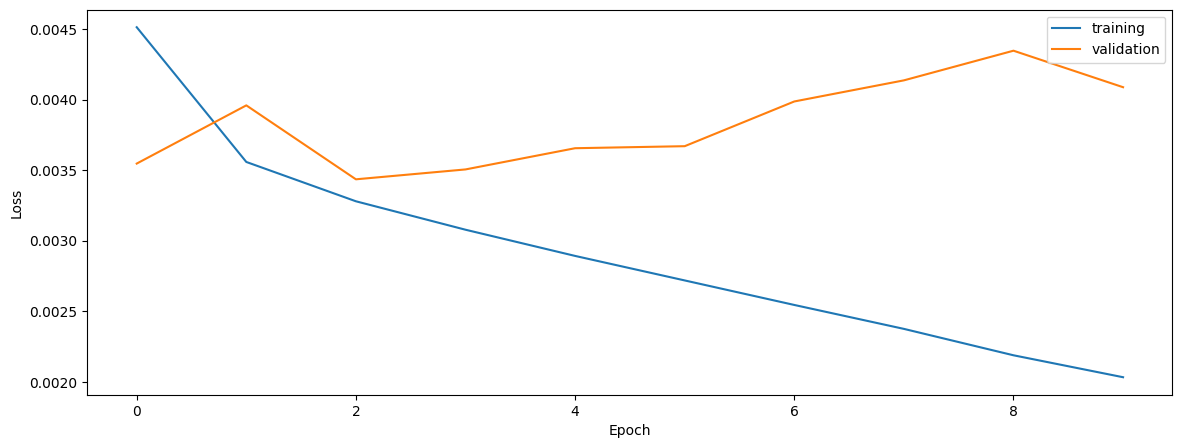

In [6]:
from util import pickleLoad
from visual import plotHistory

history = pickleLoad(path+'/{}.pkl'.format(HASHID))
plotHistory(history)

In [7]:
from util import getPearson, predictInBatches

train_pred = predictInBatches(model,train[0],architecture['batch_size'])
val_pred = predictInBatches(model,val[0],architecture['batch_size'])
test_pred = predictInBatches(model,test[0],architecture['batch_size'])

print('train')
print(getPearson(train[1],train_pred))
print(getPearson(val[1],val_pred))
print(getPearson(test[1],test_pred))

train
0.8344604187096761
0.7967631181438845
0.8060790396664046


In [8]:
print('native')
print(getPearson(train[1],train_pred))
print(getPearson(val[1],val_pred))
print(getPearson(test[1],test_pred))

native
0.8344604187096761
0.7967631181438845
0.8060790396664046


In [9]:
print('normalized')
print(getPearson(train[1][train[2]],train_pred[train[2]]))
print(getPearson(val[1][val[2]],val_pred[val[2]]))
print(getPearson(test[1][test[2]],test_pred[test[2]]))

normalized
0.8377536622162851
0.8006699259186761
0.8137294198058195


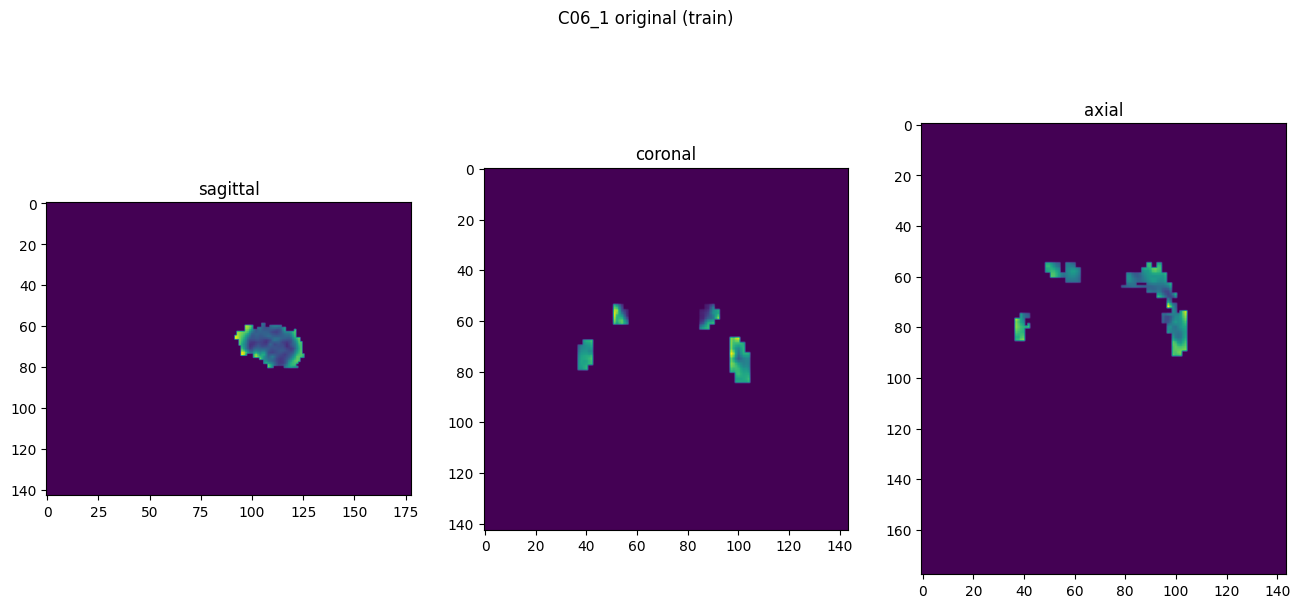

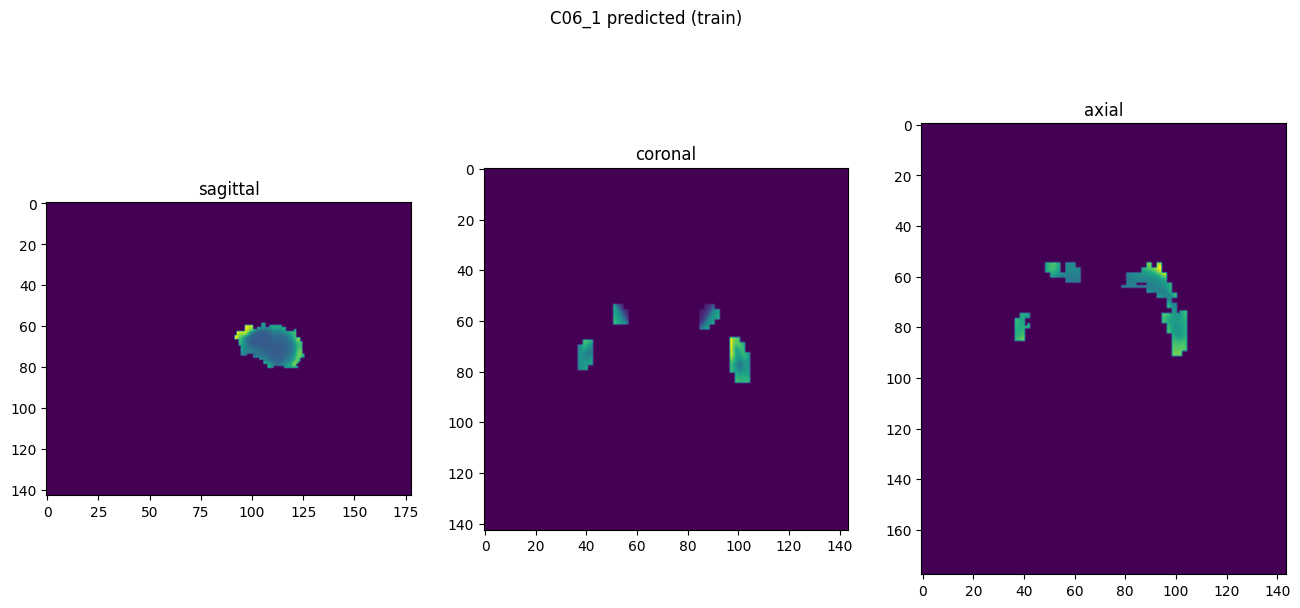

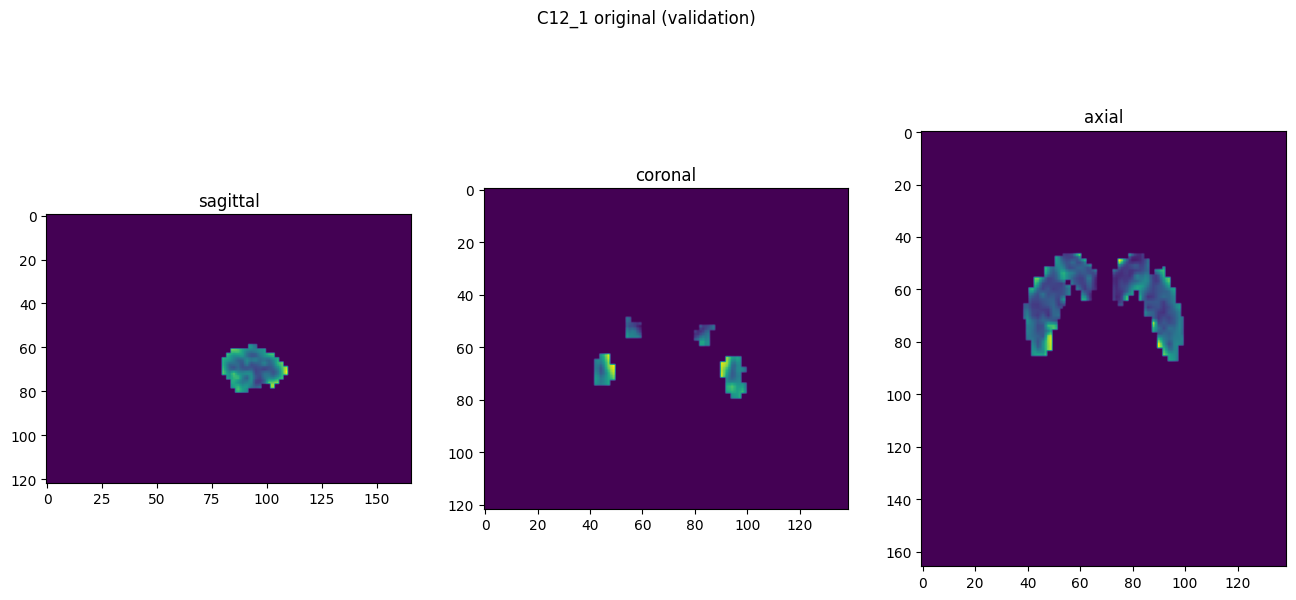

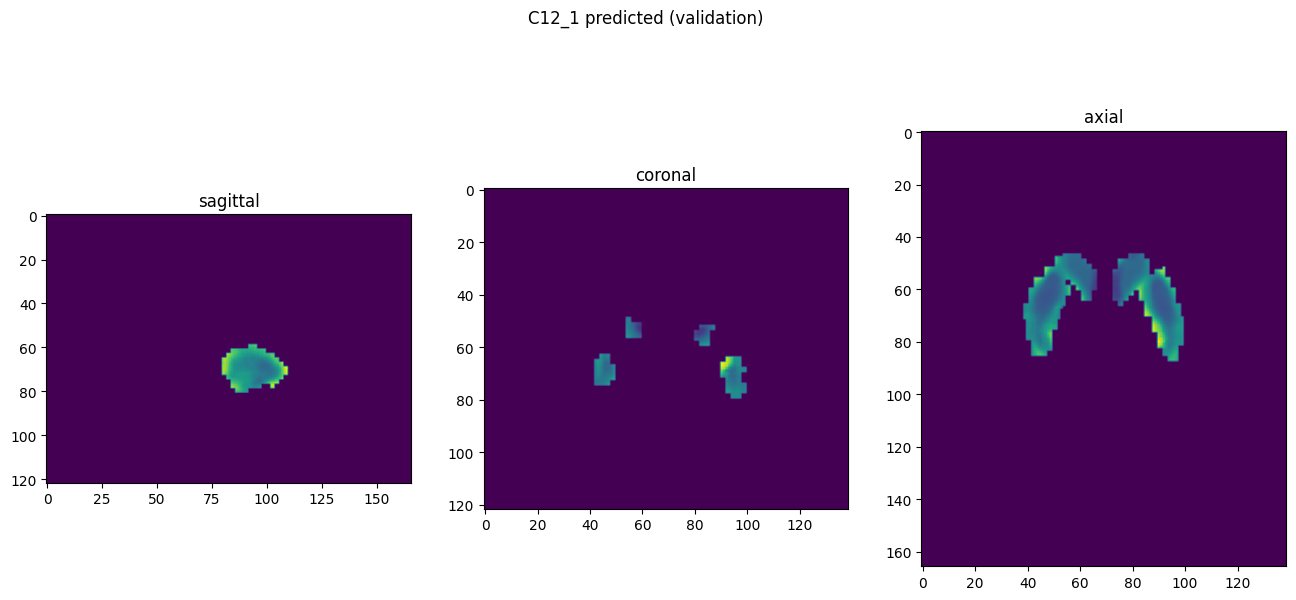

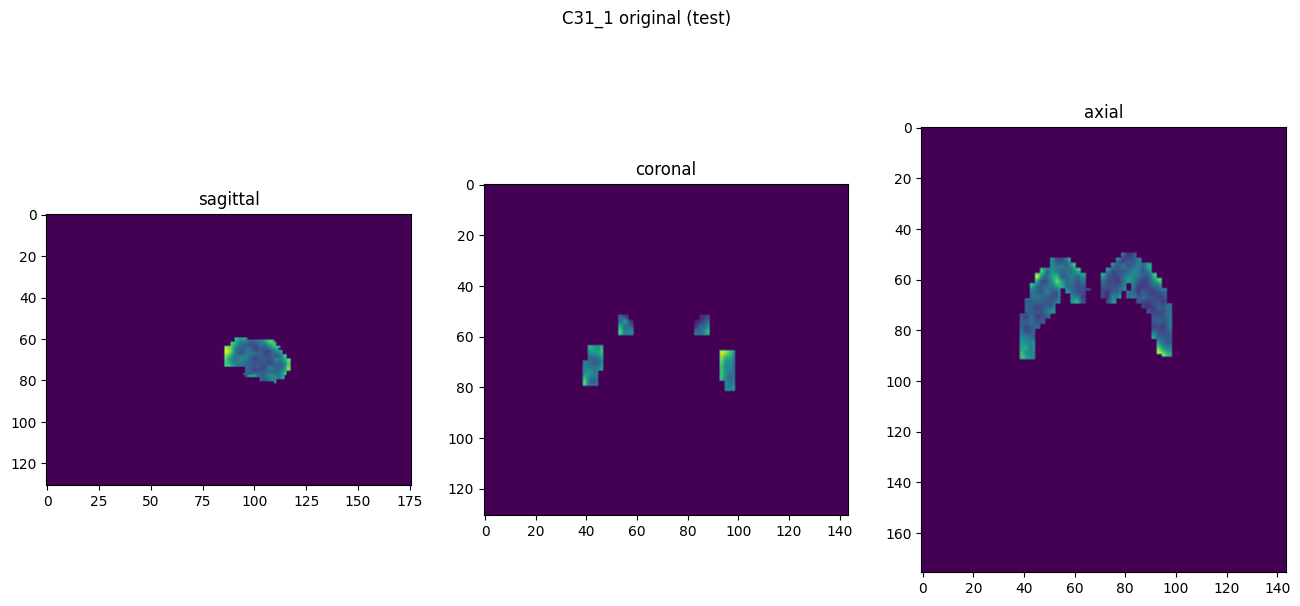

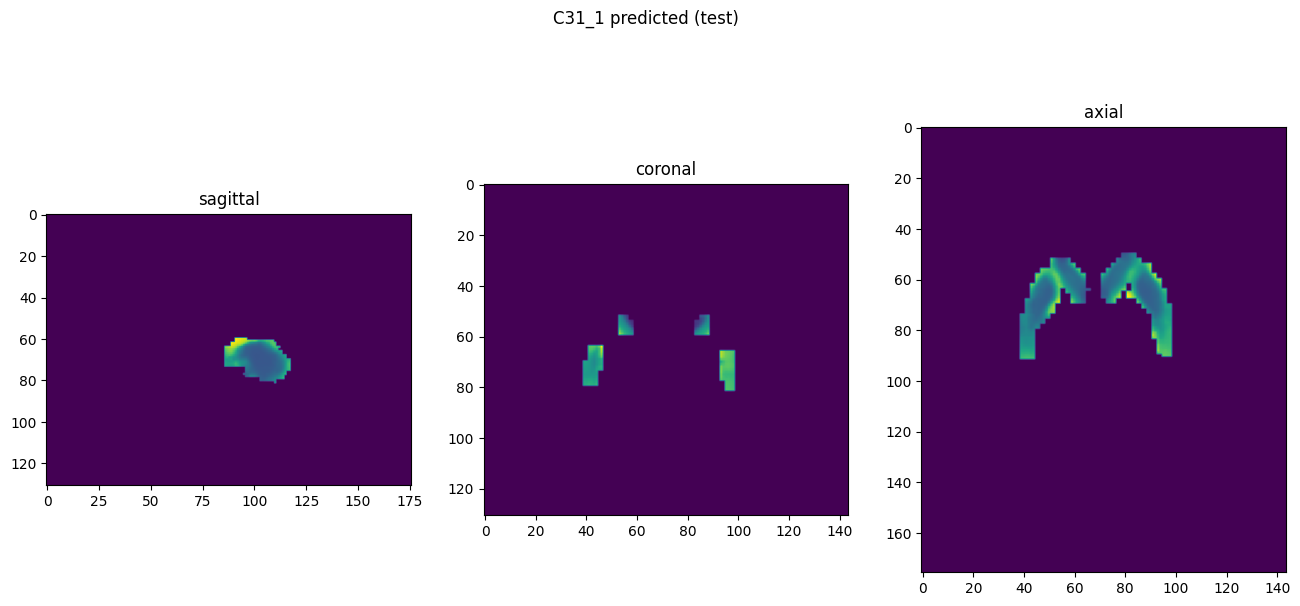

In [10]:
showResults(model, gen, threshold=None, background=False)